In [45]:
from pandas import read_csv, DataFrame

METRIC = "Distance"
PREFIX = "TRI[True]B[64]Do[0.3]Min[True]Split[False]Pos[True]FW[True]LR[0.0001]SIZE[64]LOSS[stn_contrastive]CHRYS[False]DYD[True]SAMPLE[True]COMMENT[False]."
PREFIX = ""
df = read_csv(f"{PREFIX}pairs-last-experiment.csv")
df.sort_values(METRIC).tail()["TestPre"]

14    0.095541
13    0.095453
12    0.095376
11    0.095348
10    0.095199
Name: TestPre, dtype: float64

In [46]:
classes = sorted(list(set(df.ComparedClass.unique()).union(set(df.ComparatorClass.unique()))))
classes

['PC1',
 'PC10',
 'PC12',
 'PC13',
 'PC14',
 'PC15',
 'PC16',
 'PC17',
 'PC18',
 'PC19',
 'PC2',
 'PC20',
 'PC20b',
 'PC21',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'PC9',
 'PCX']

In [47]:
from pandas import concat
def get_sub_df(cls, mirror=False):
    if "," in cls:
        sub = df[(df.ComparedClass.str.isin(cls.split(","))) & (df.ComparatorClass.isin(cls.split(",")))]
    else:
        sub = df[(df.ComparedClass == cls) & (df.ComparatorClass == cls)]
    if not mirror:
        return sub
    sub2 = sub.copy()
    #sub2.loc[:, ['ComparatorLabel','ComparedLabel']] = sub.loc[:, ['ComparedLabel','ComparatorLabel']].values
    return concat([sub, sub2])

get_sub_df("PC7", True).head()

Unnamed: 0 ComparedClass         ComparedLabel ComparatorClass  \
0         709           PC7  PC7 - DeIeiunoSermo2             PC7   
1        3124           PC7  PC7 - DeIeiunoSermo3             PC7   
2        1049           PC7  PC7 - DeIeiunoSermo3             PC7   
3        3464           PC7  PC7 - DeIeiunoSermo4             PC7   
4        1668           PC7  PC7 - DeIeiunoSermo4             PC7   

        ComparatorLabel  Distance  Probability  Attribution  IsAPair  K  ...  \
0  PC7 - DeIeiunoSermo3  0.029012     0.970988         True     True  0  ...   
1  PC7 - DeIeiunoSermo2  0.030766     0.969234         True     True  0  ...   
2  PC7 - DeIeiunoSermo4  0.077013     0.922987         True     True  0  ...   
3  PC7 - DeIeiunoSermo3  0.082985     0.917015         True     True  0  ...   
4  PC7 - DeIeiunoSermo5  0.117469     0.882531         True     True  0  ...   

   TestFN  TestTP  TestTN  DevTPR  DevPre  DevFPR  DevFP  DevFN  DevTP  DevTN  
0    2346       0   22460     0.0     0.0     0.0      0   1870      0  17870  
1    2346       0   22460     0.0     0.0     0.0      0   1870      0  17870  
2    2346       0   22460     0.0     0.0     0.0      0   1870      0  17870  
3    2346       0   22460     0.0     0.0     0.0      0   1870      0  17870  
4    2346       0   22460     0.0     0.0     0.0      0   1870      0  17870  

[5 rows x 25 columns]

In [48]:
PRE = [1., 0.99, .95, .90, .85, .80, .75]

data = []

for pc in classes:
    subdf = get_sub_df(pc)
    nb_elems = subdf.shape[0]
    
    if not nb_elems:
        continue

    data.extend([
        {
            "Precision": f"{metric}:{score}",
            "Value": round(subdf[subdf[metric] >= score].shape[0] / nb_elems, 2),
            "PC": pc
        }
        for metric in ["TestPre", "DevPre"]
        for score in PRE
    ])

In [49]:
viz_df = DataFrame(data)
viz_df

Precision  Value   PC
0     TestPre:1.0   0.00  PC1
1    TestPre:0.99   0.00  PC1
2    TestPre:0.95   0.50  PC1
3     TestPre:0.9   0.50  PC1
4    TestPre:0.85   1.00  PC1
..            ...    ...  ...
261   DevPre:0.95   0.00  PC9
262    DevPre:0.9   0.00  PC9
263   DevPre:0.85   0.00  PC9
264    DevPre:0.8   0.05  PC9
265   DevPre:0.75   0.05  PC9

[266 rows x 3 columns]

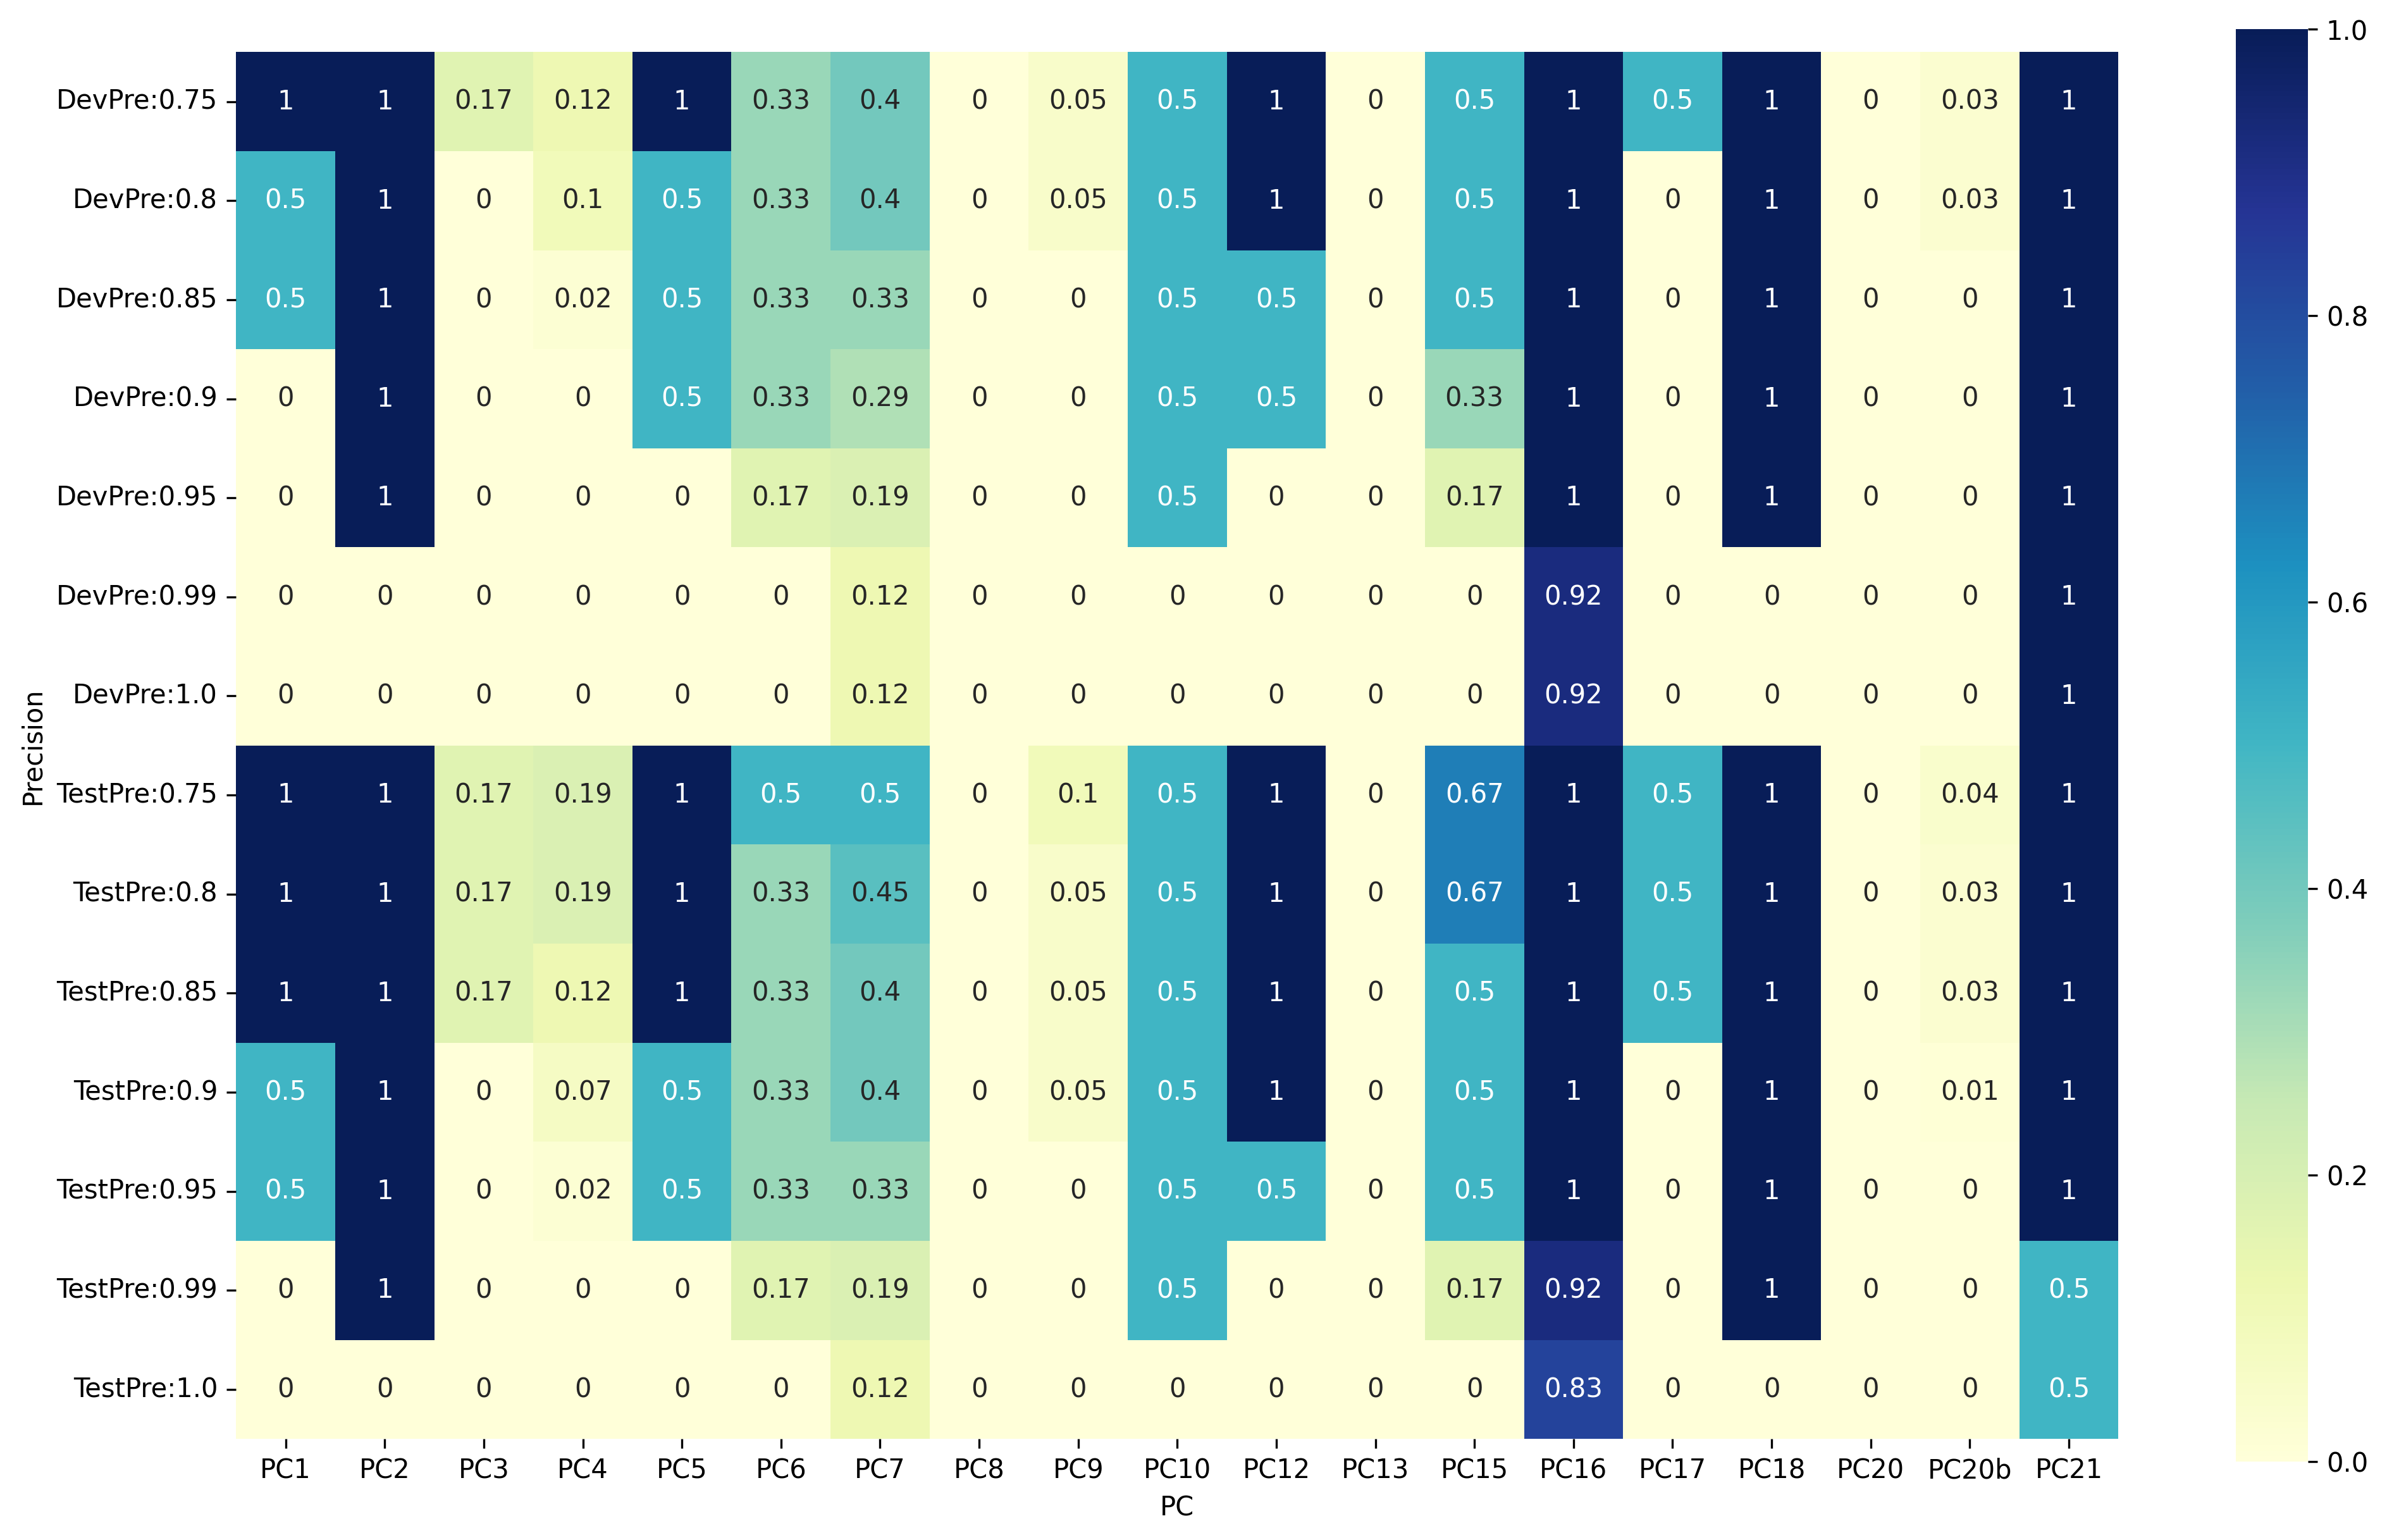

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

piv = viz_df.pivot("Precision", "PC", "Value")
index = sorted(list(piv.columns), key=lambda x: int(x[2:4]))
fig, ax = plt.subplots(1, 1, figsize = (16, 10), dpi=300)
sns.heatmap(piv.loc[:, index], annot=True, square=True, ax=ax, cmap="YlGnBu", vmin=0, vmax=1.0)
fig.savefig("heatmap.png")

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in sing

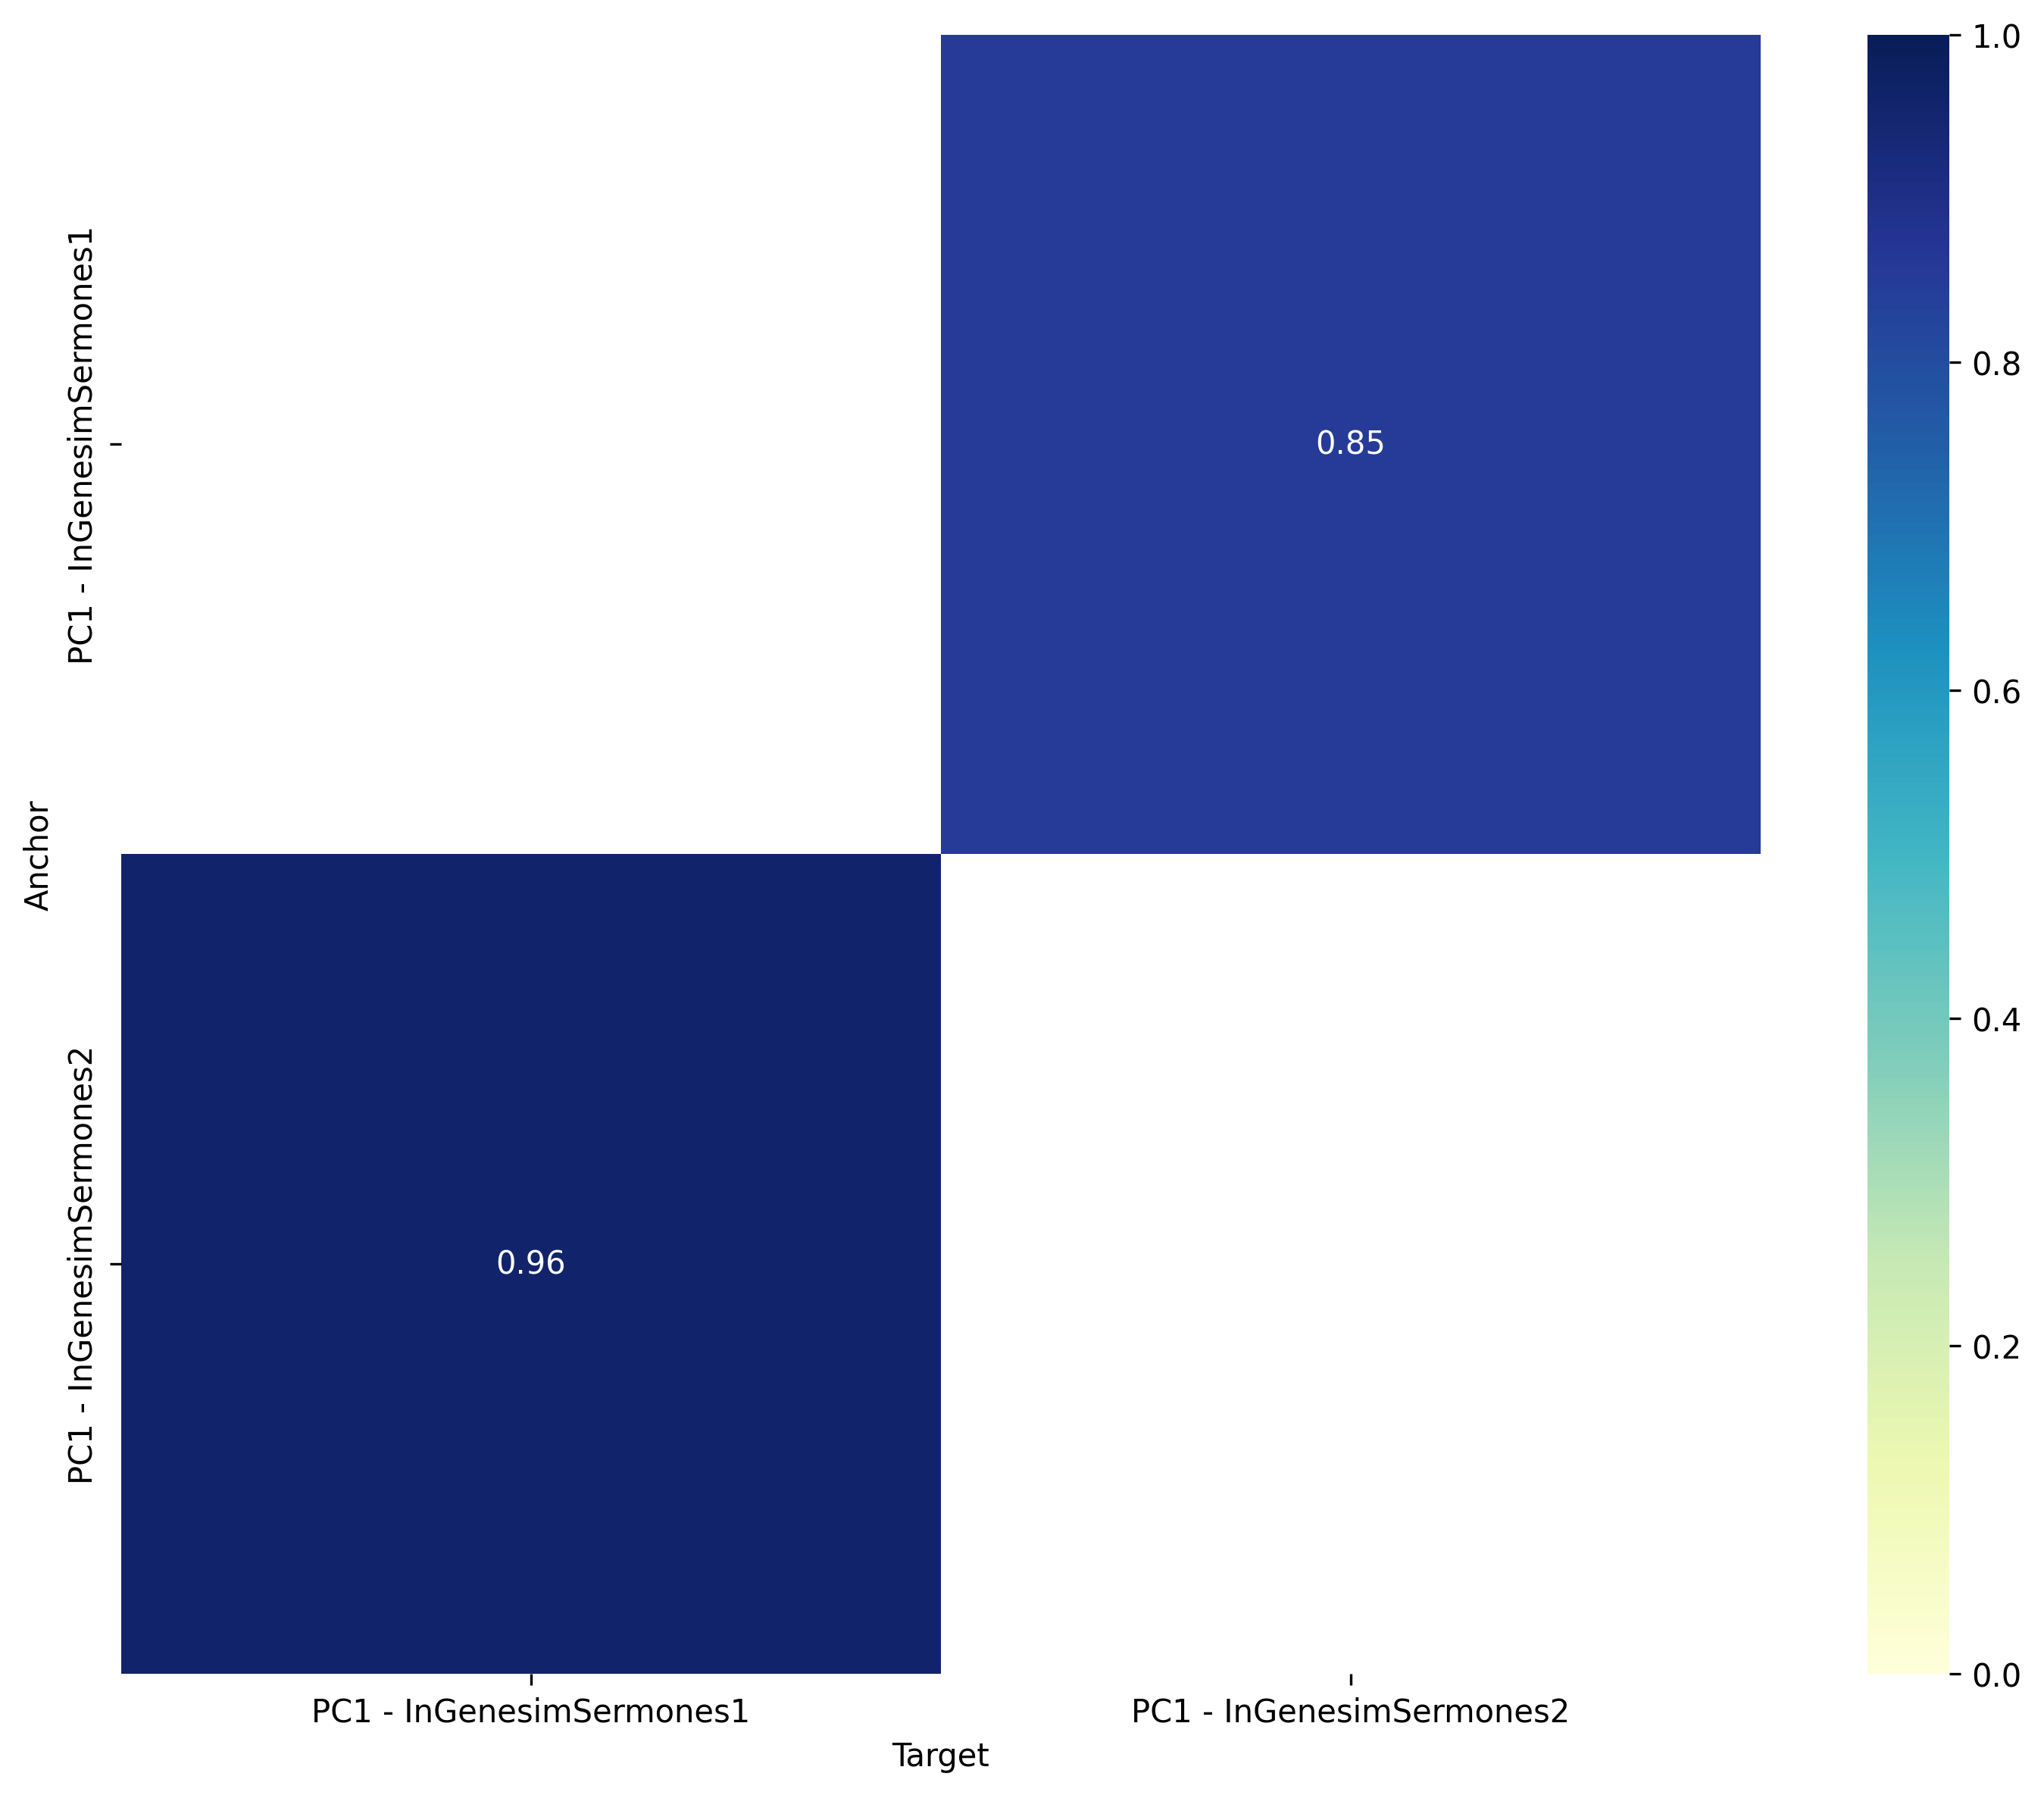

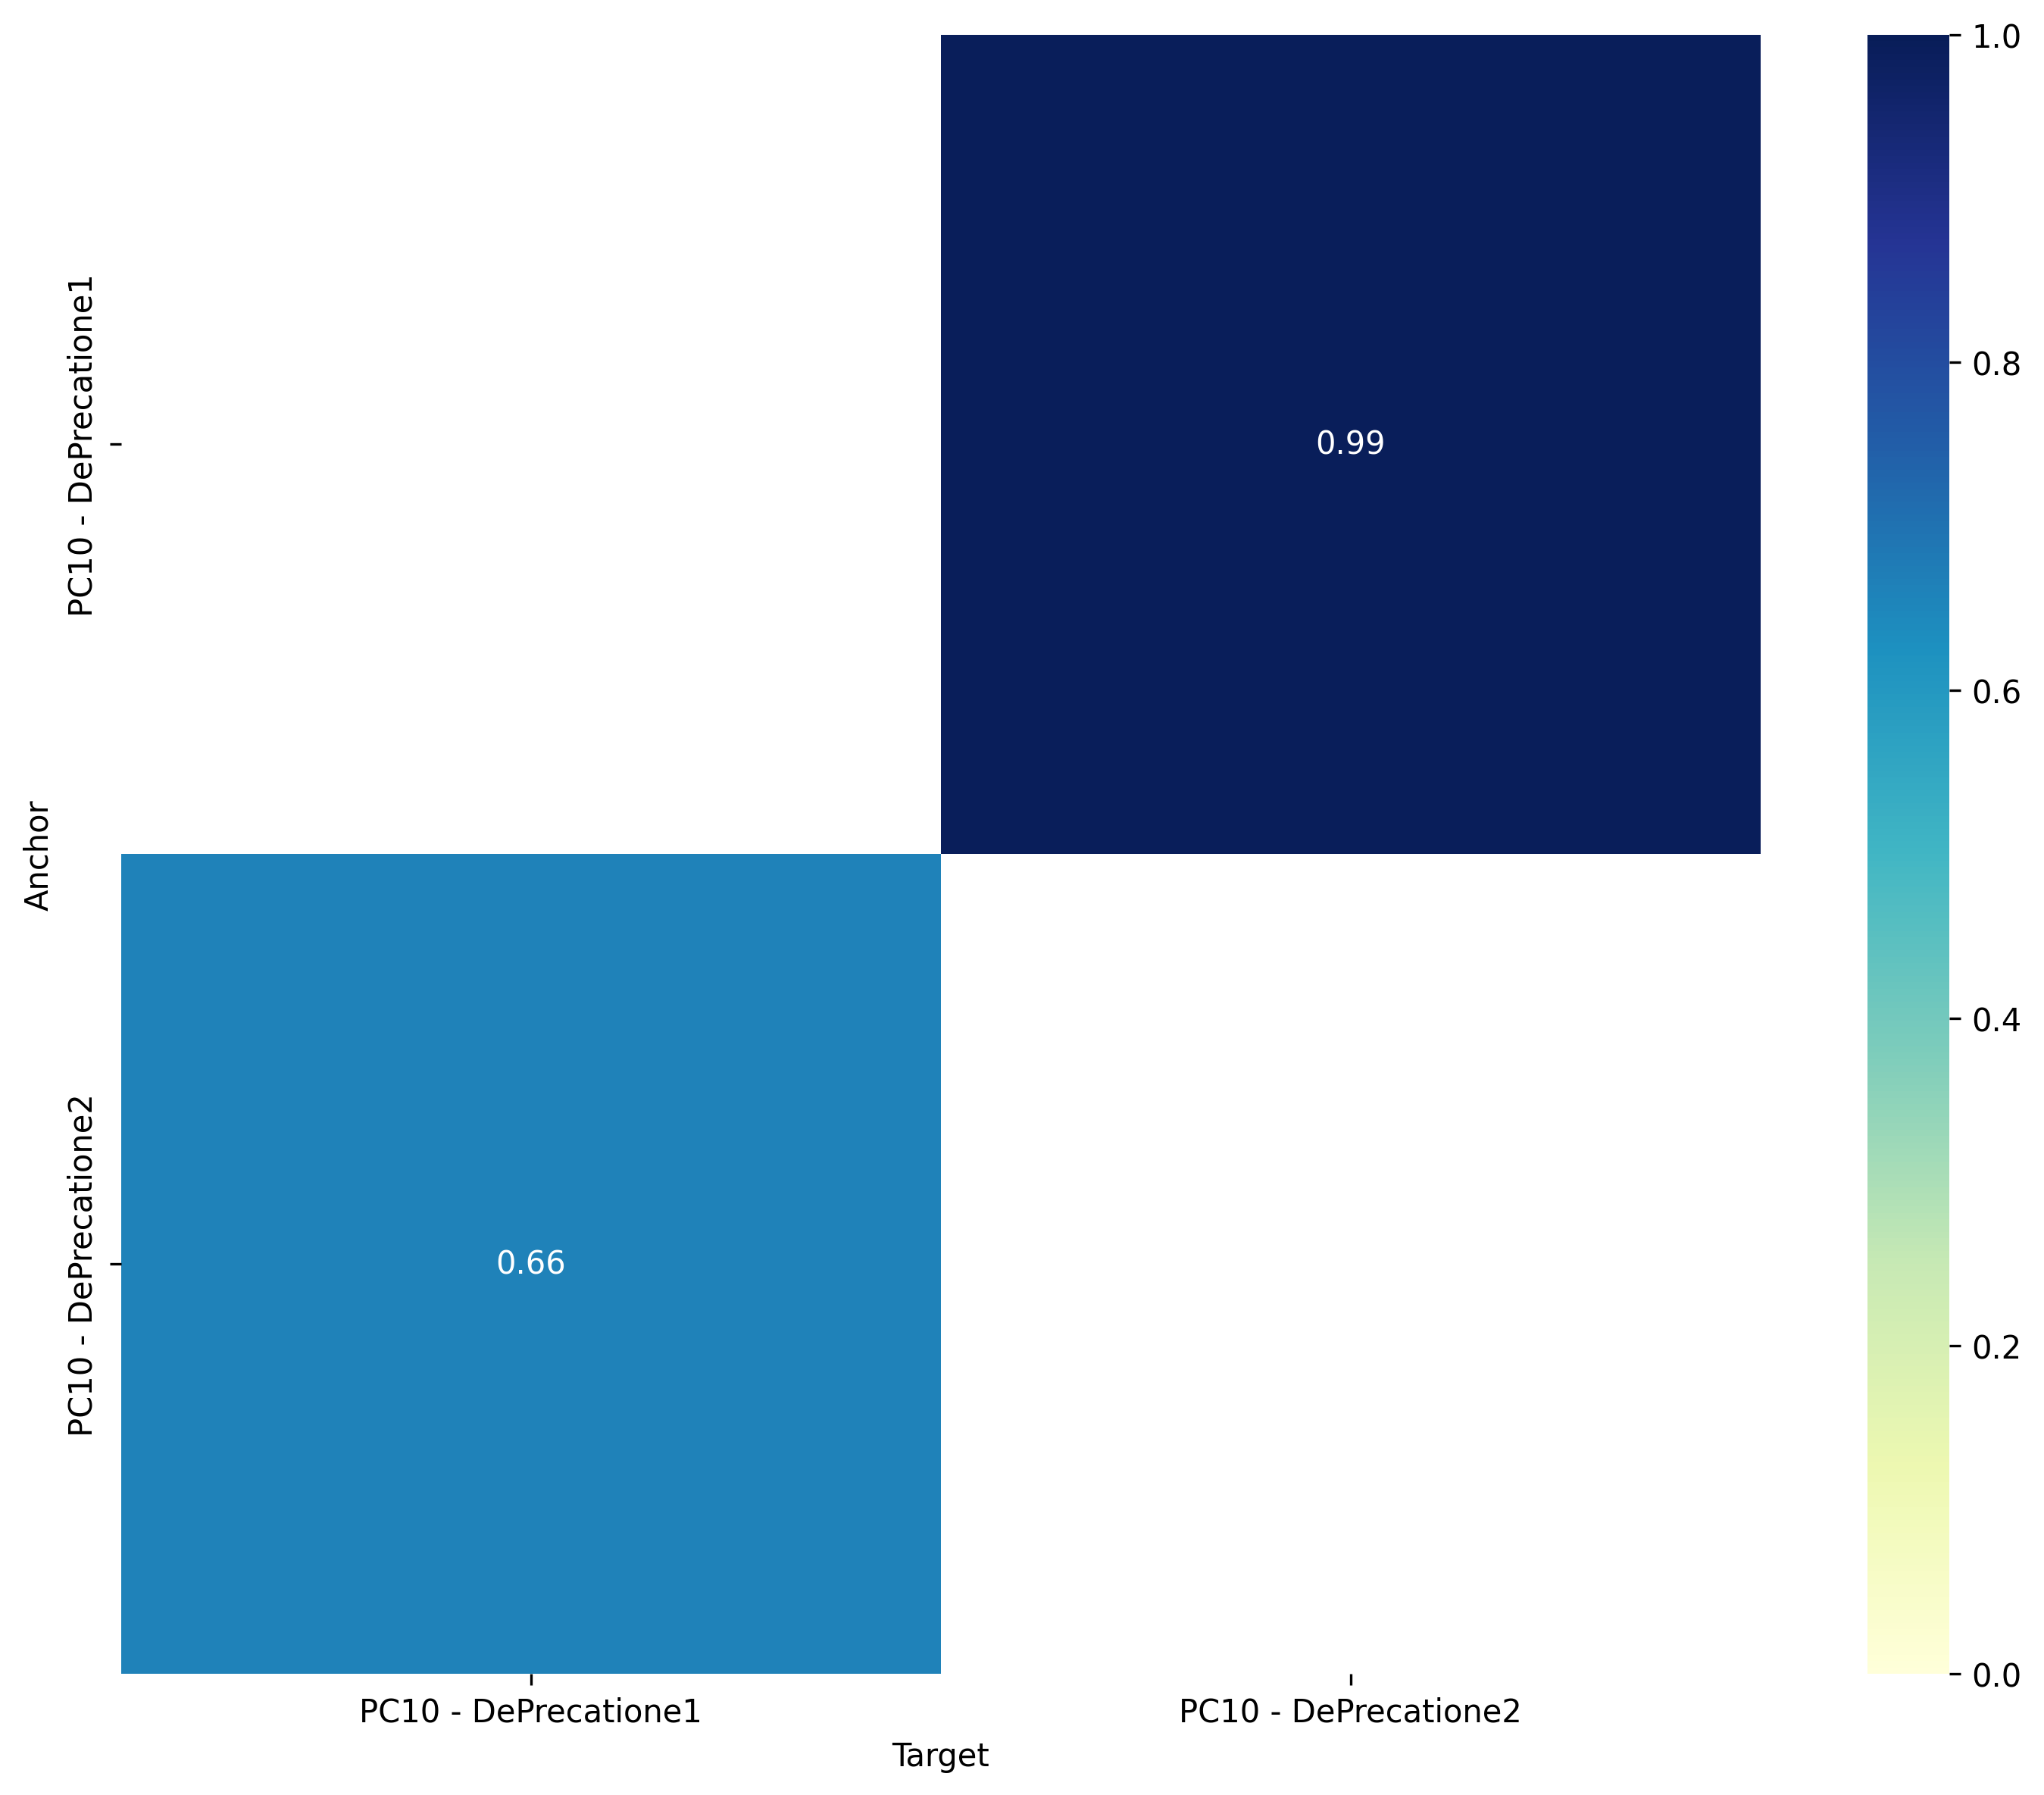

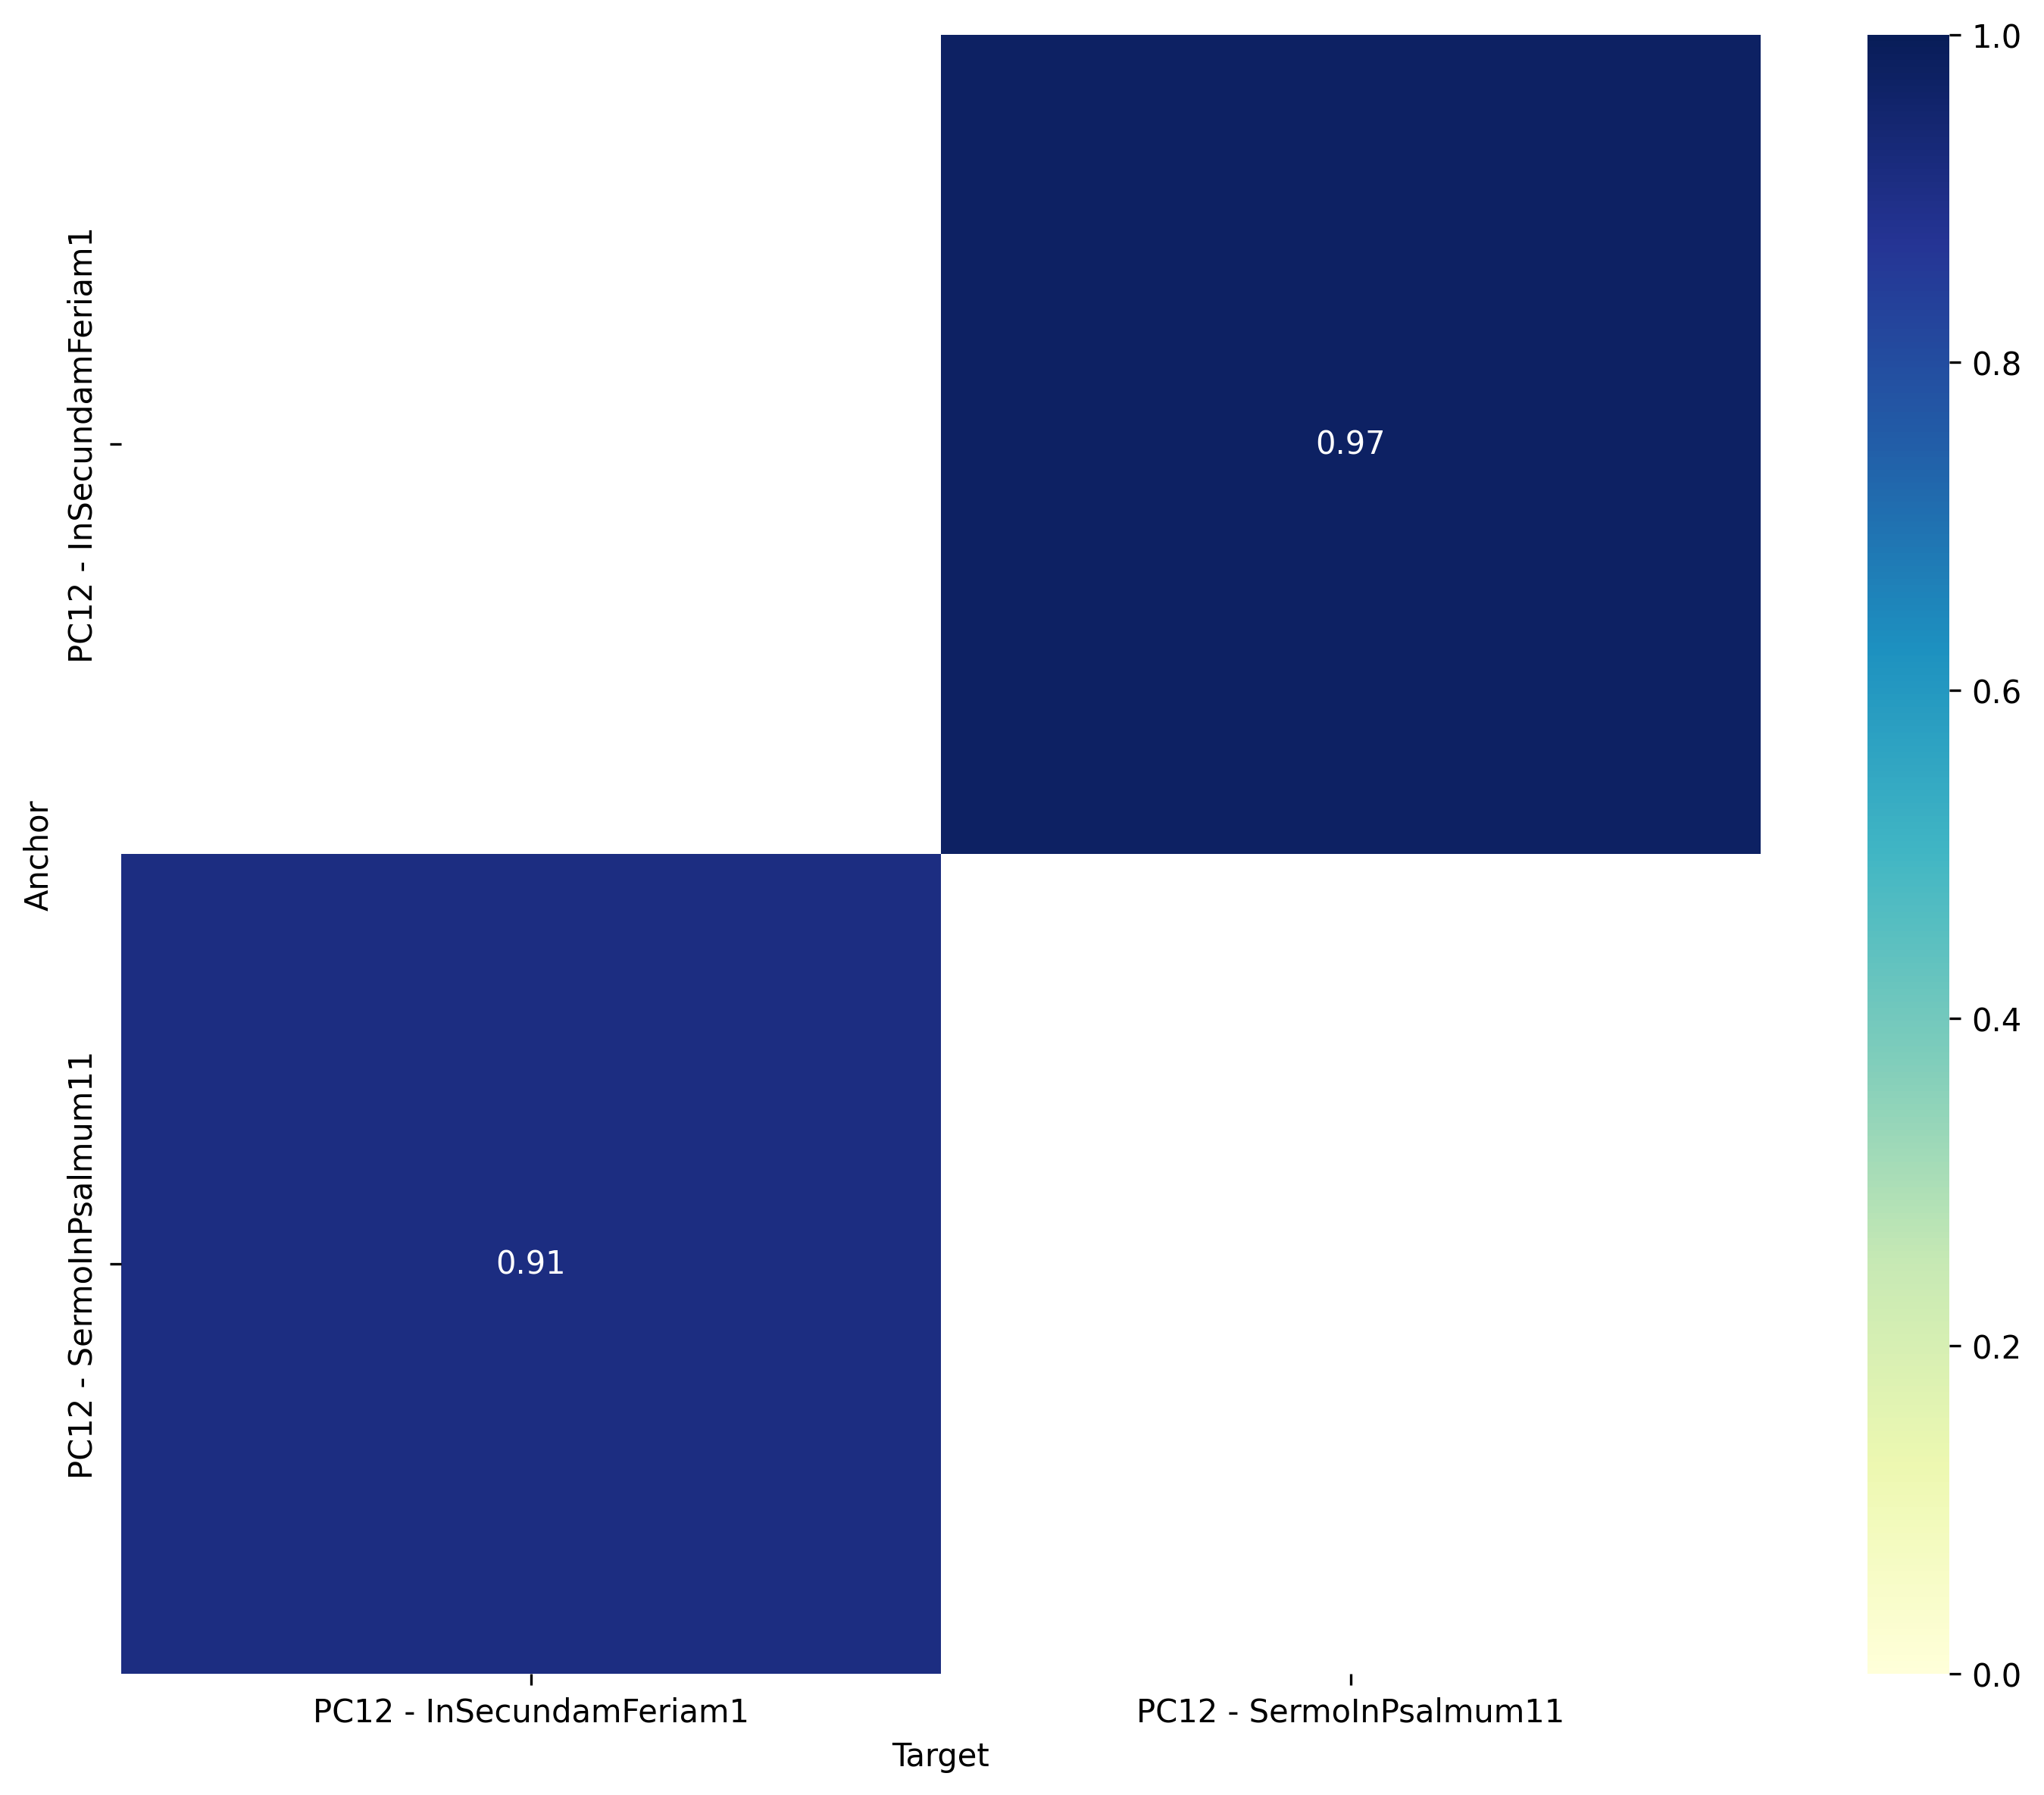

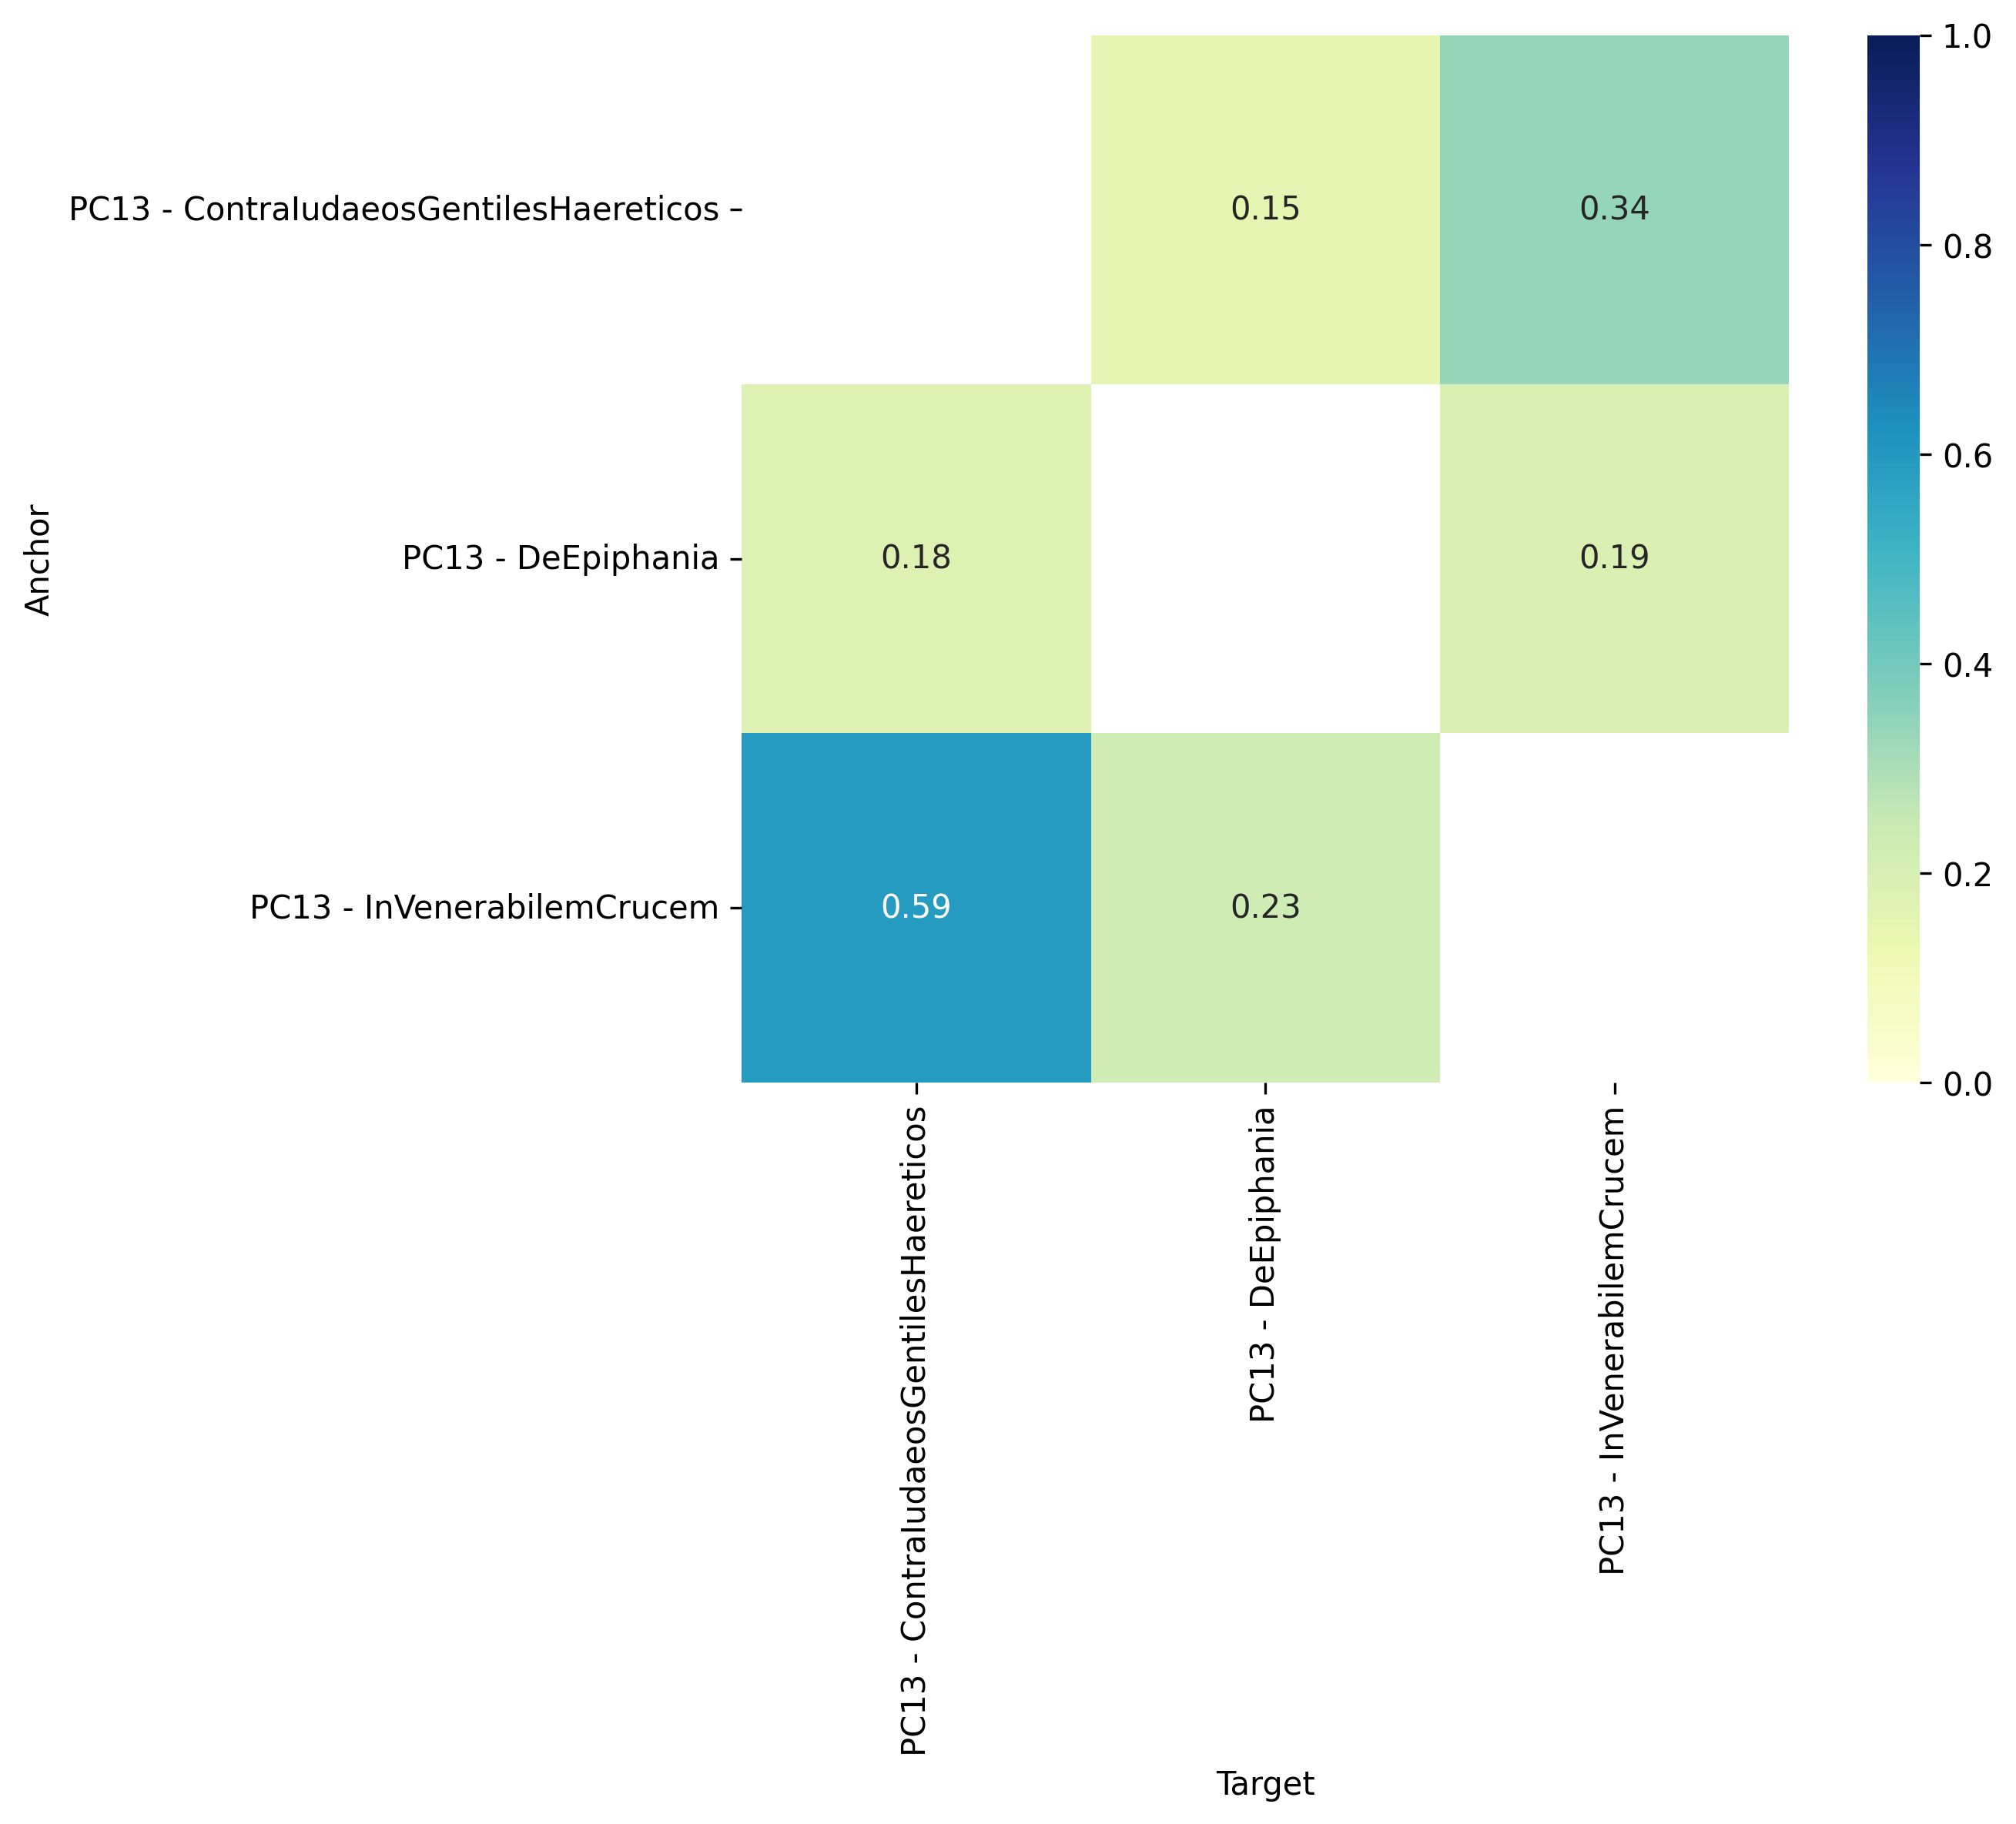

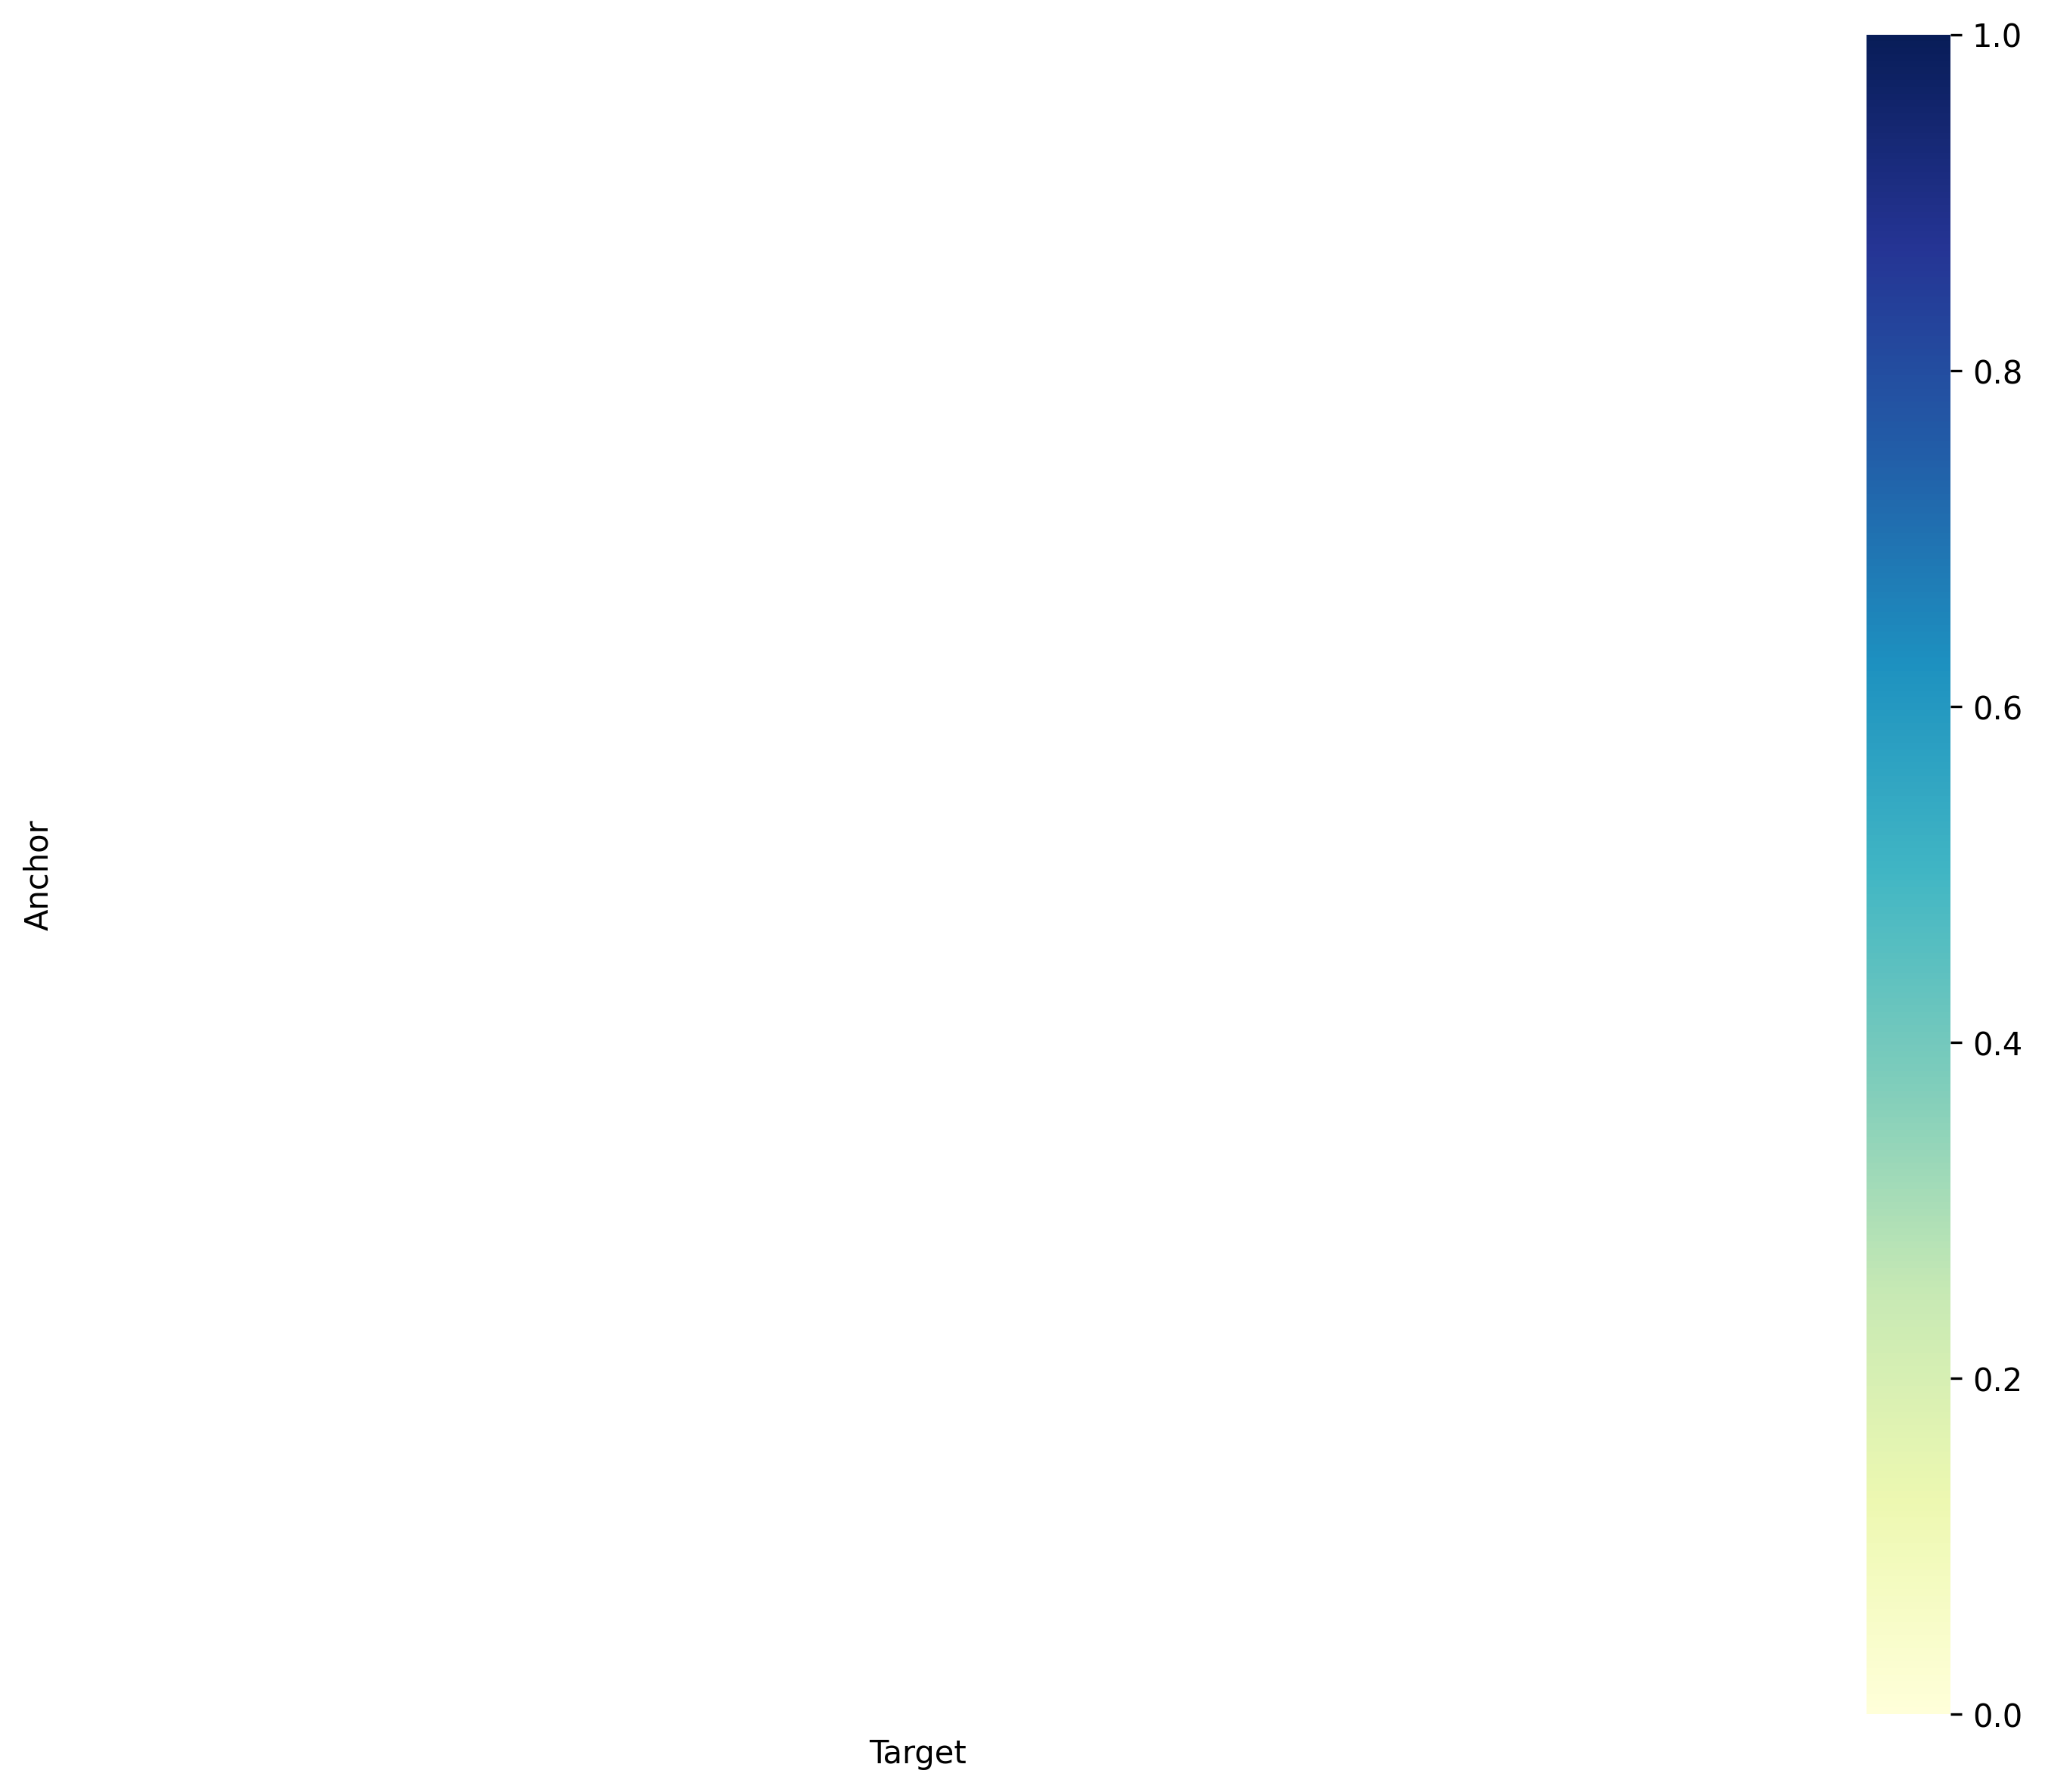

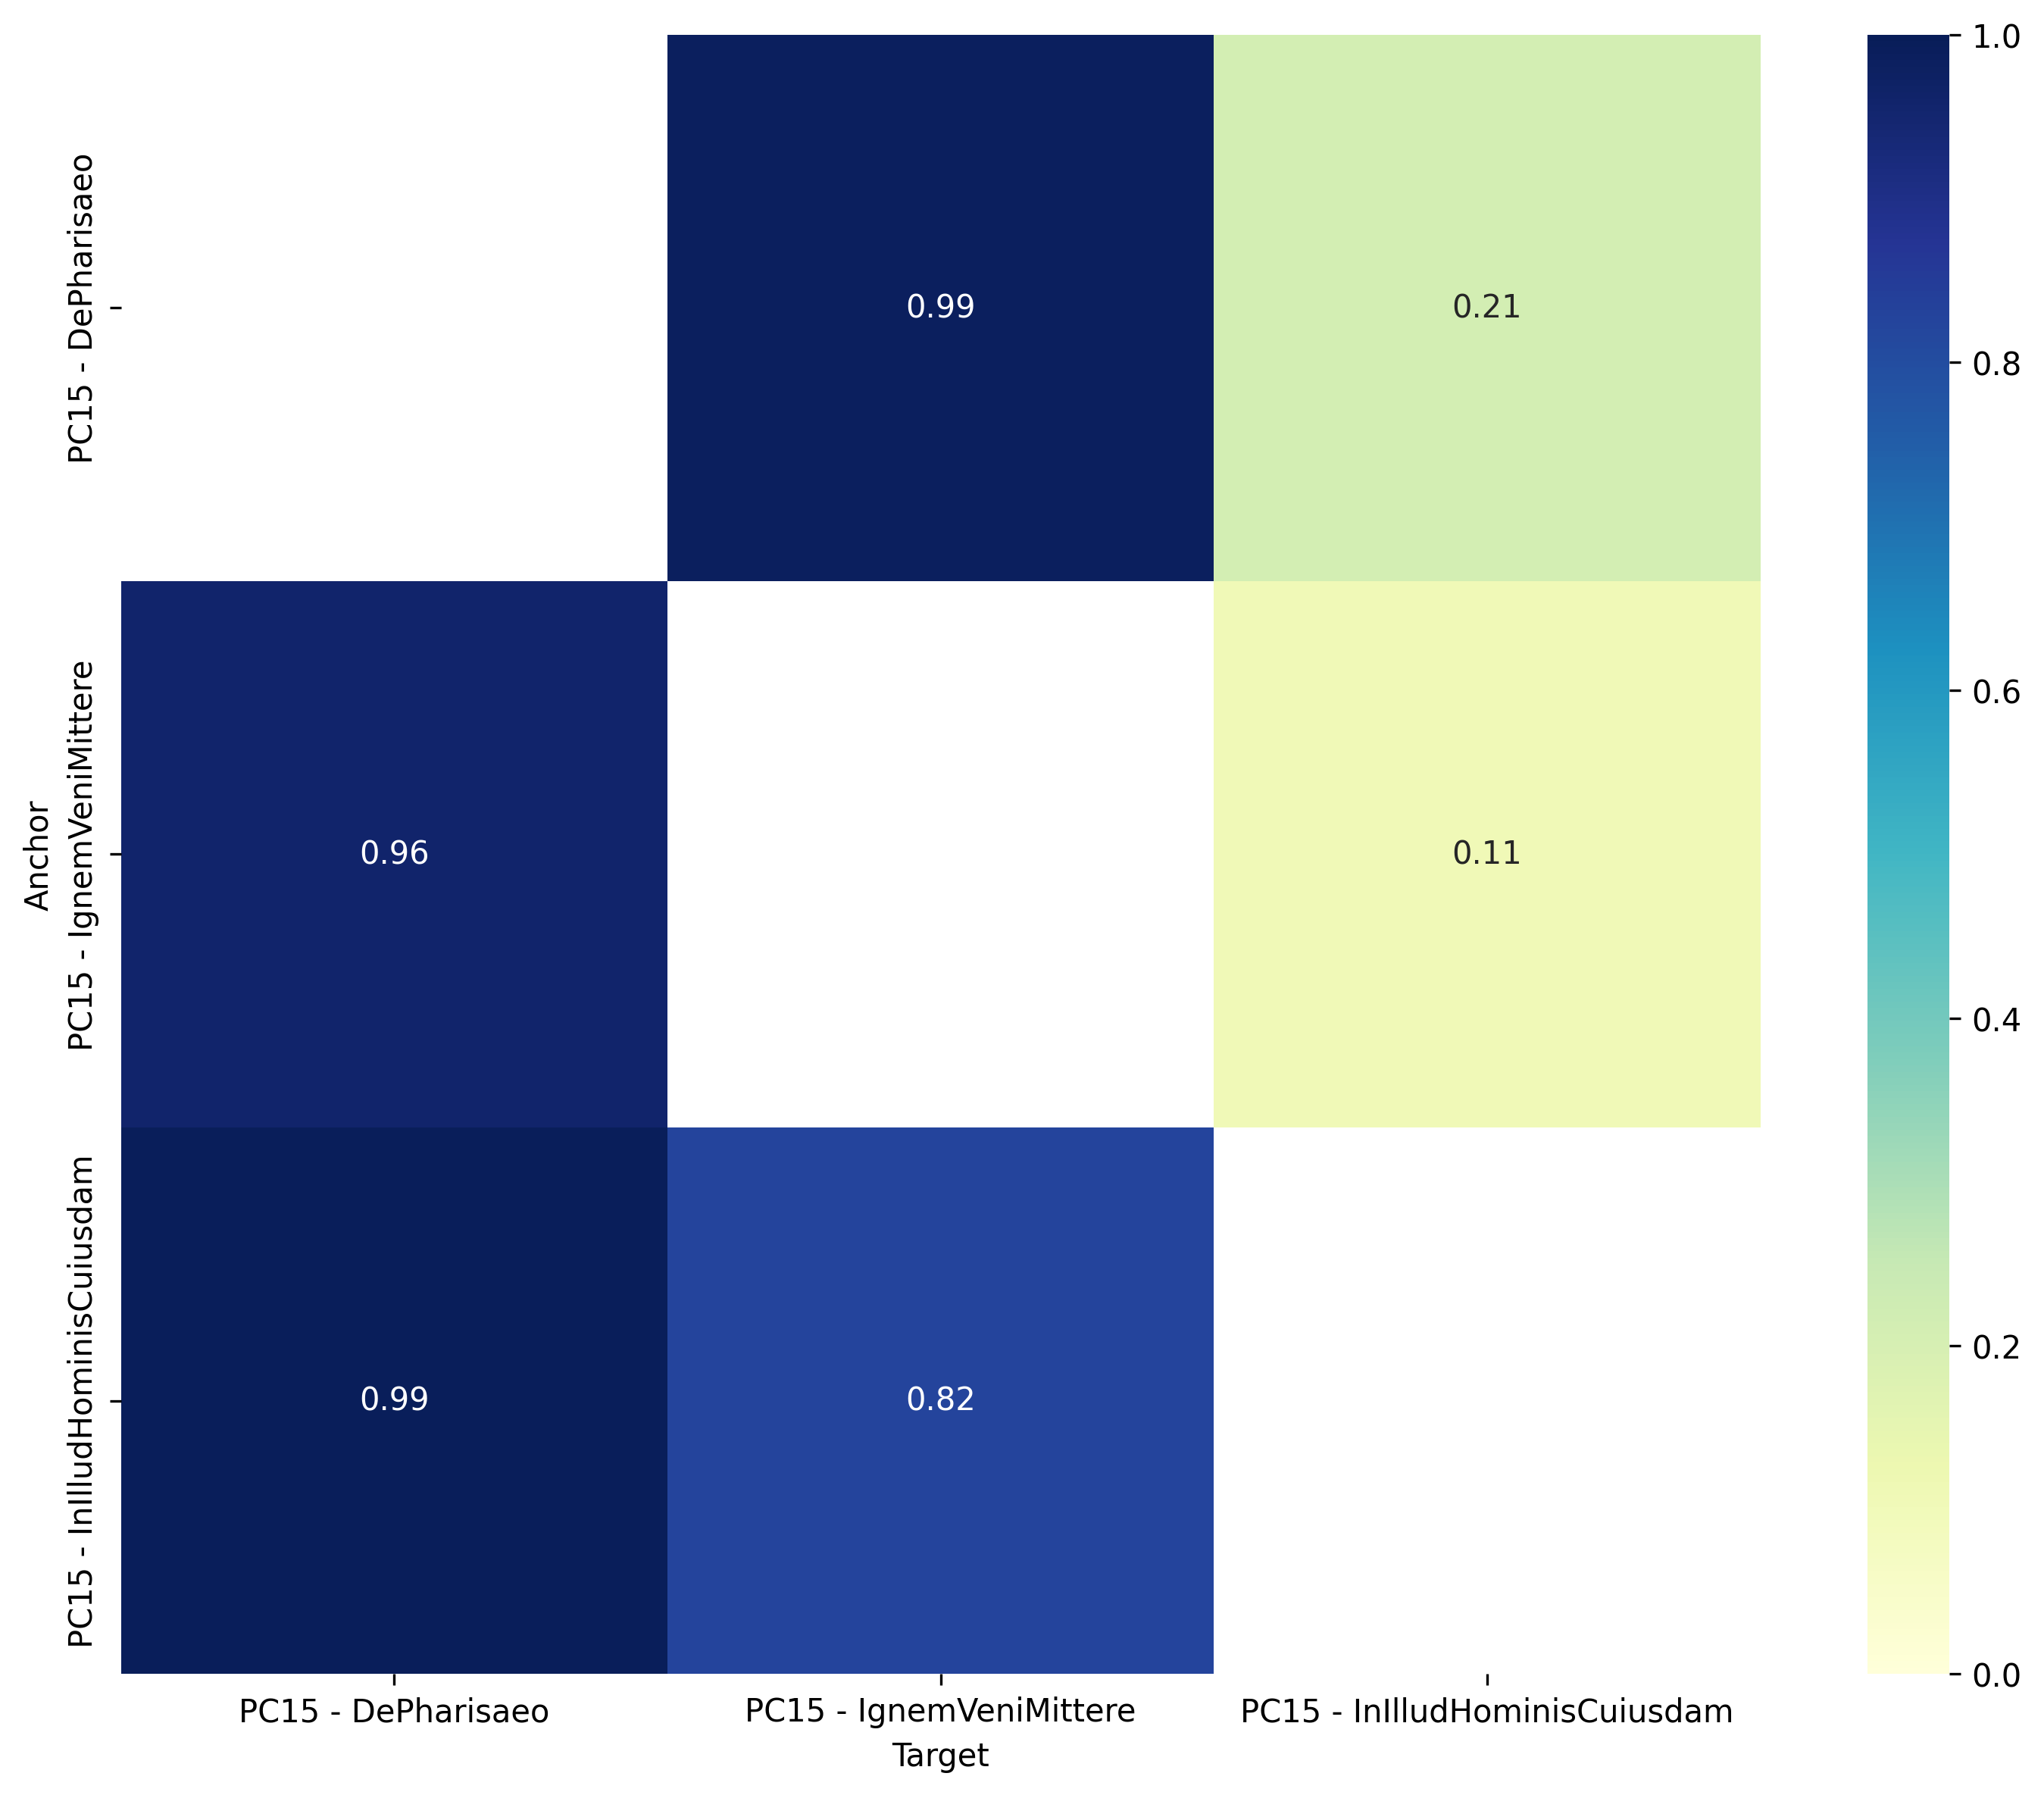

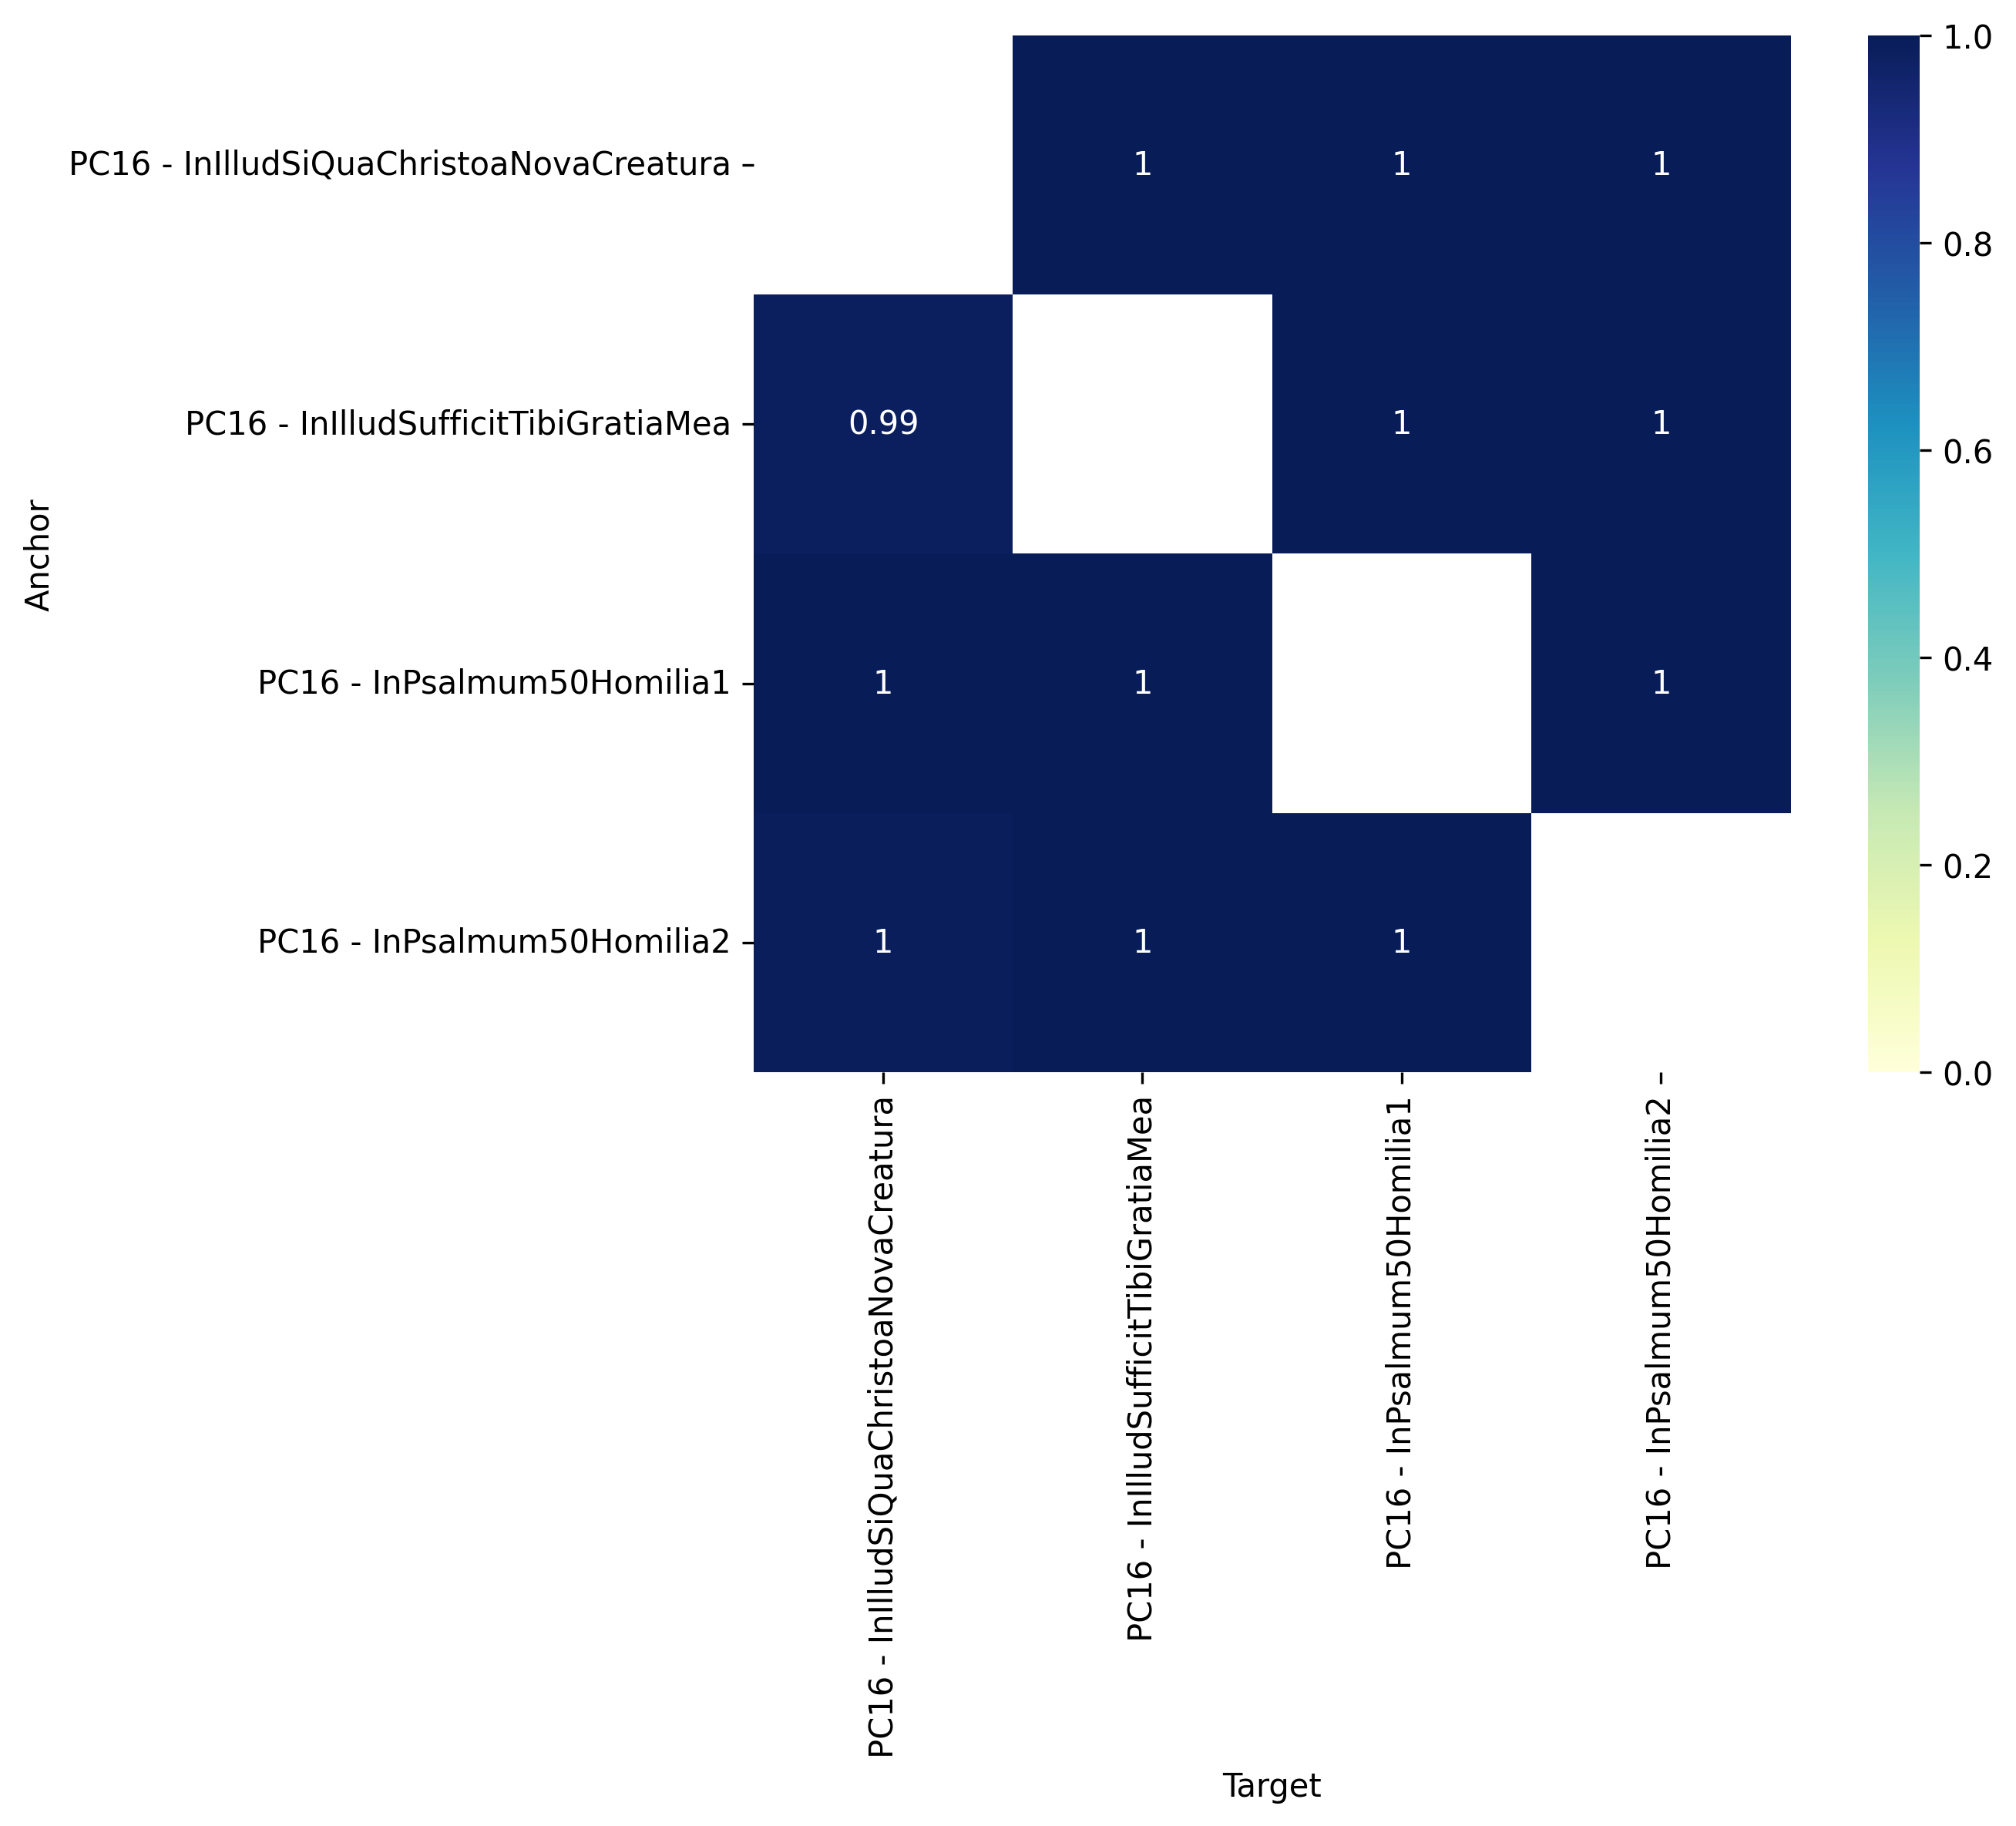

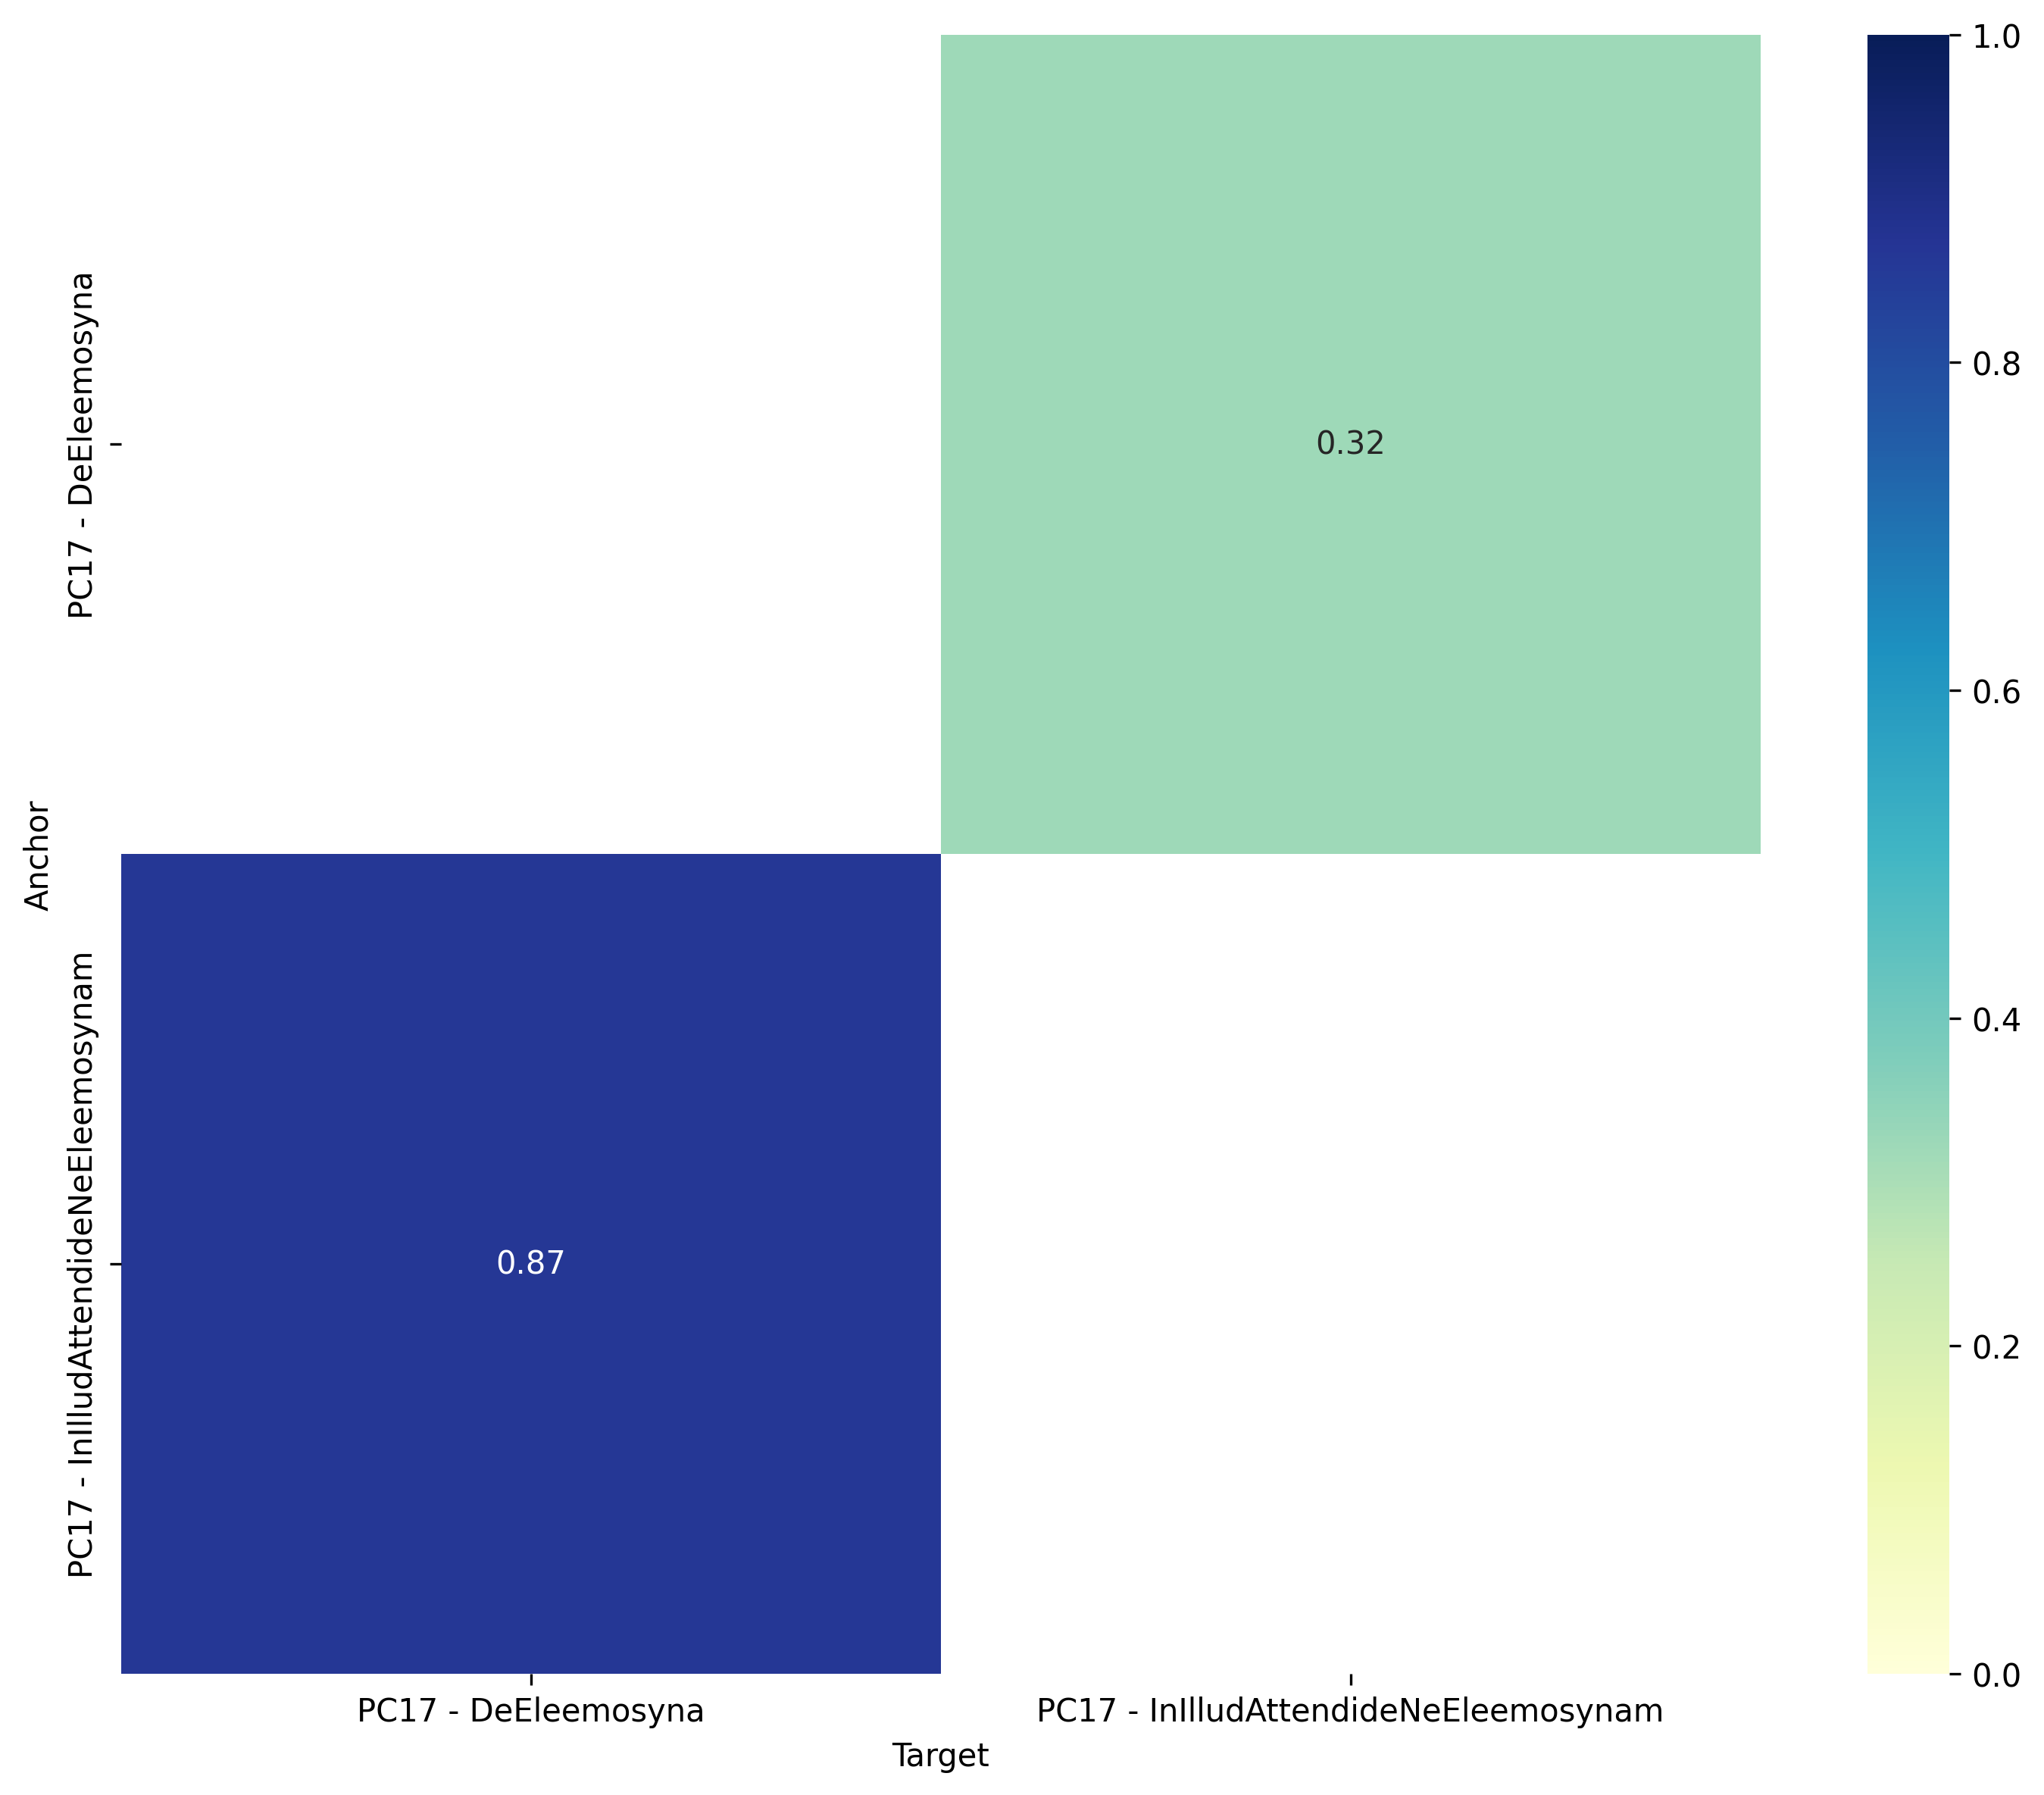

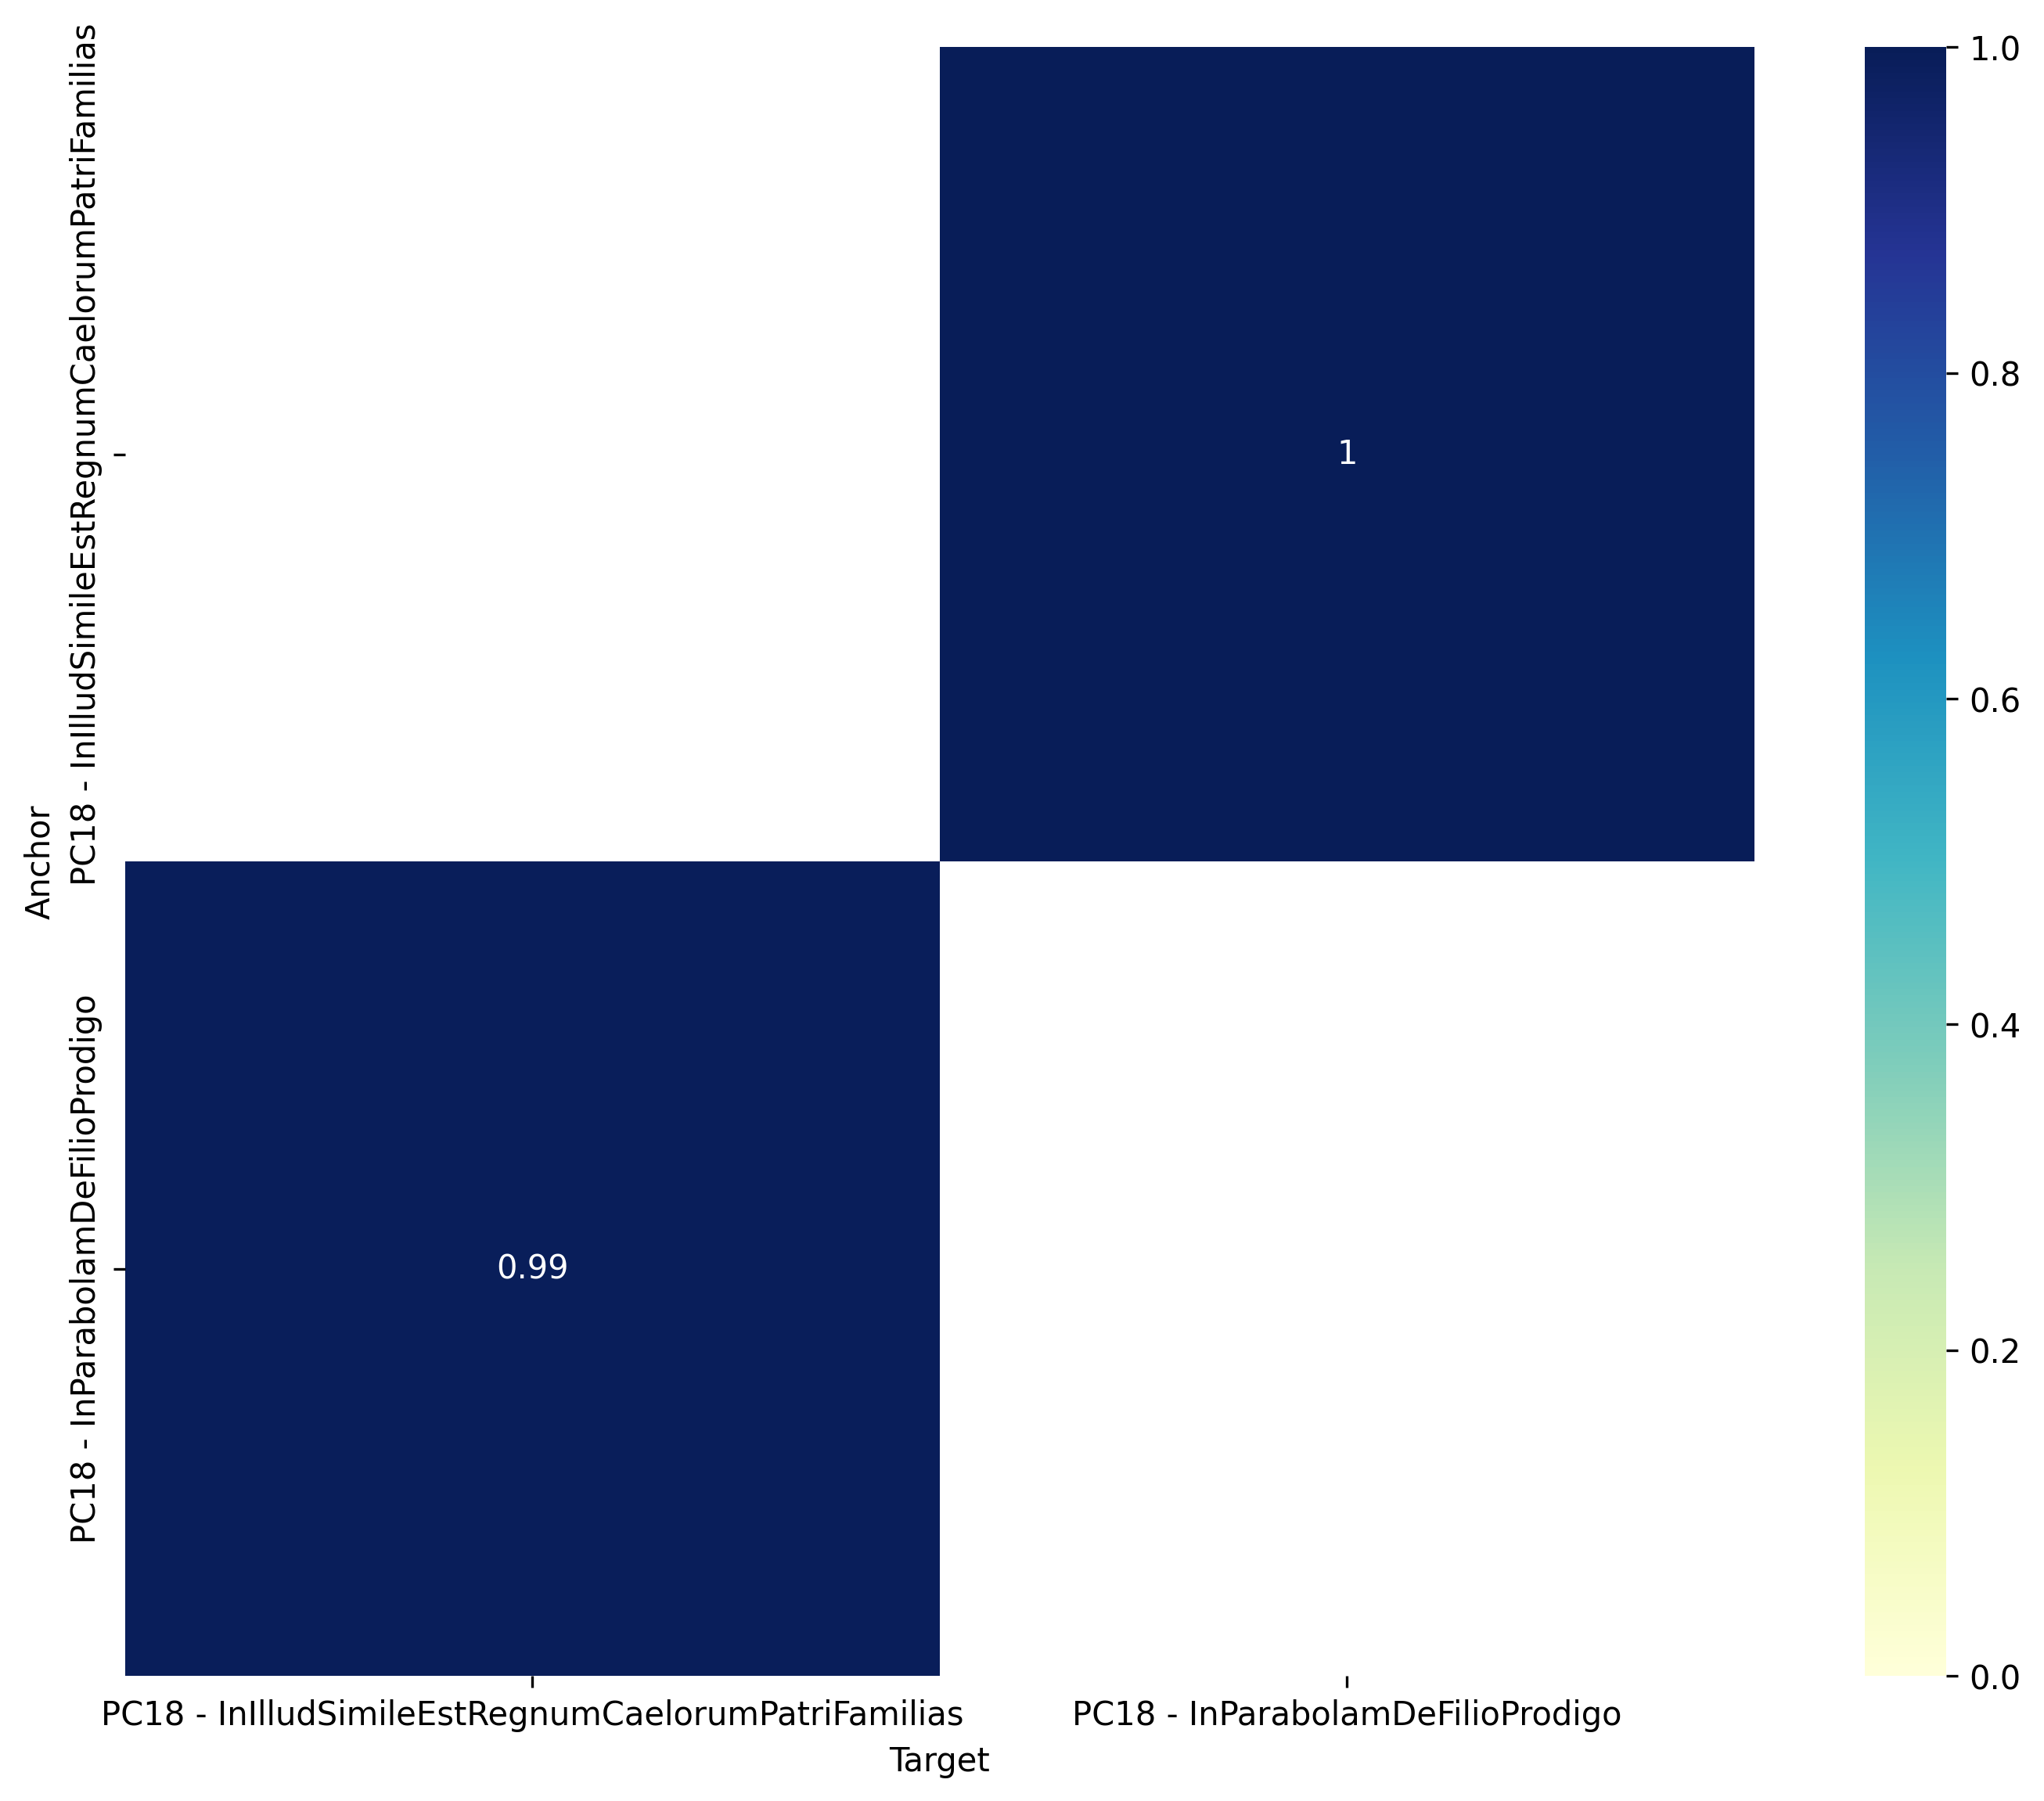

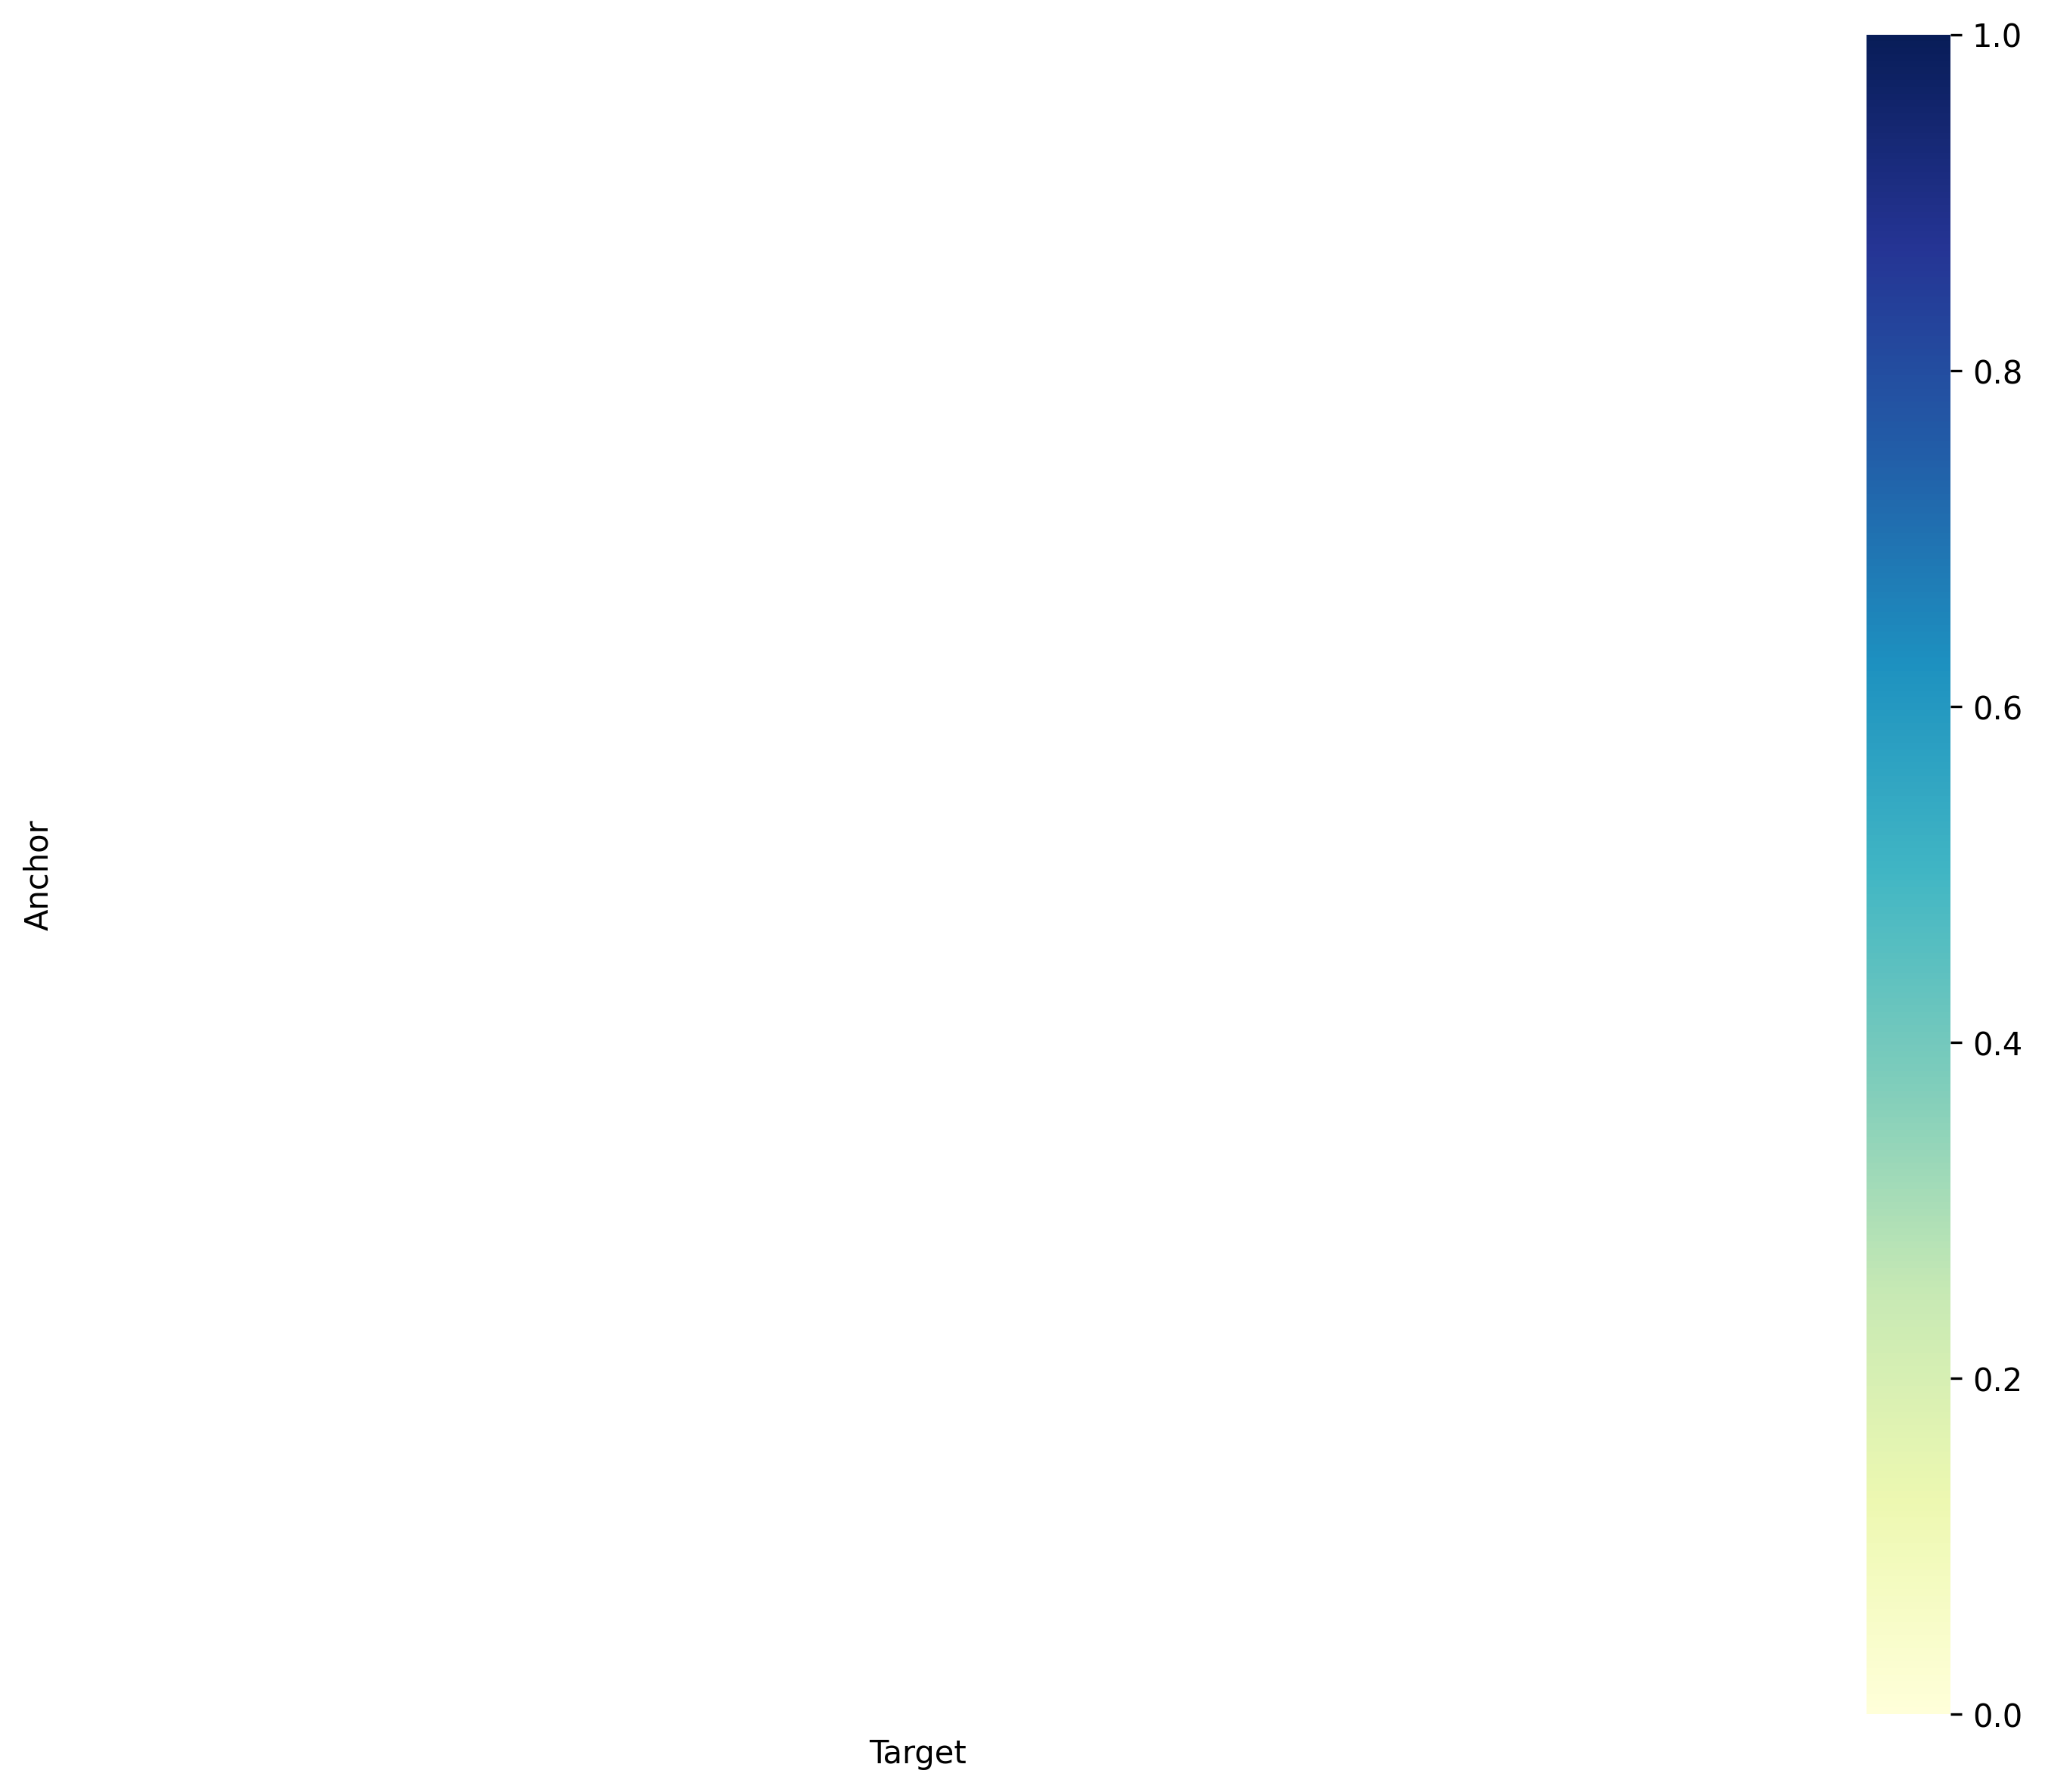

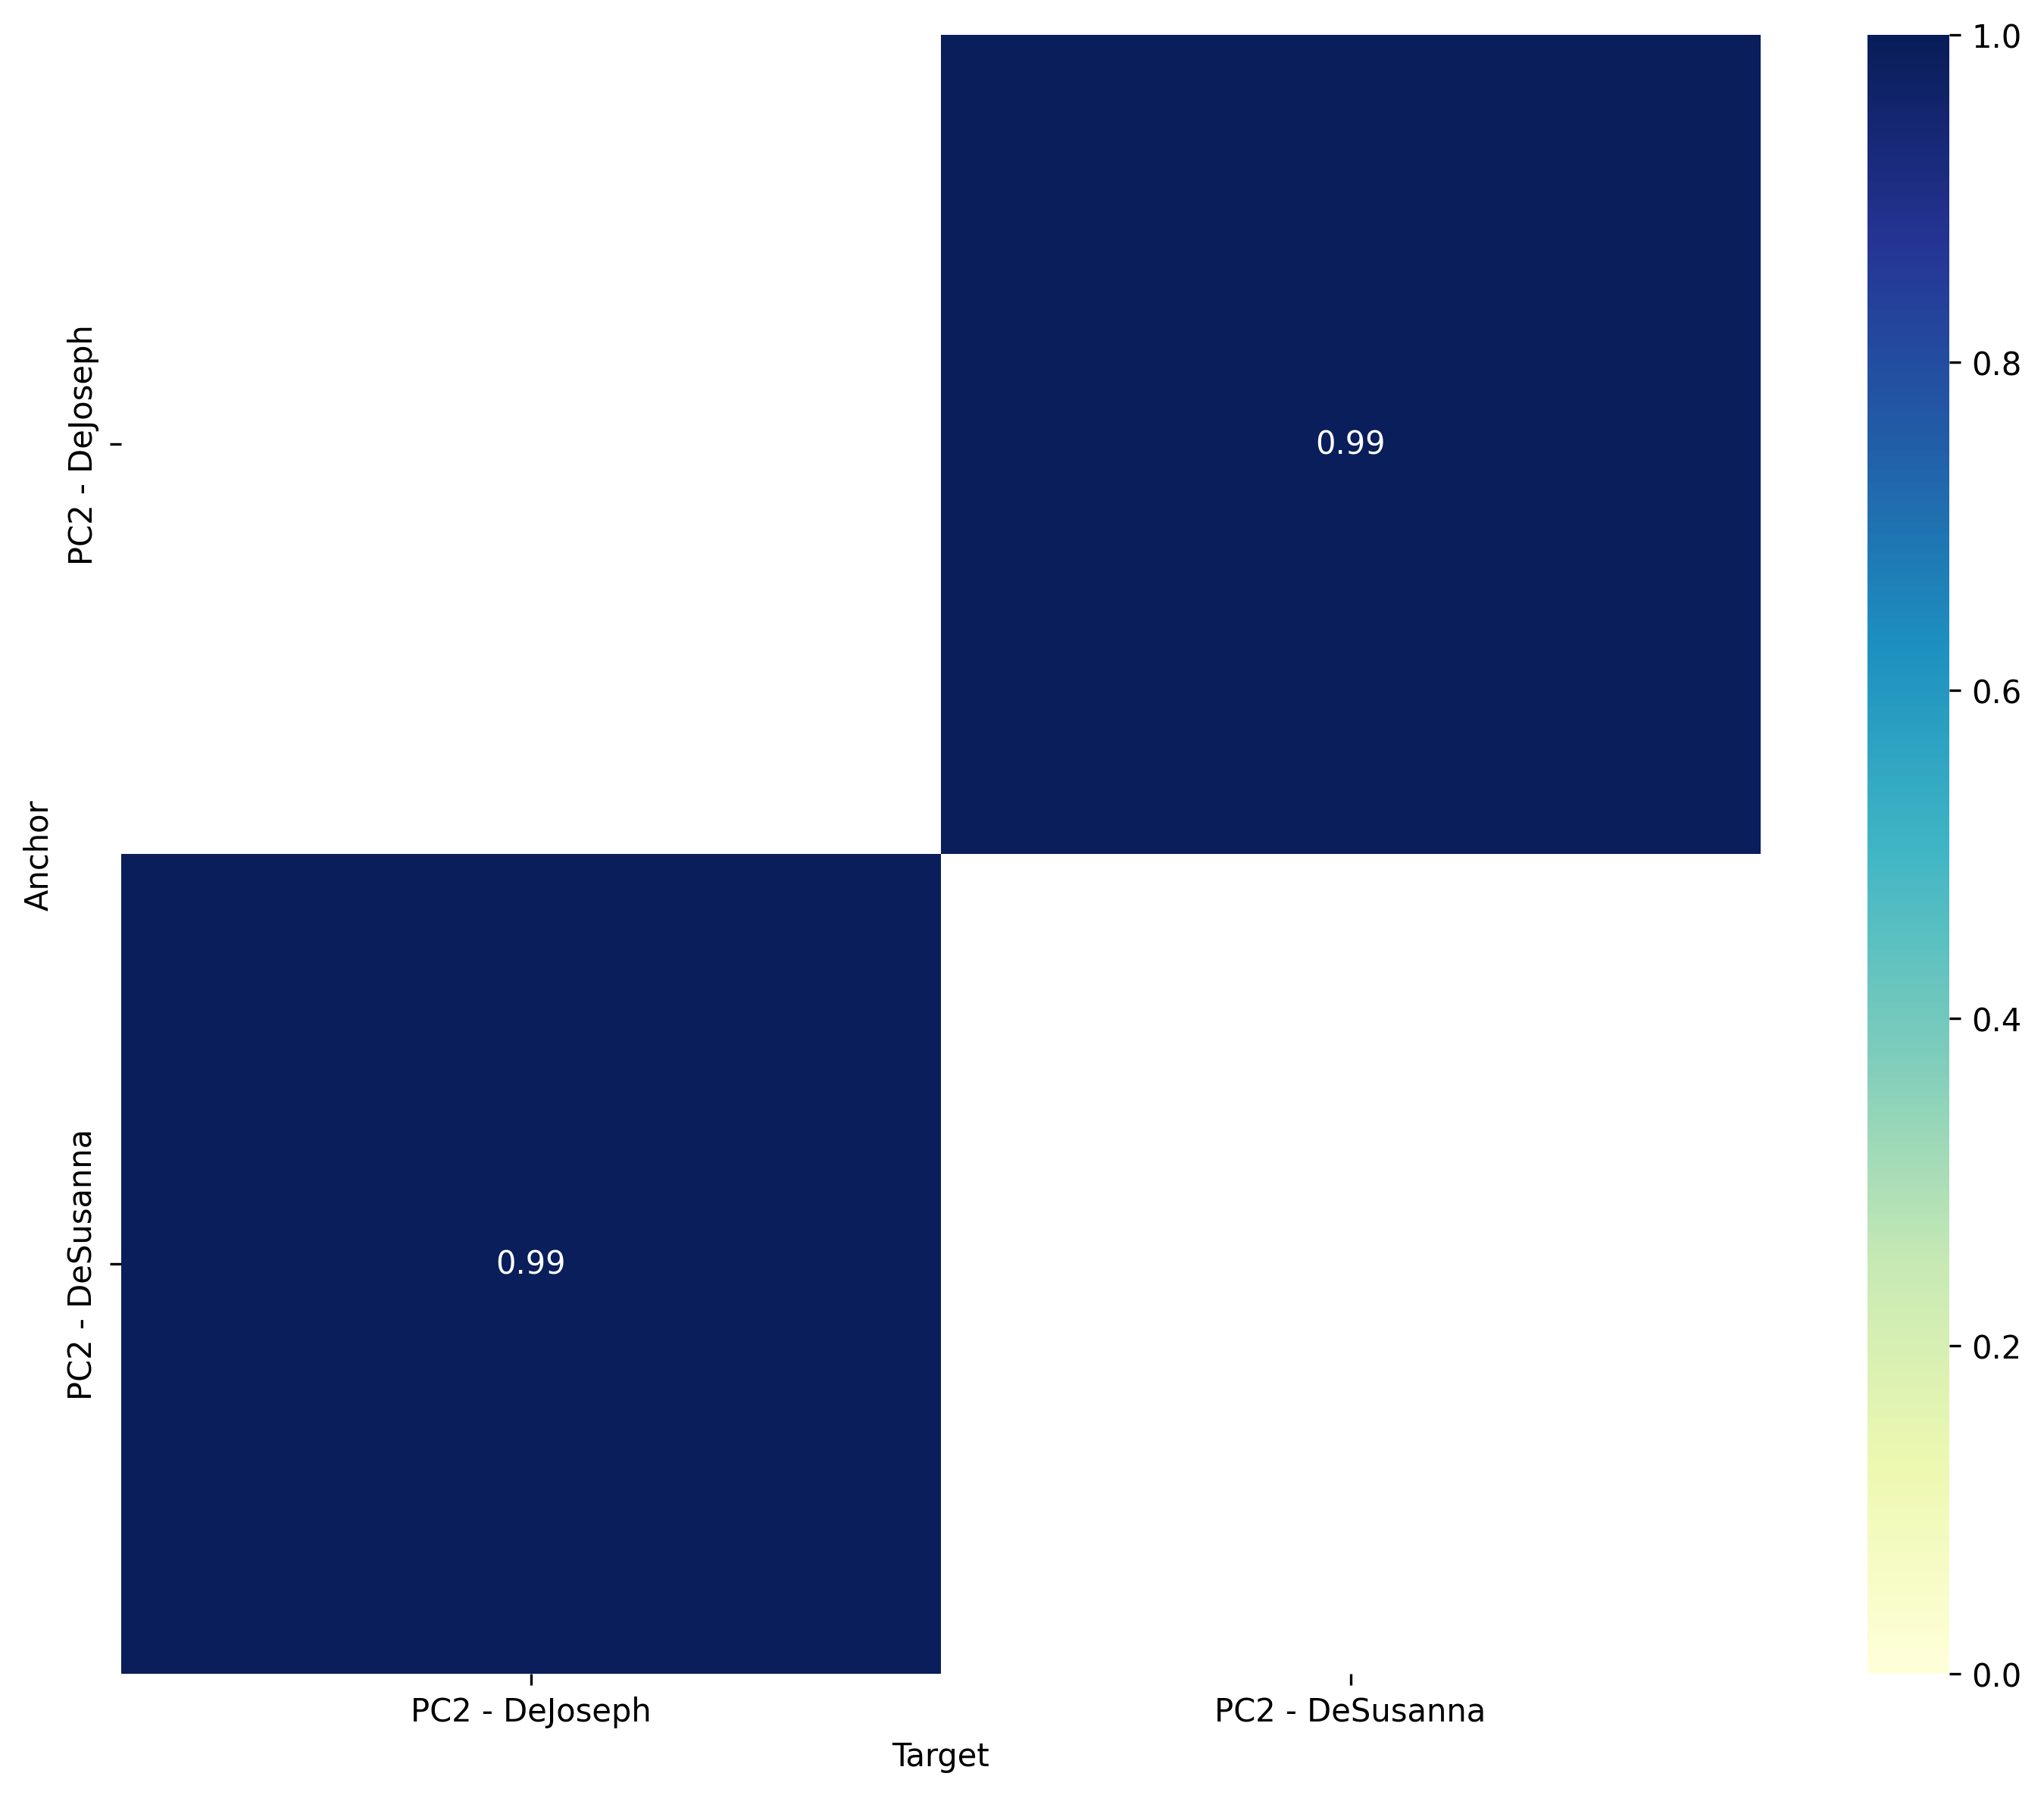

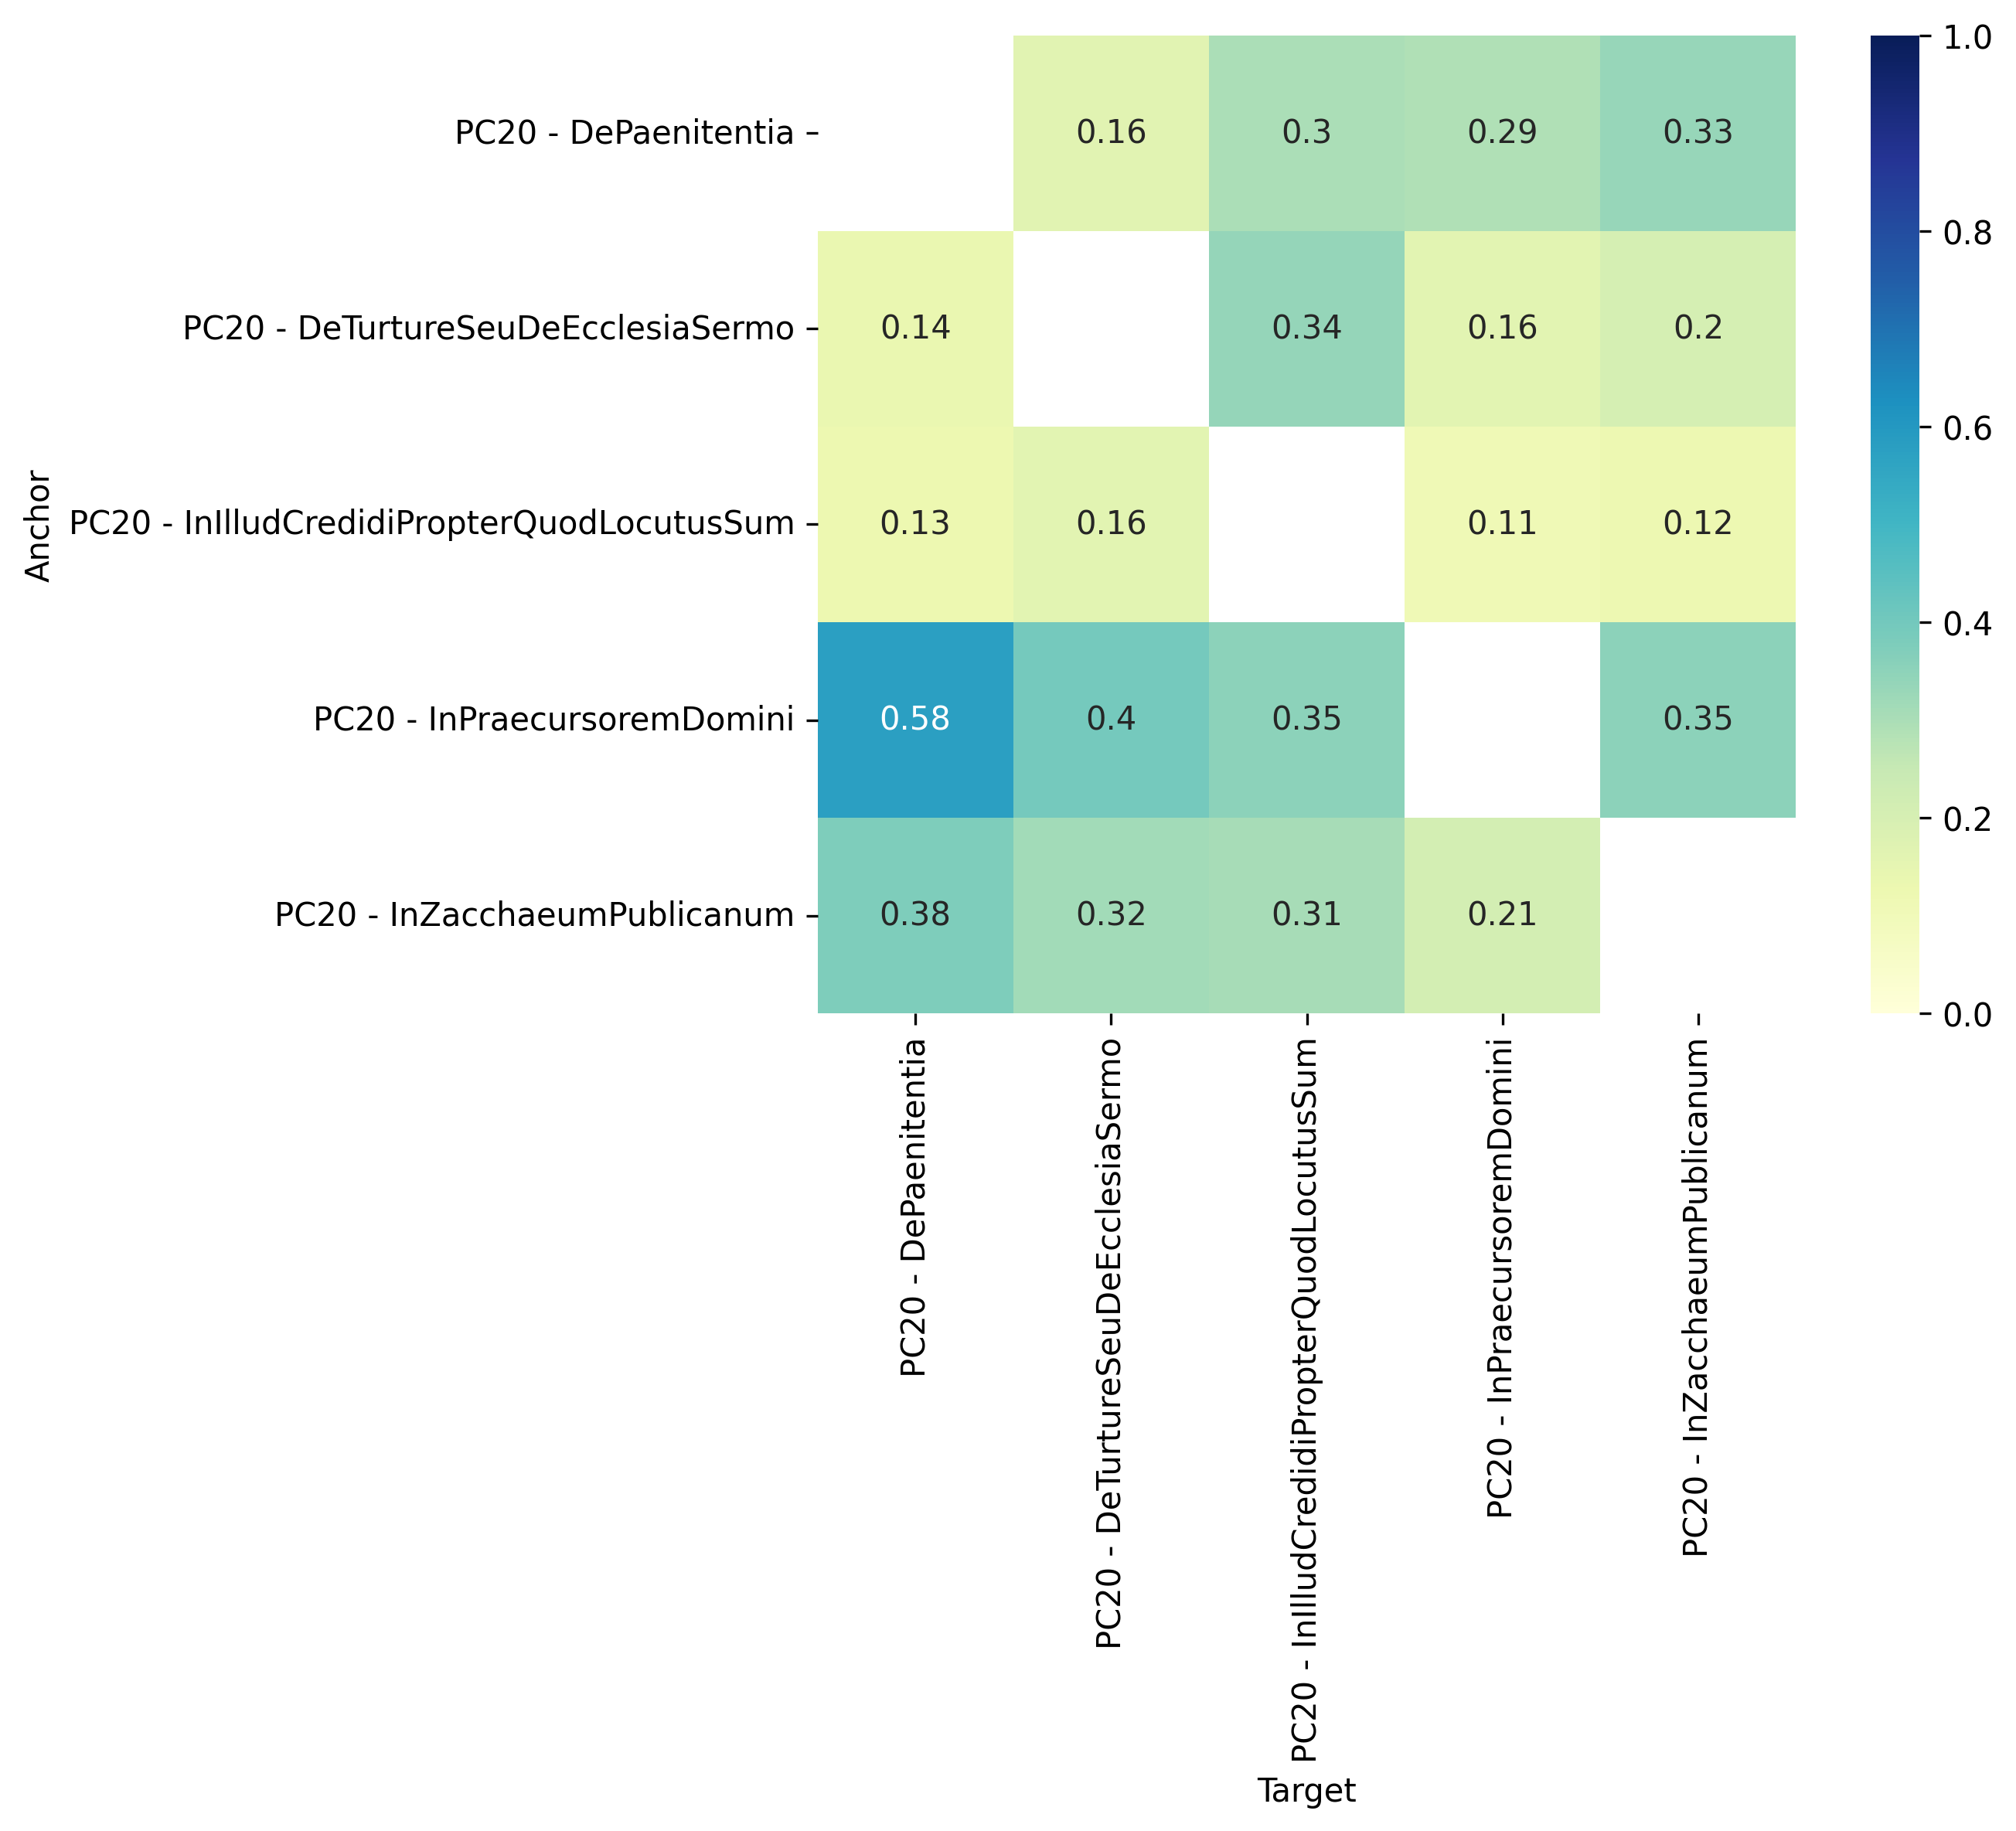

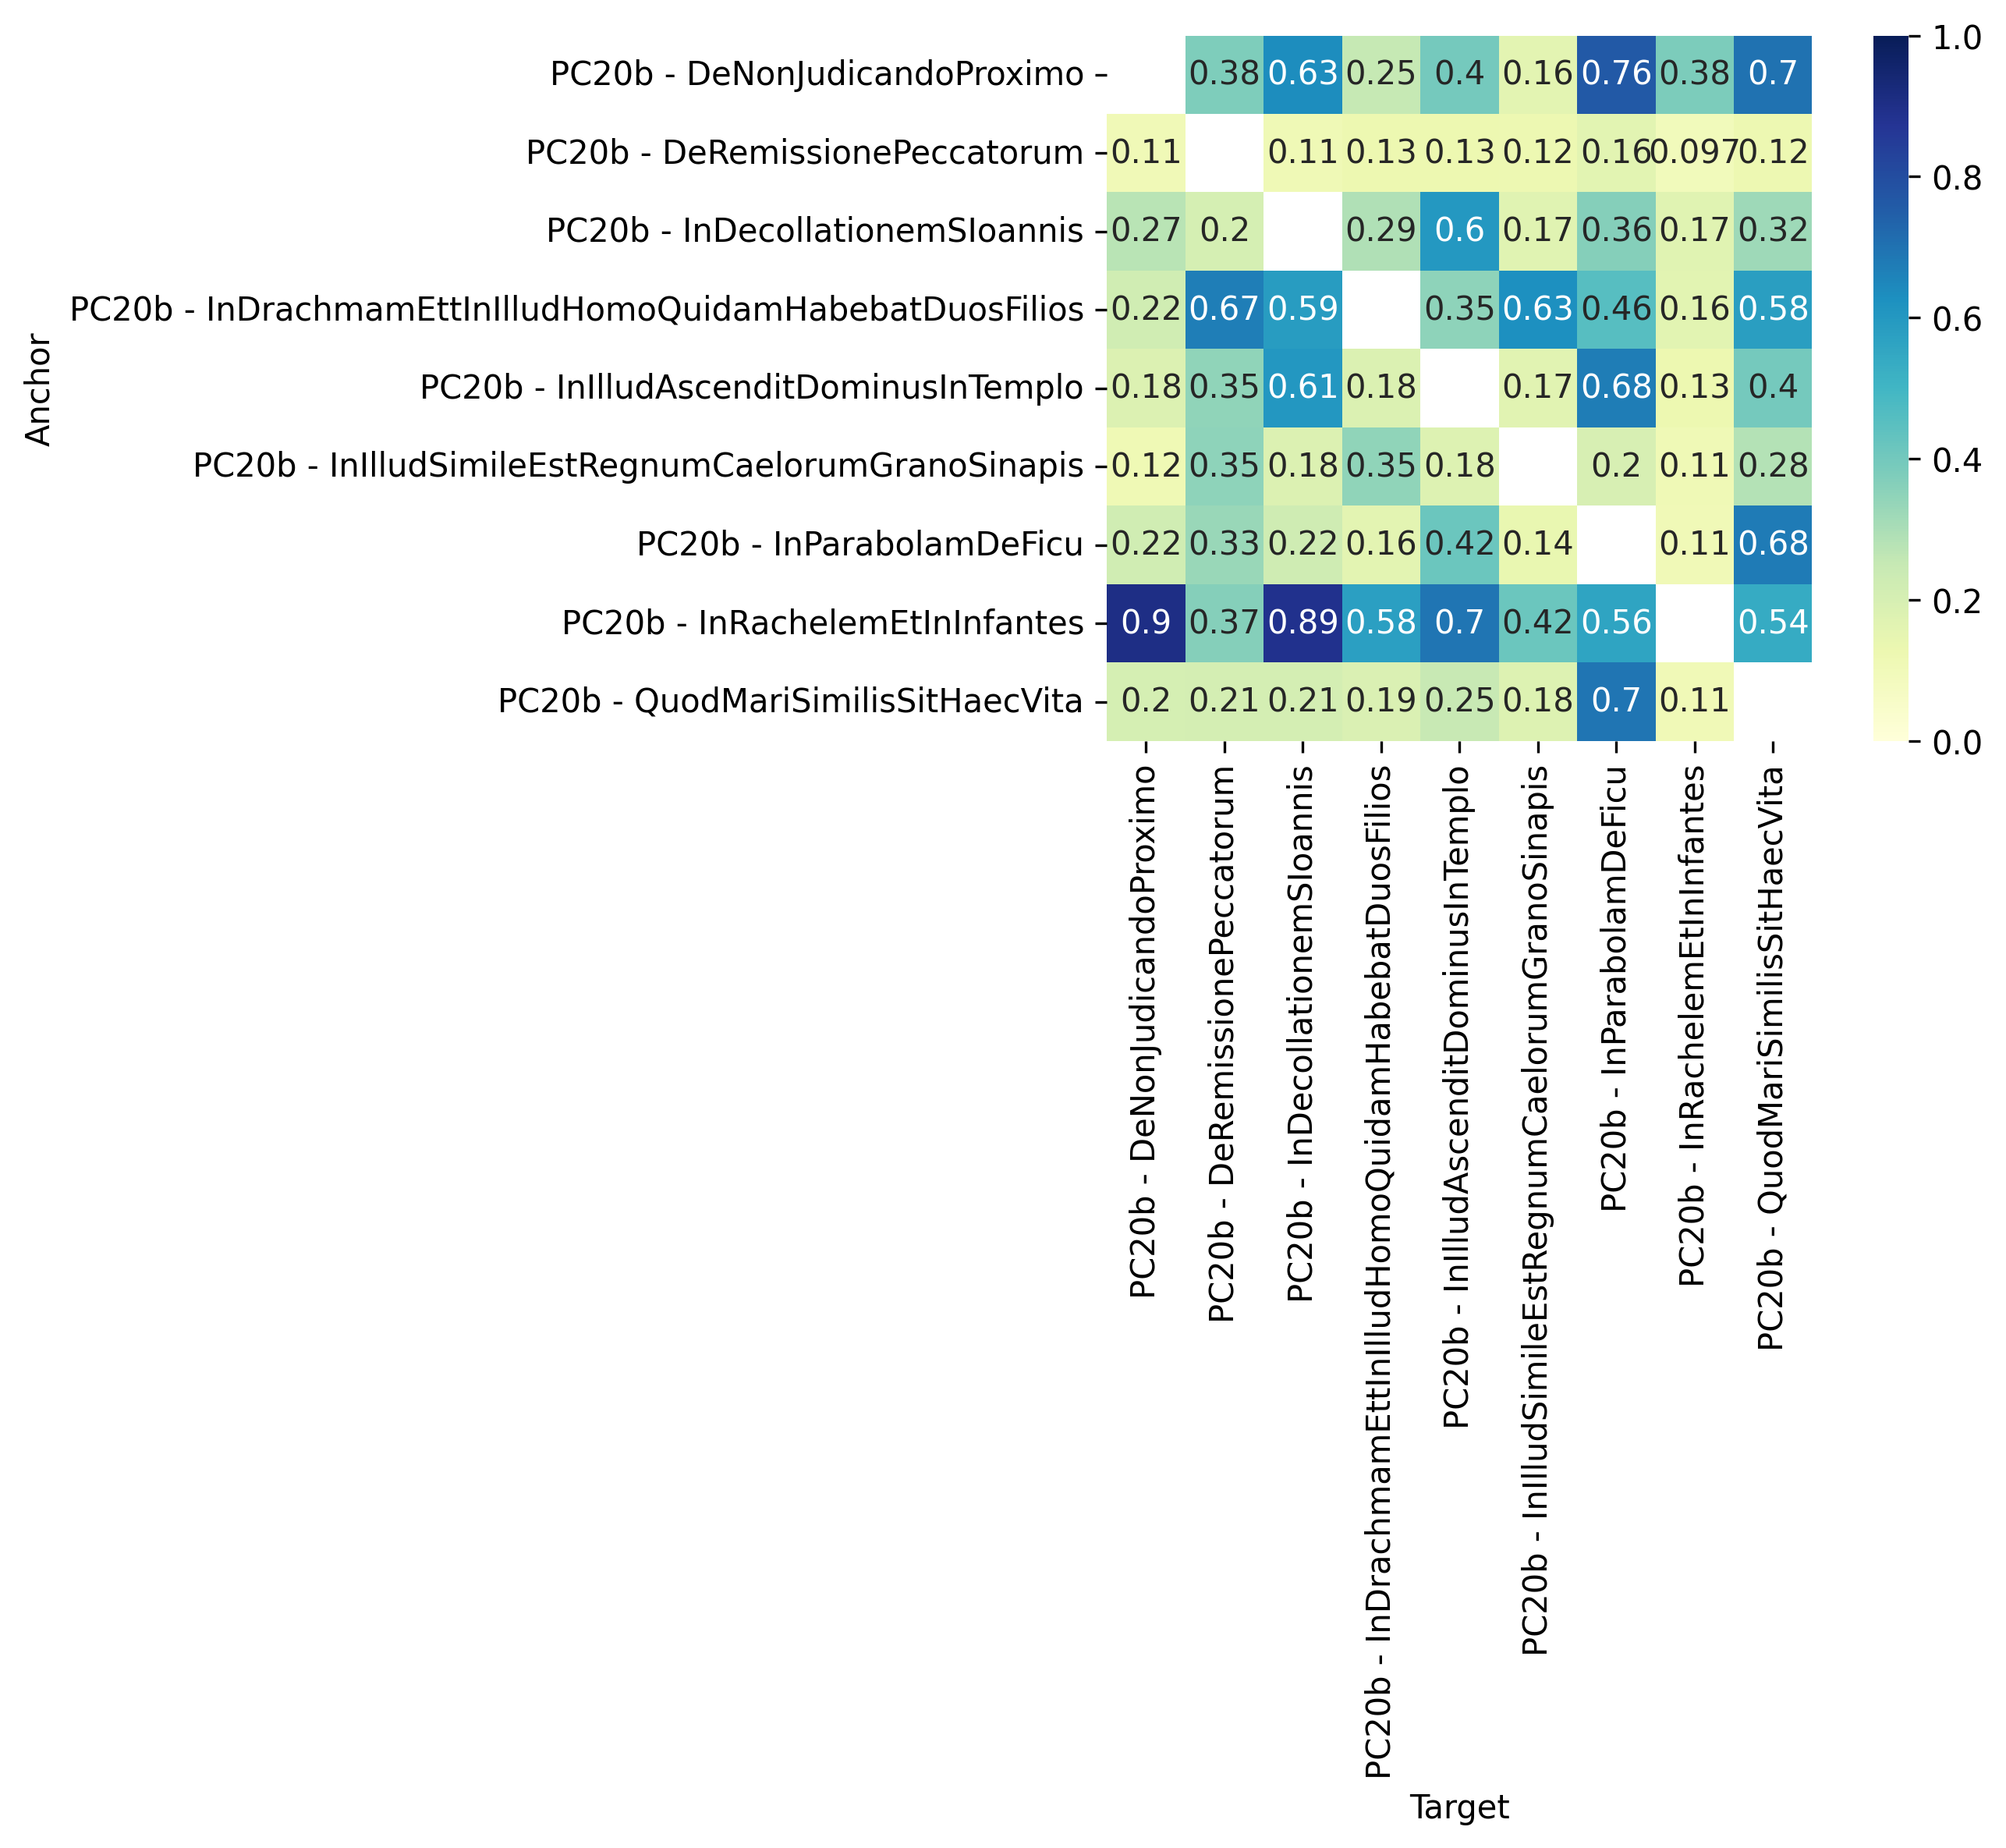

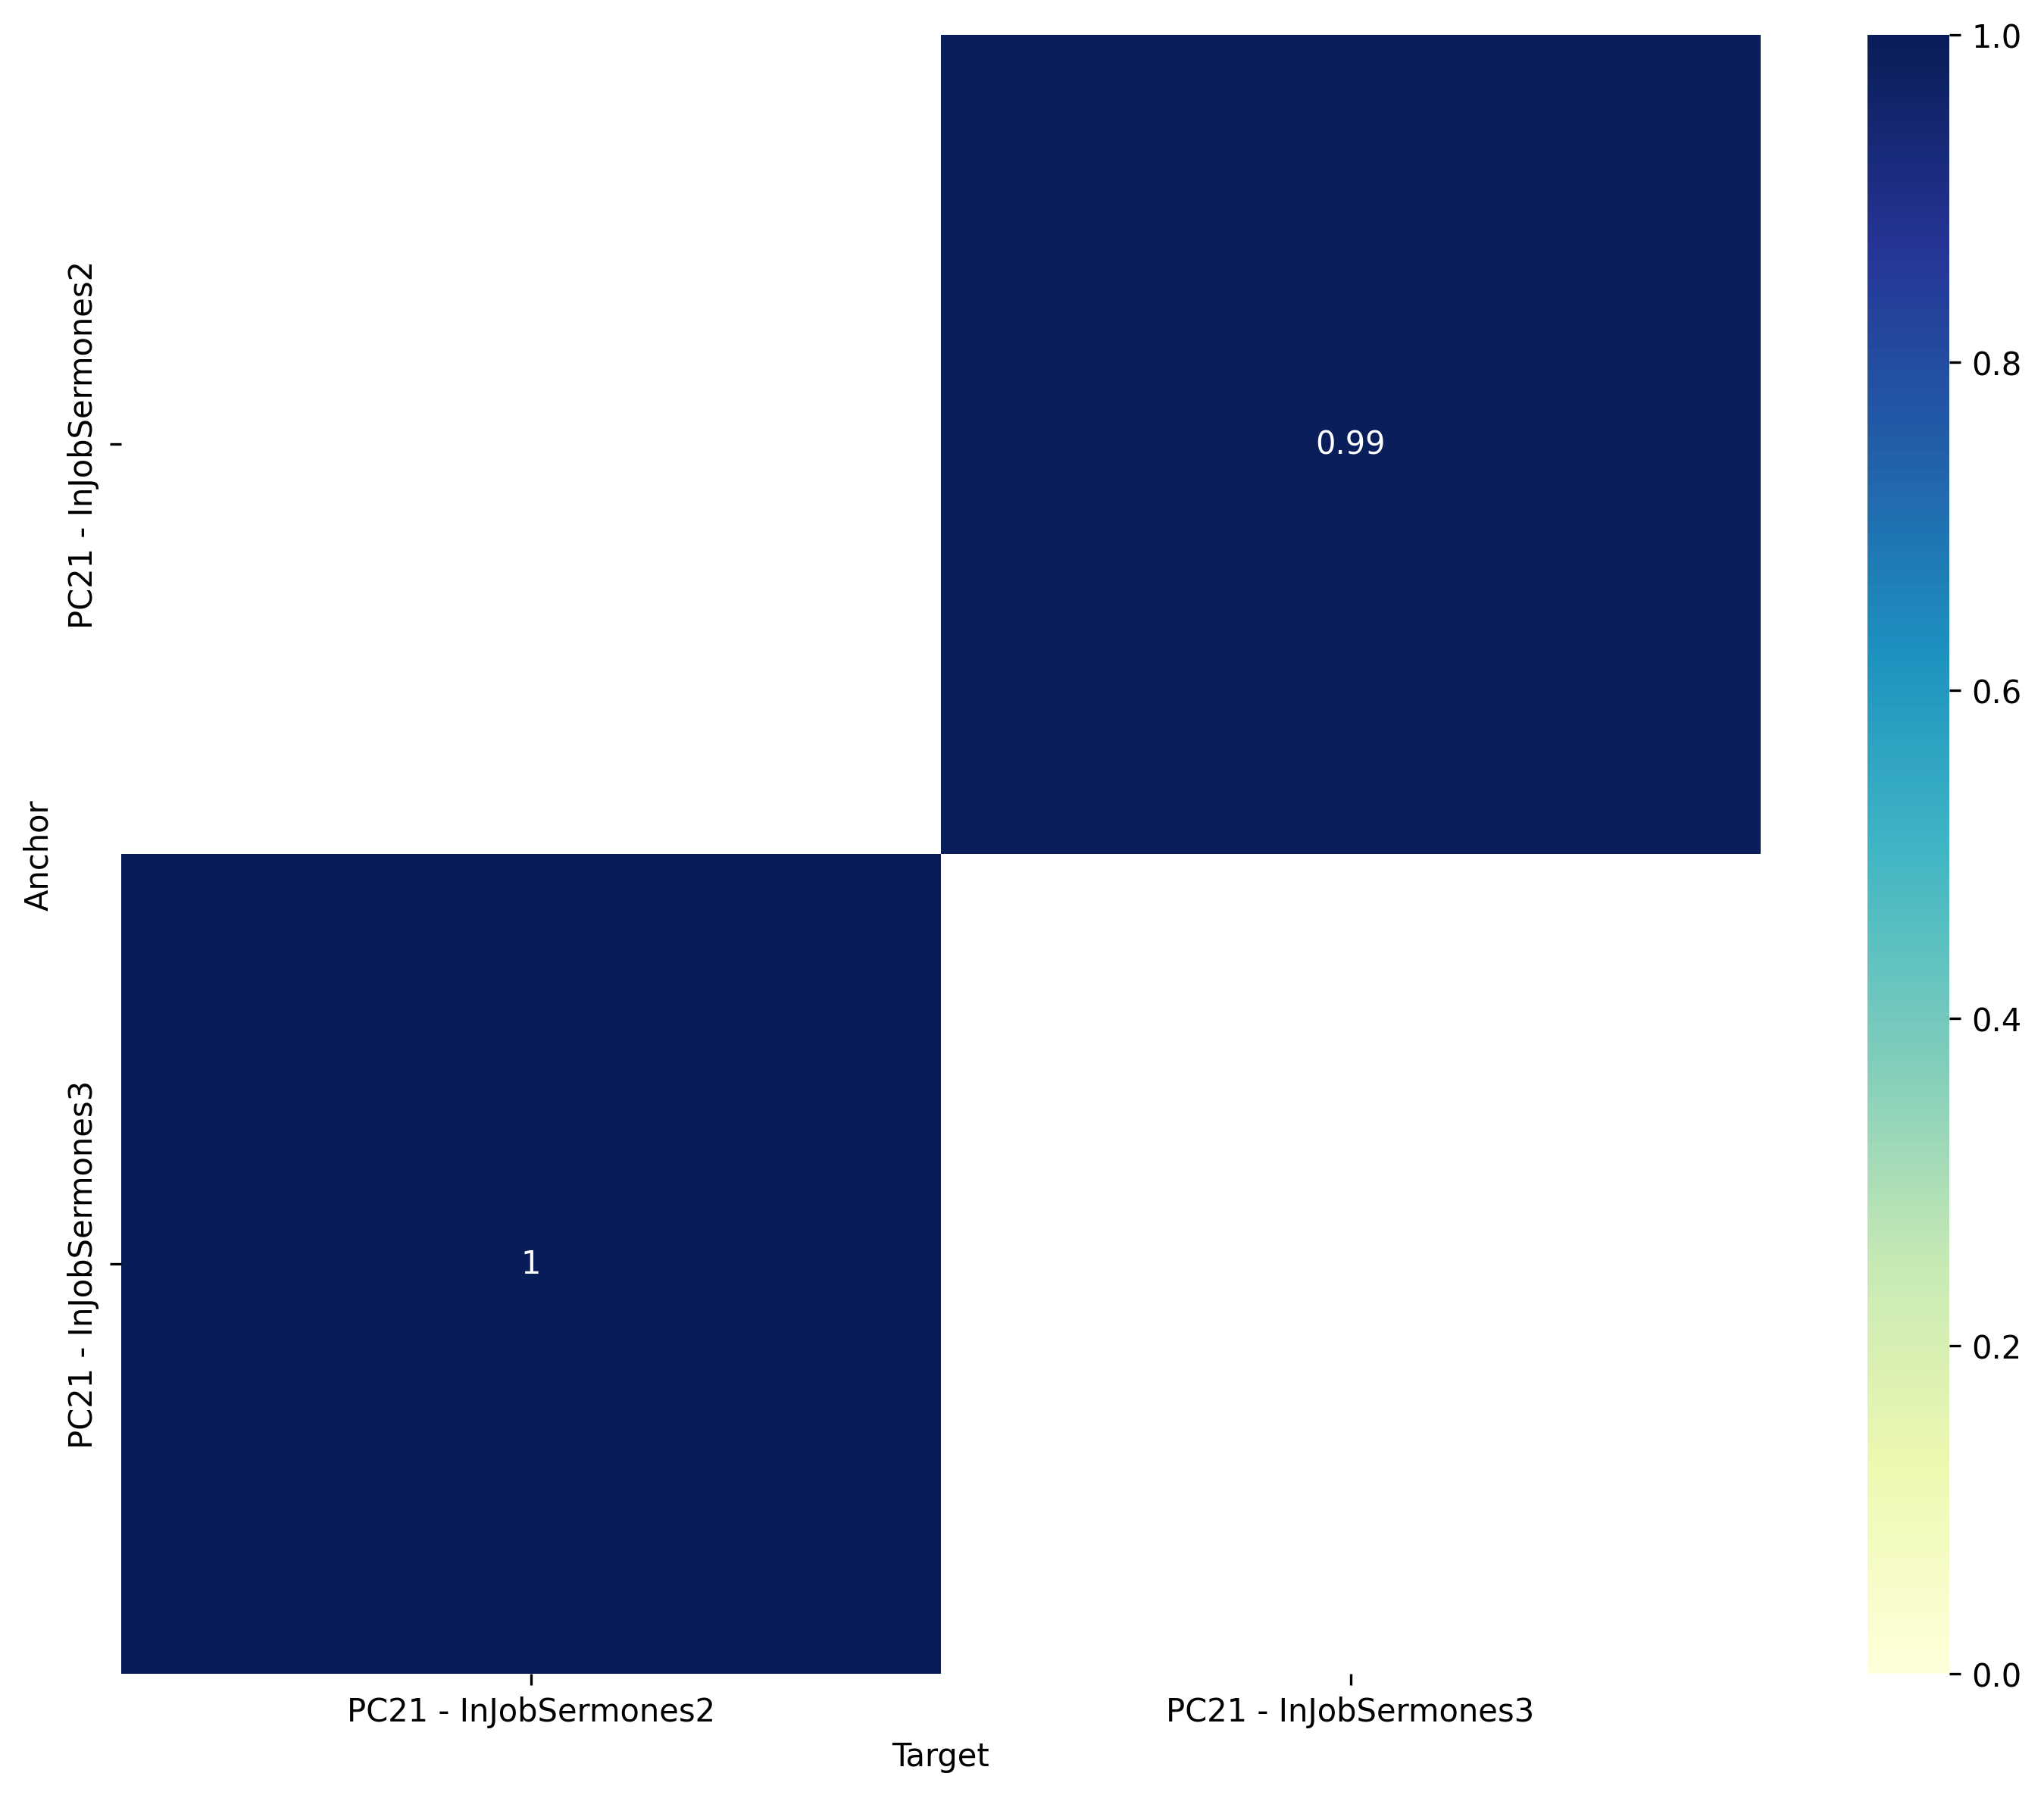

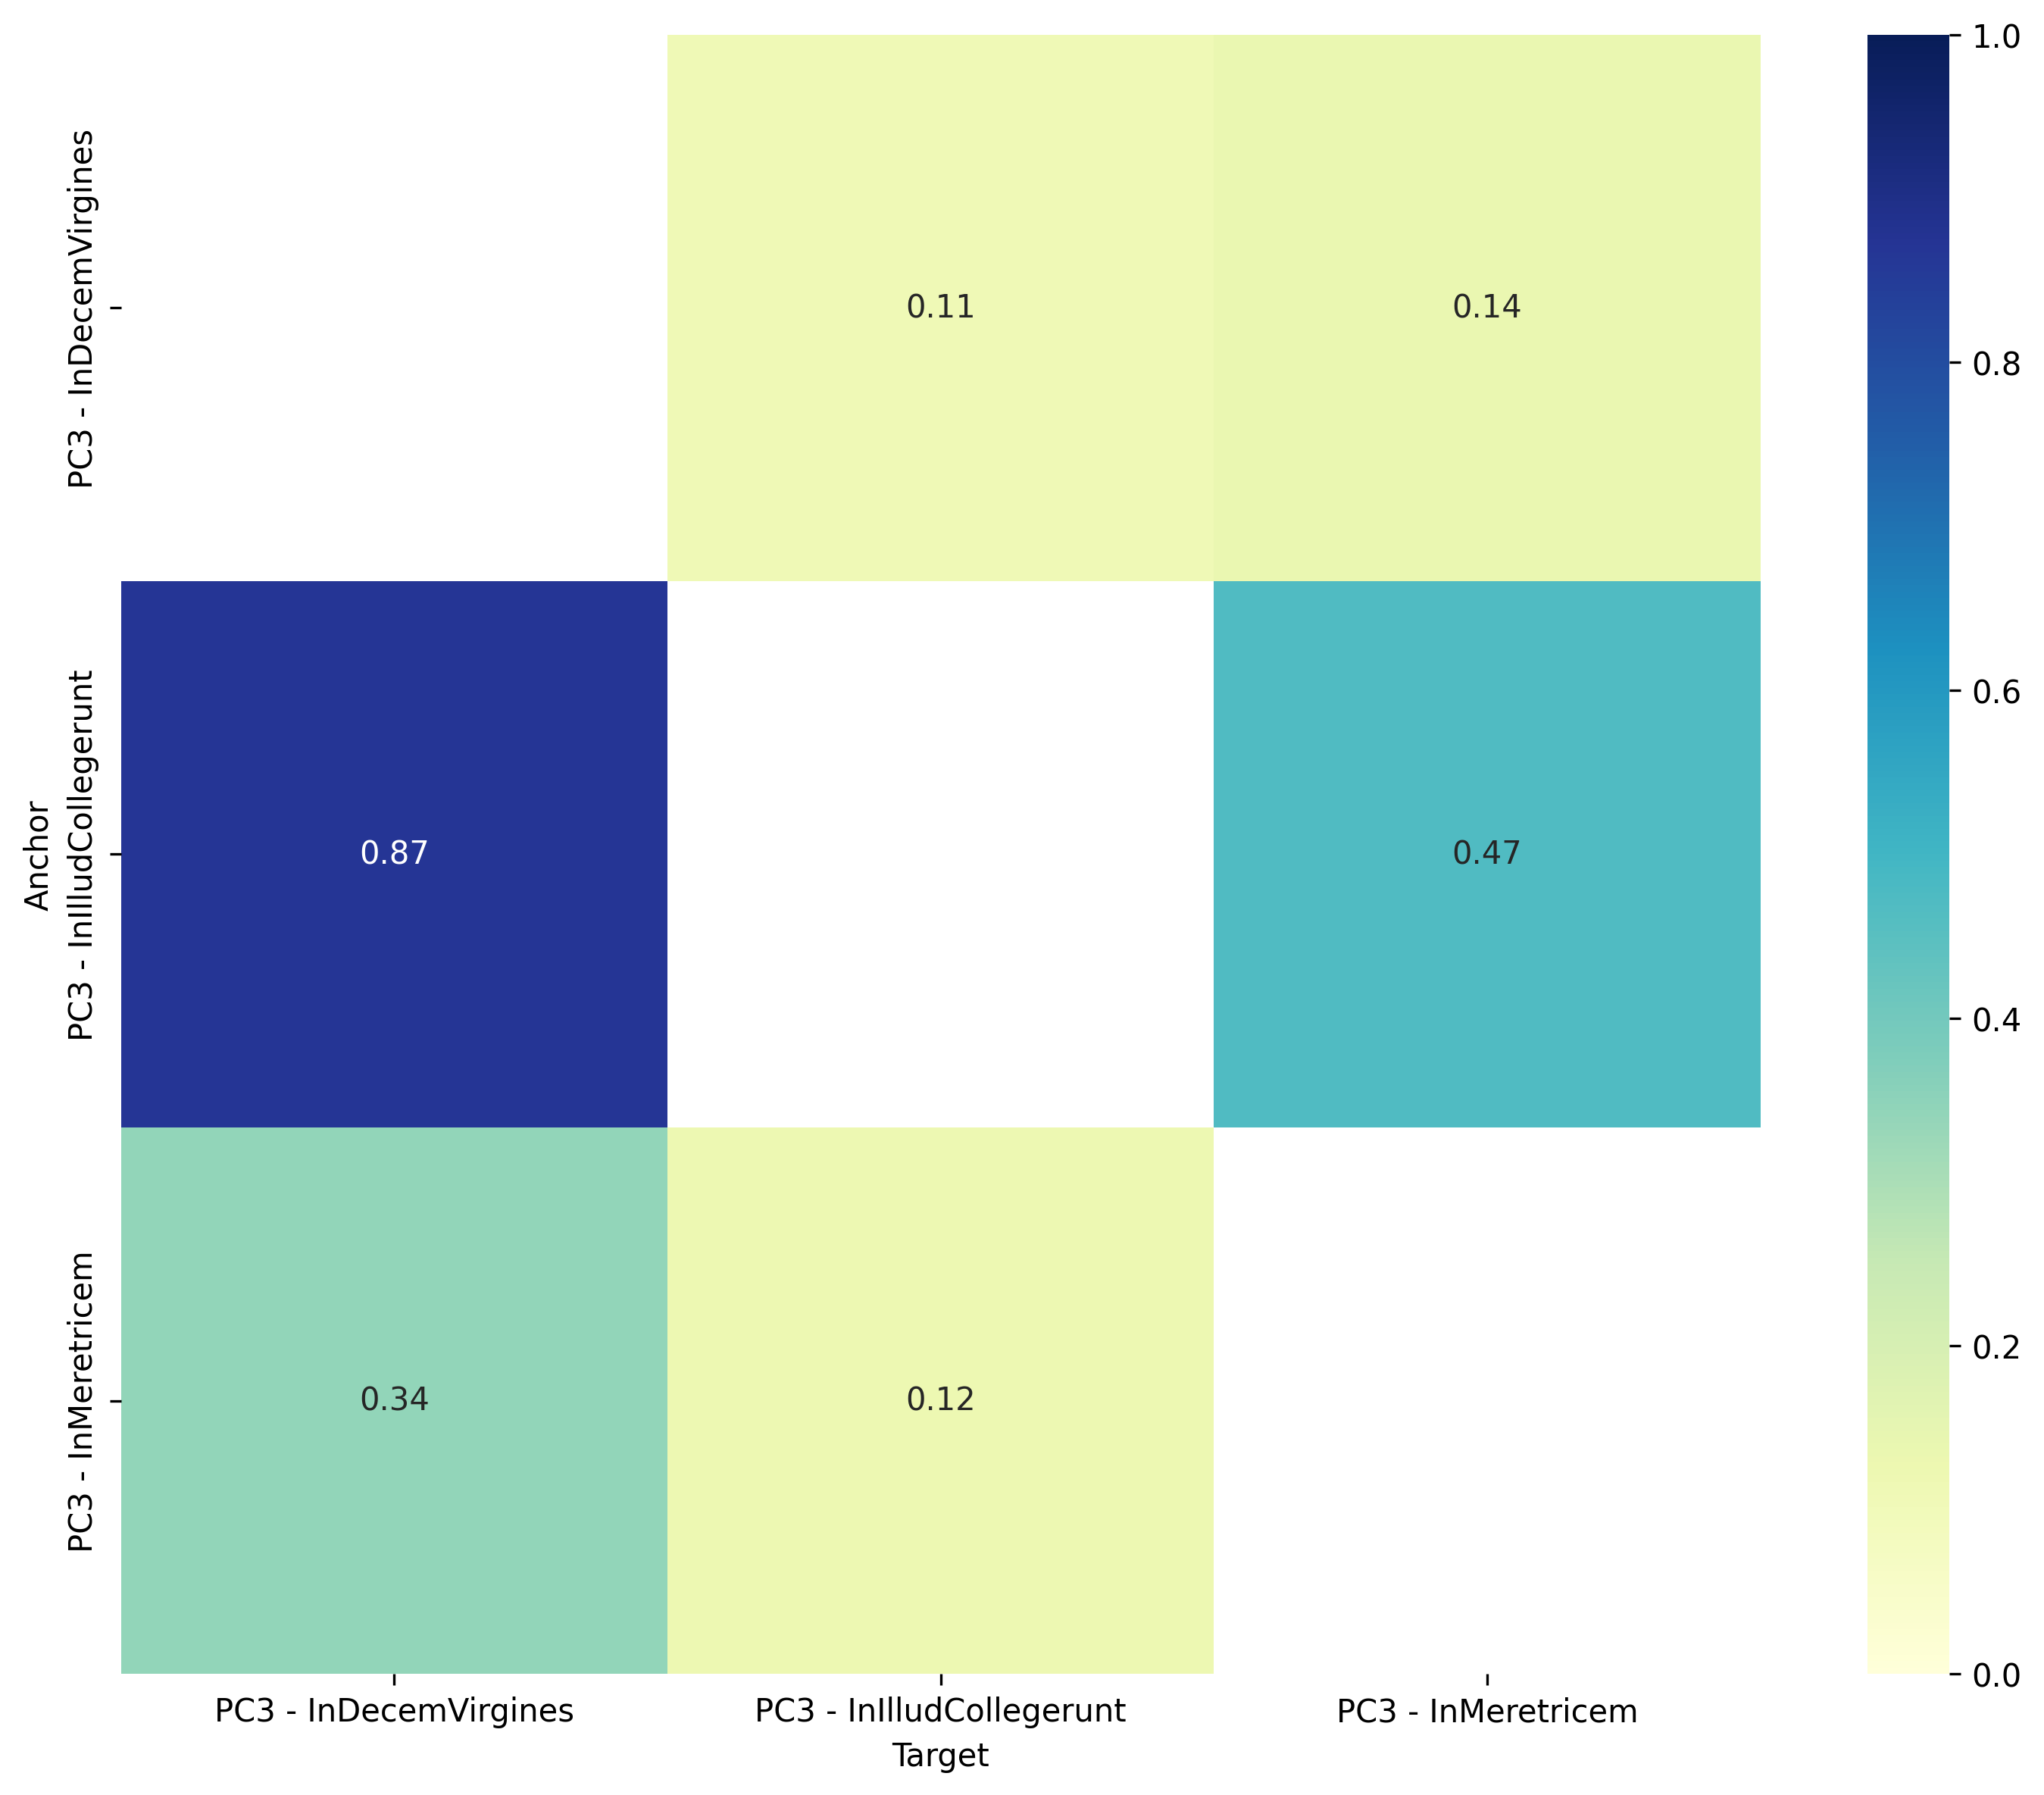

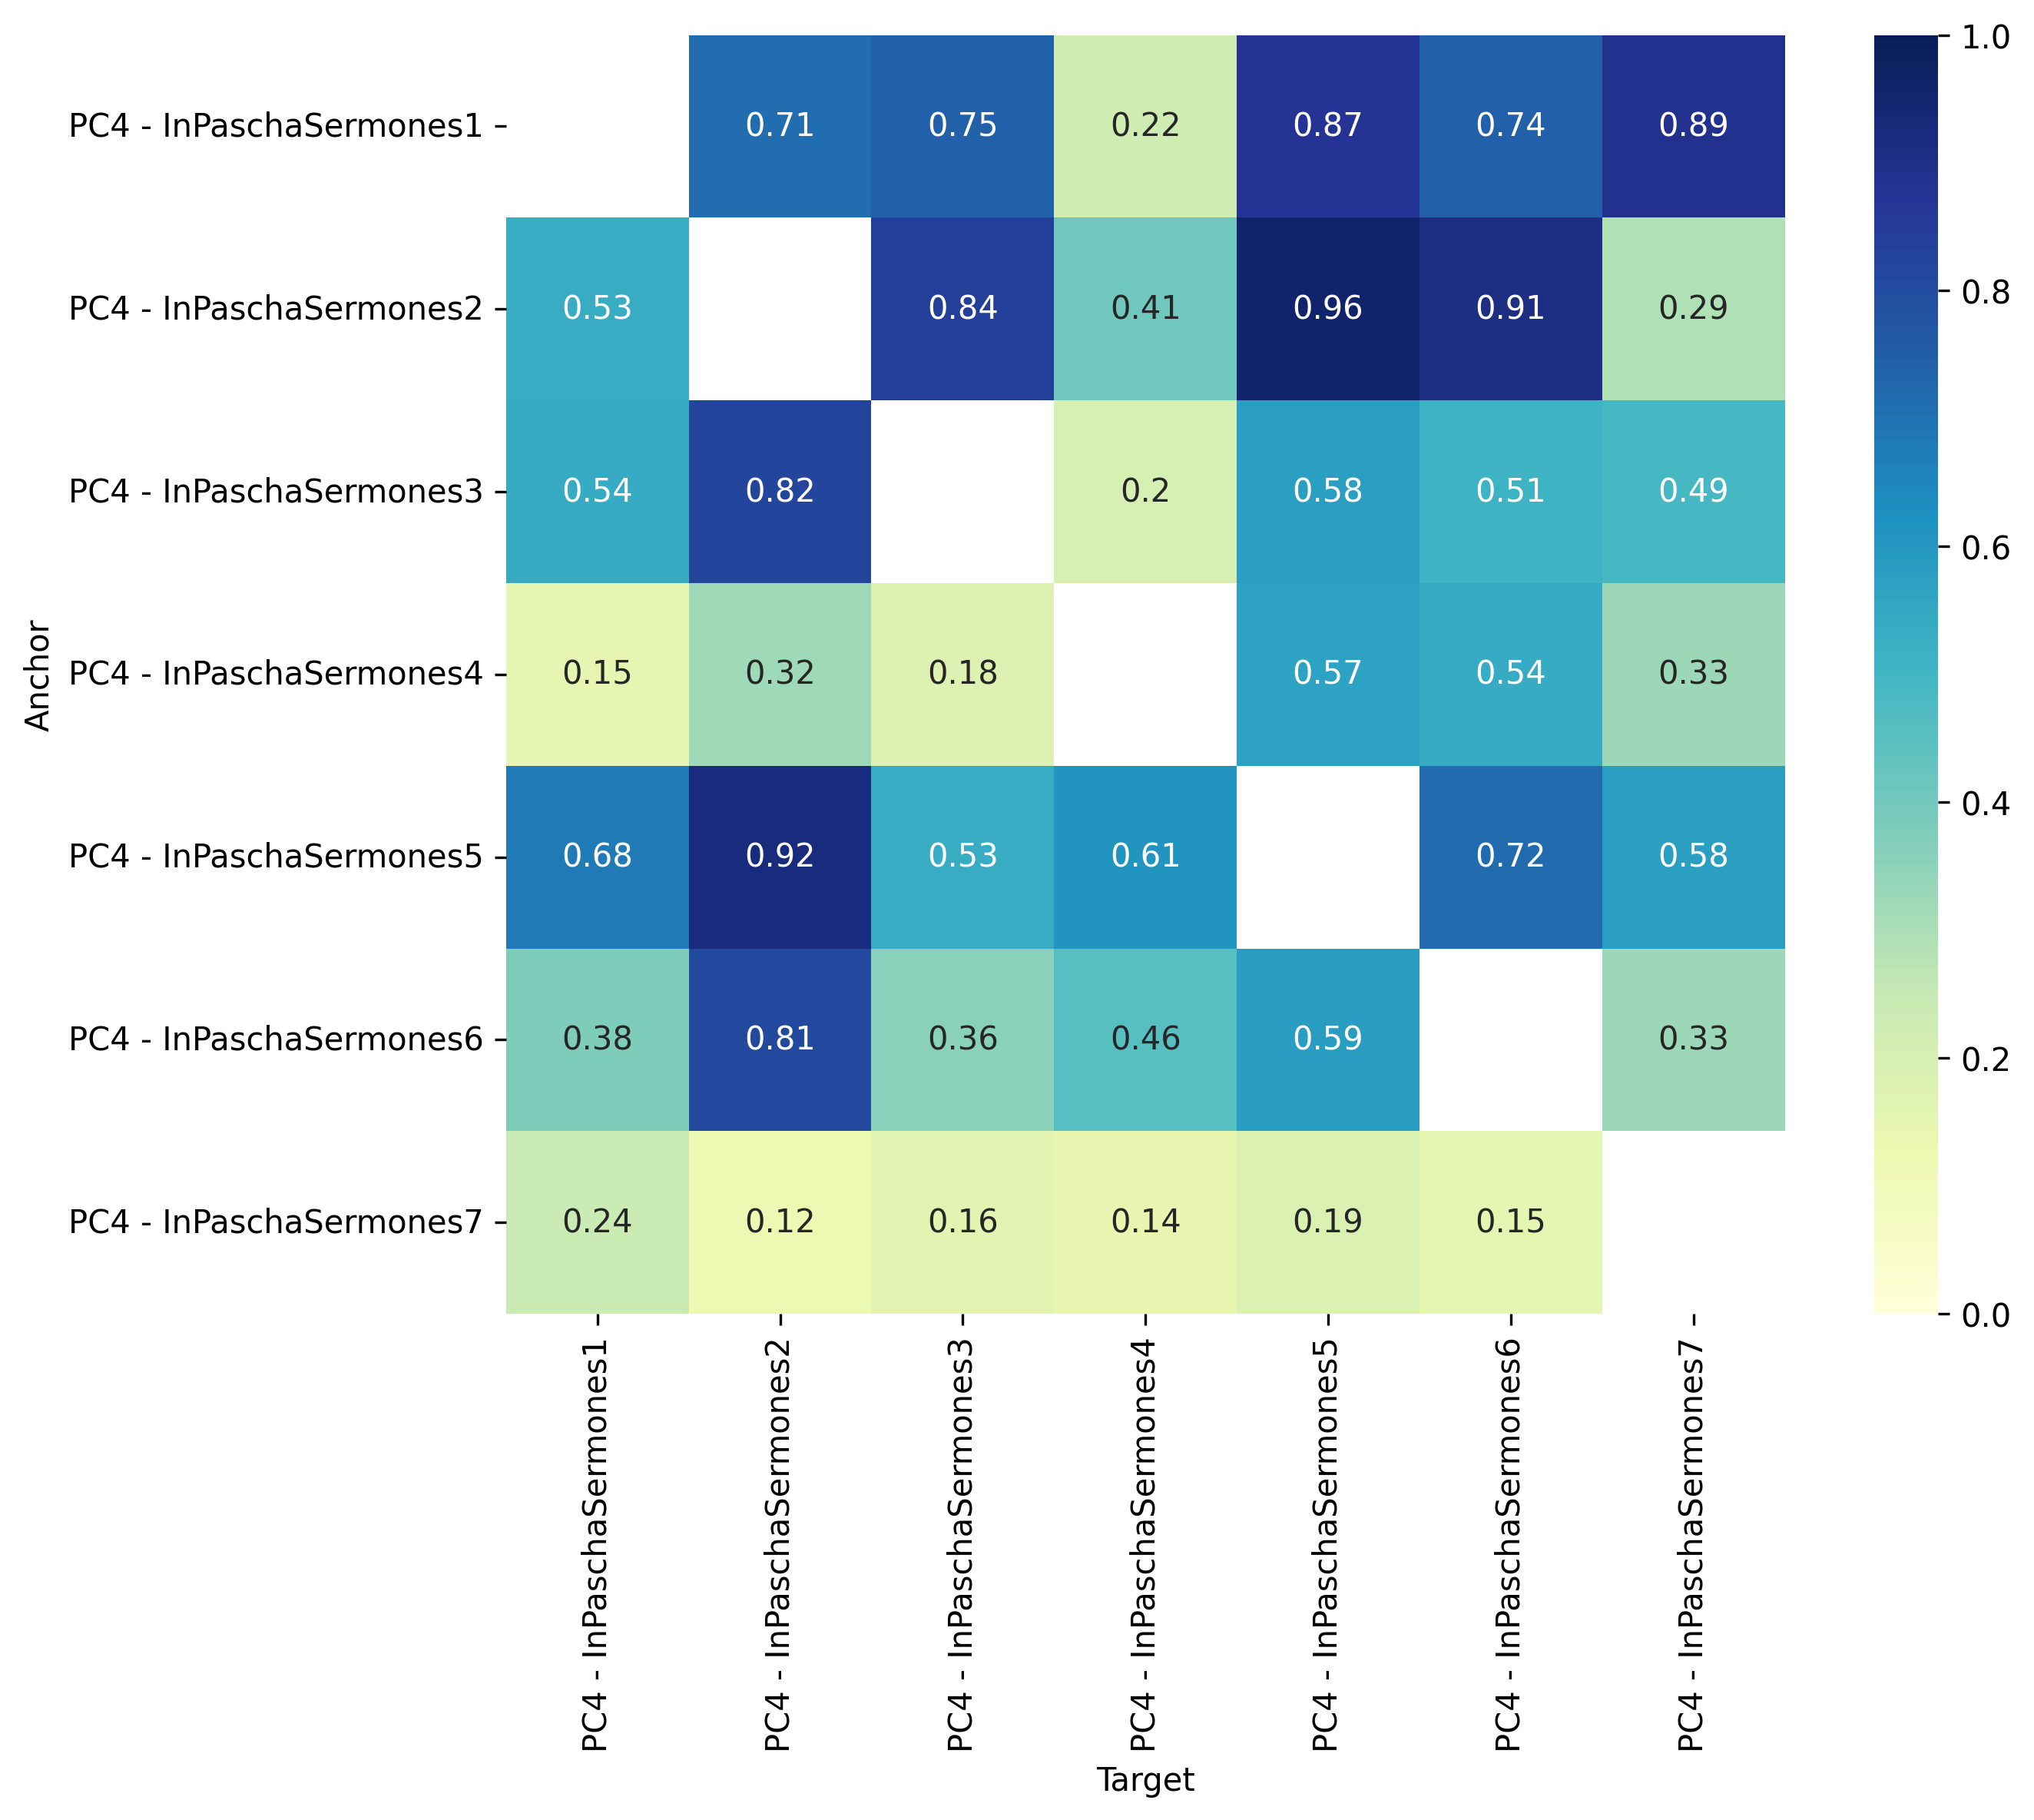

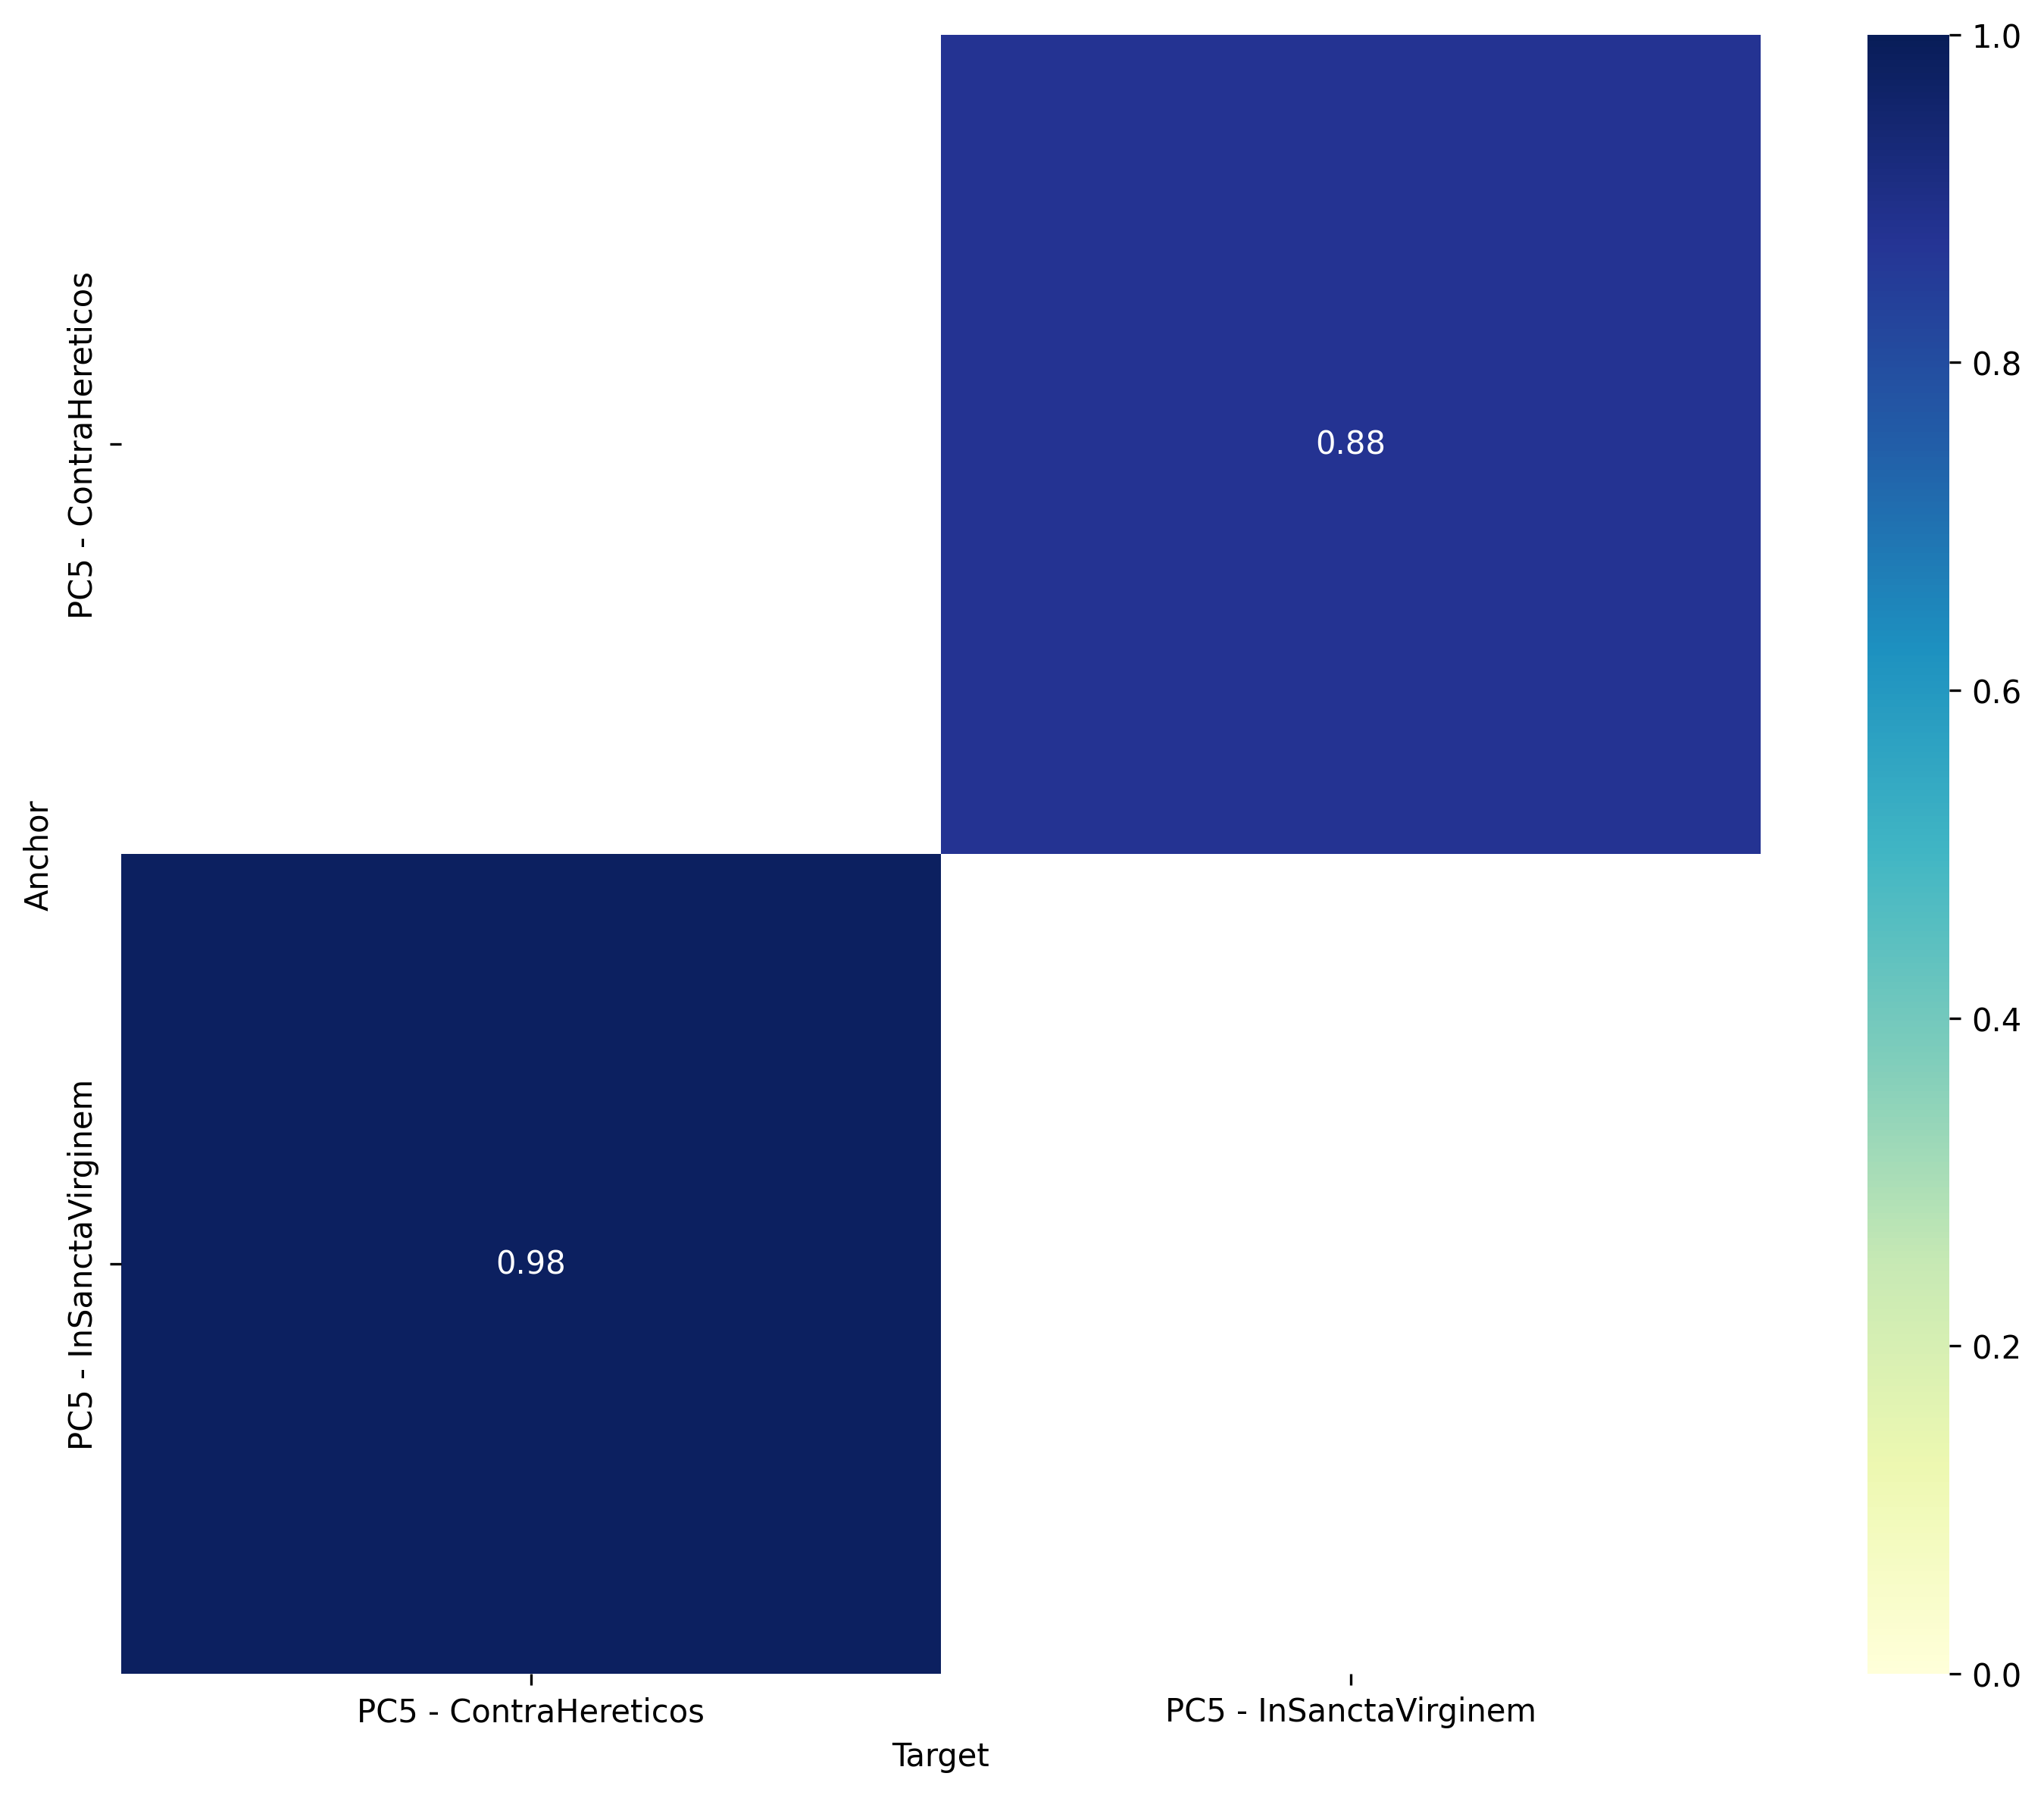

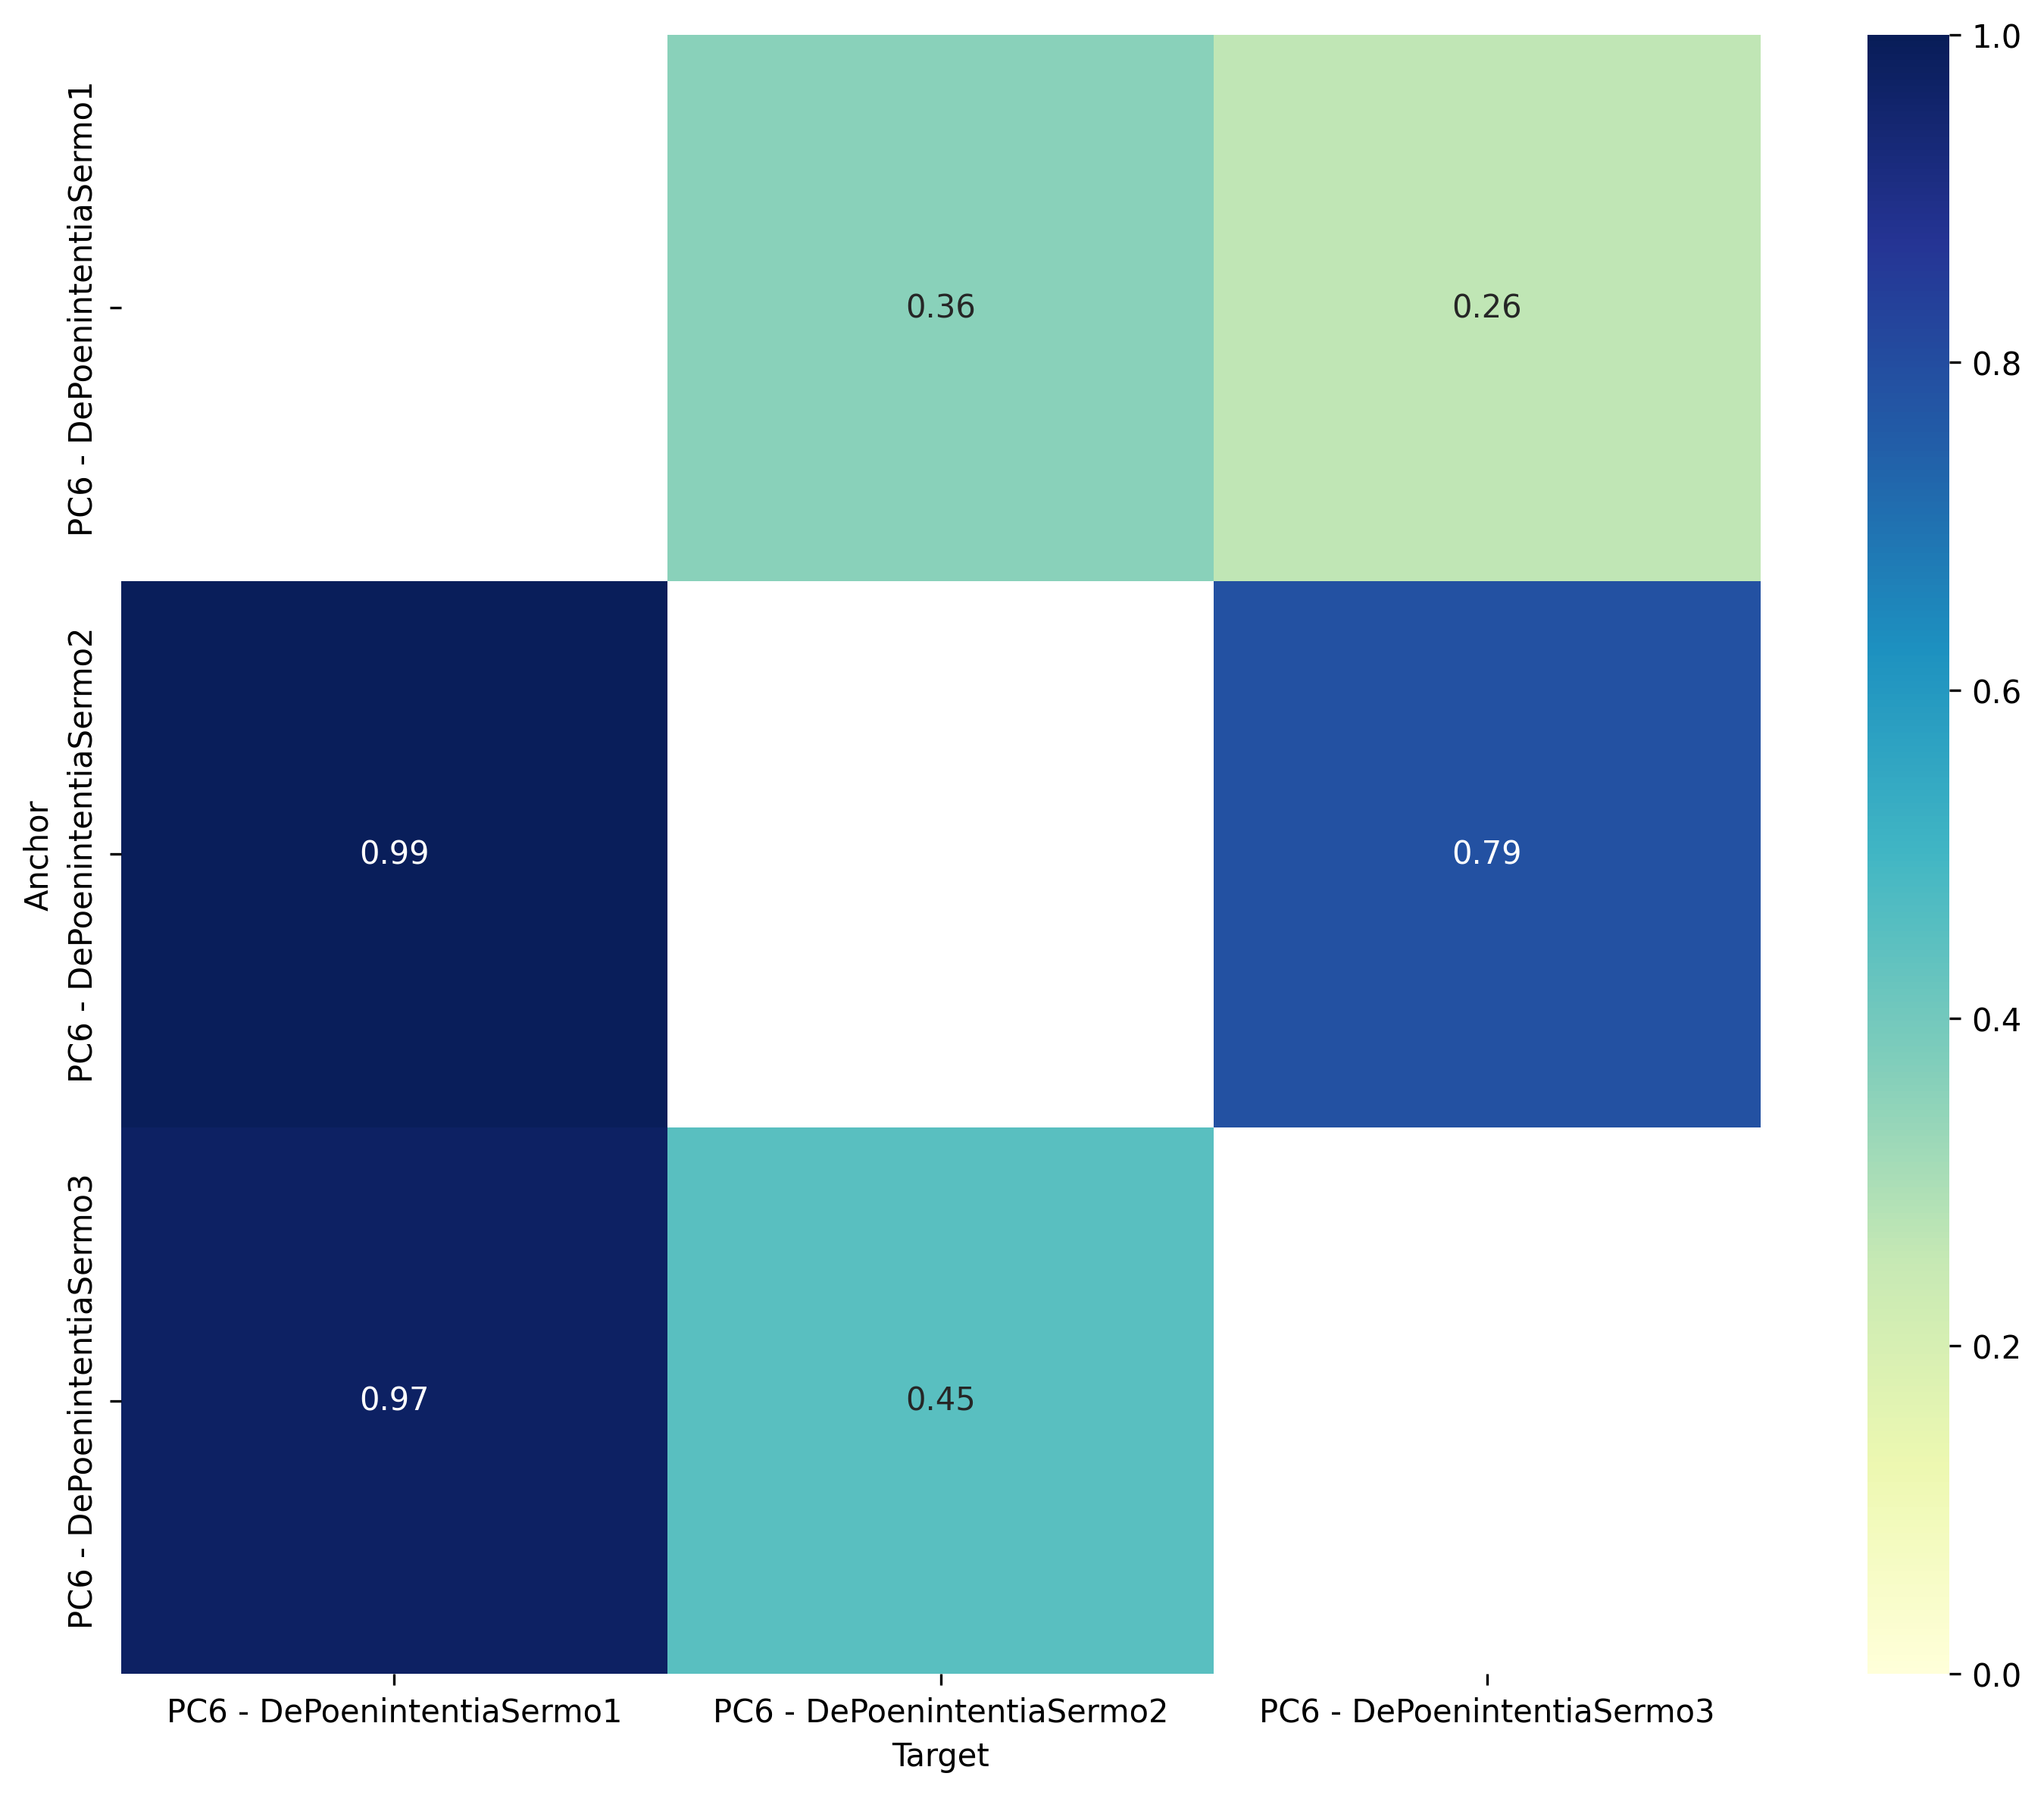

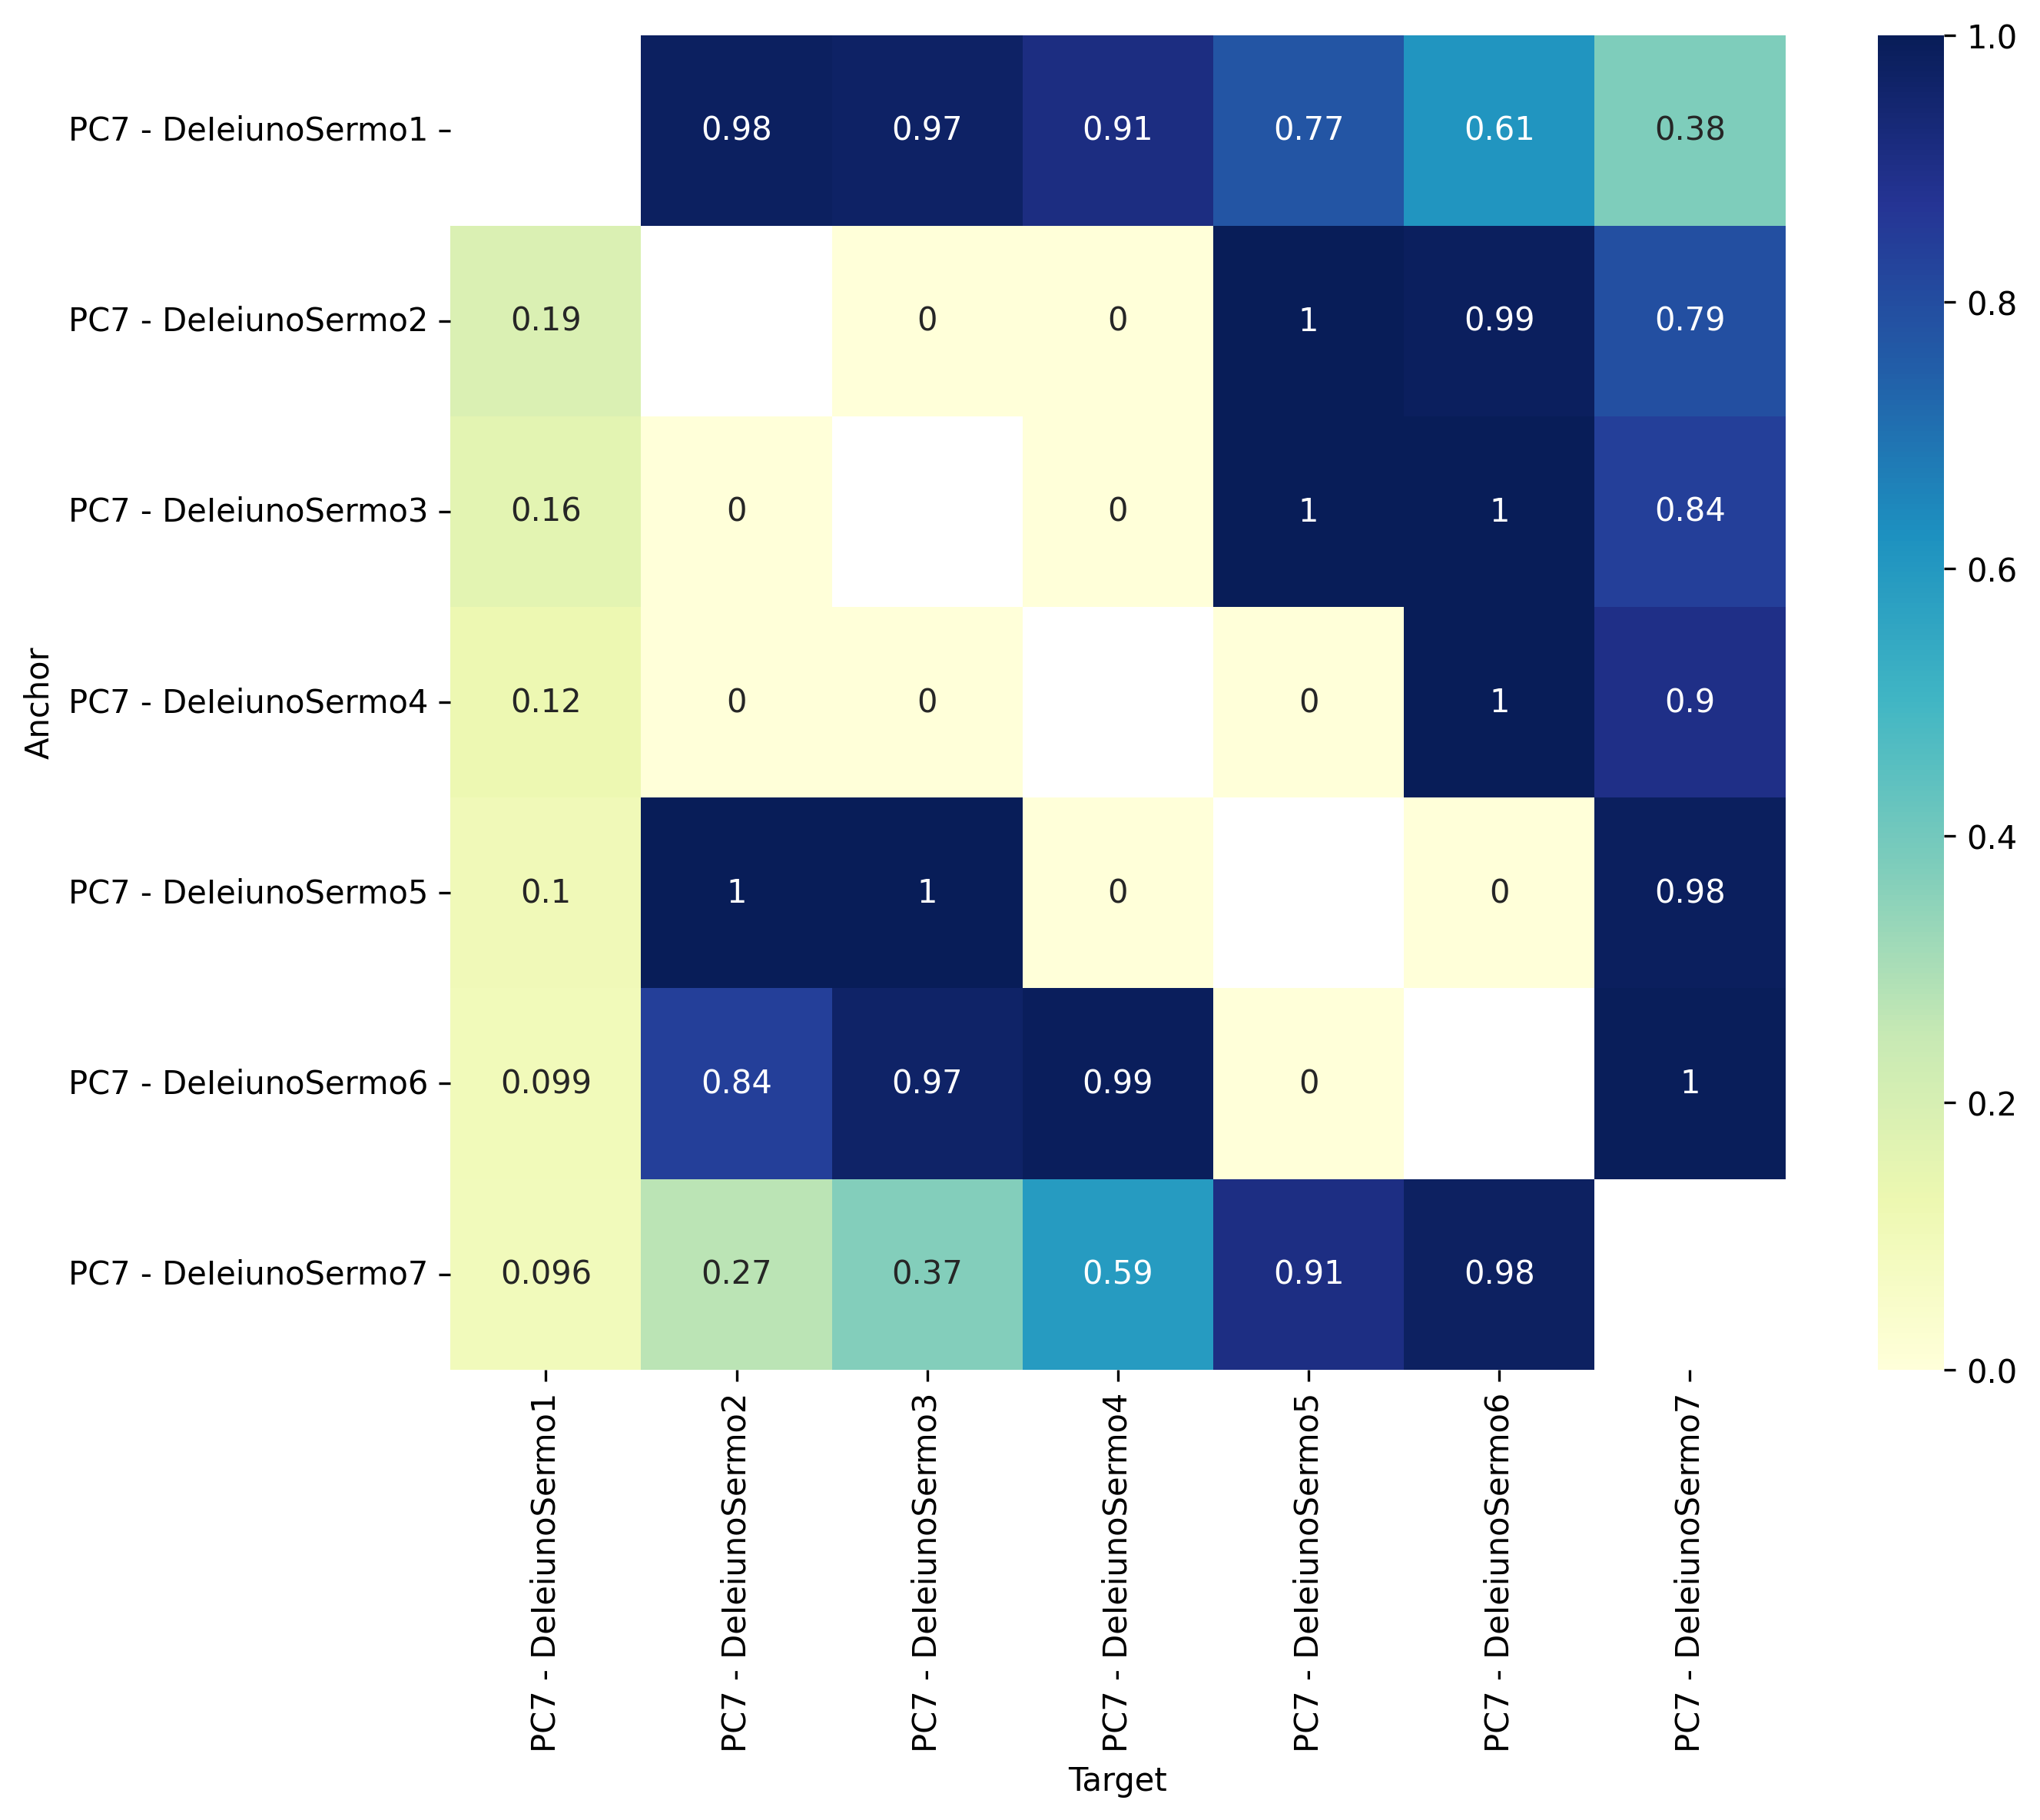

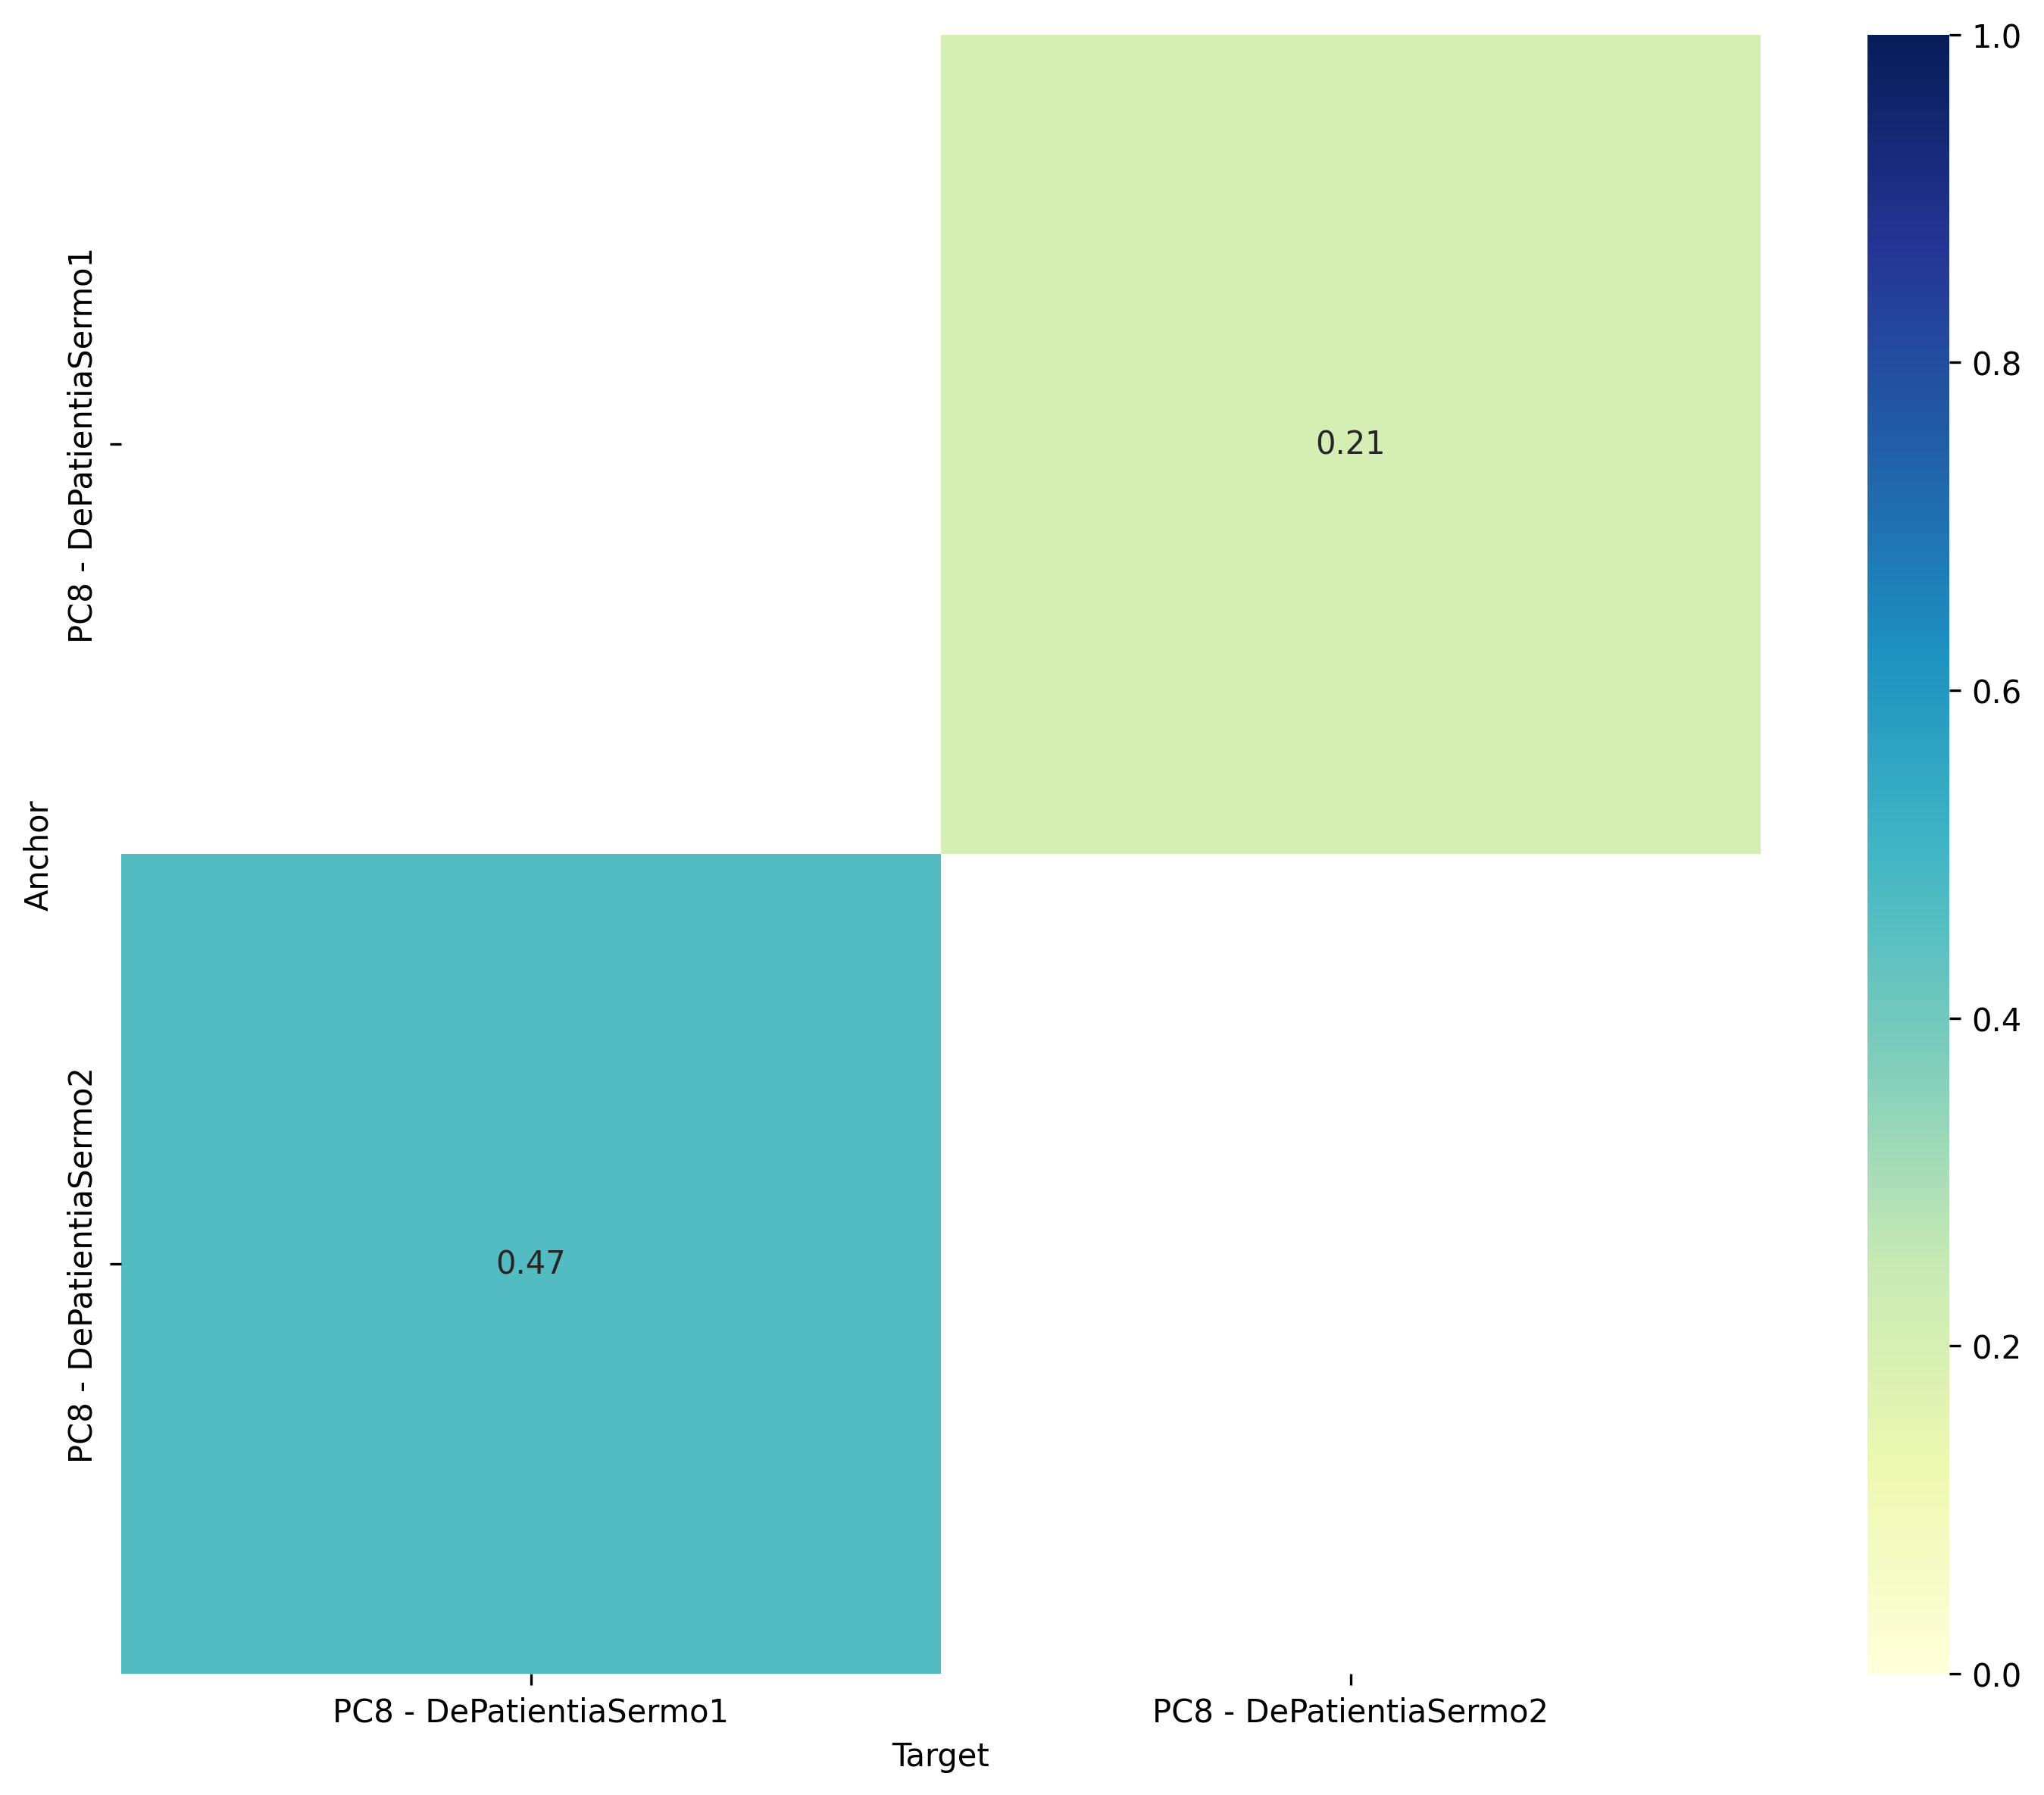

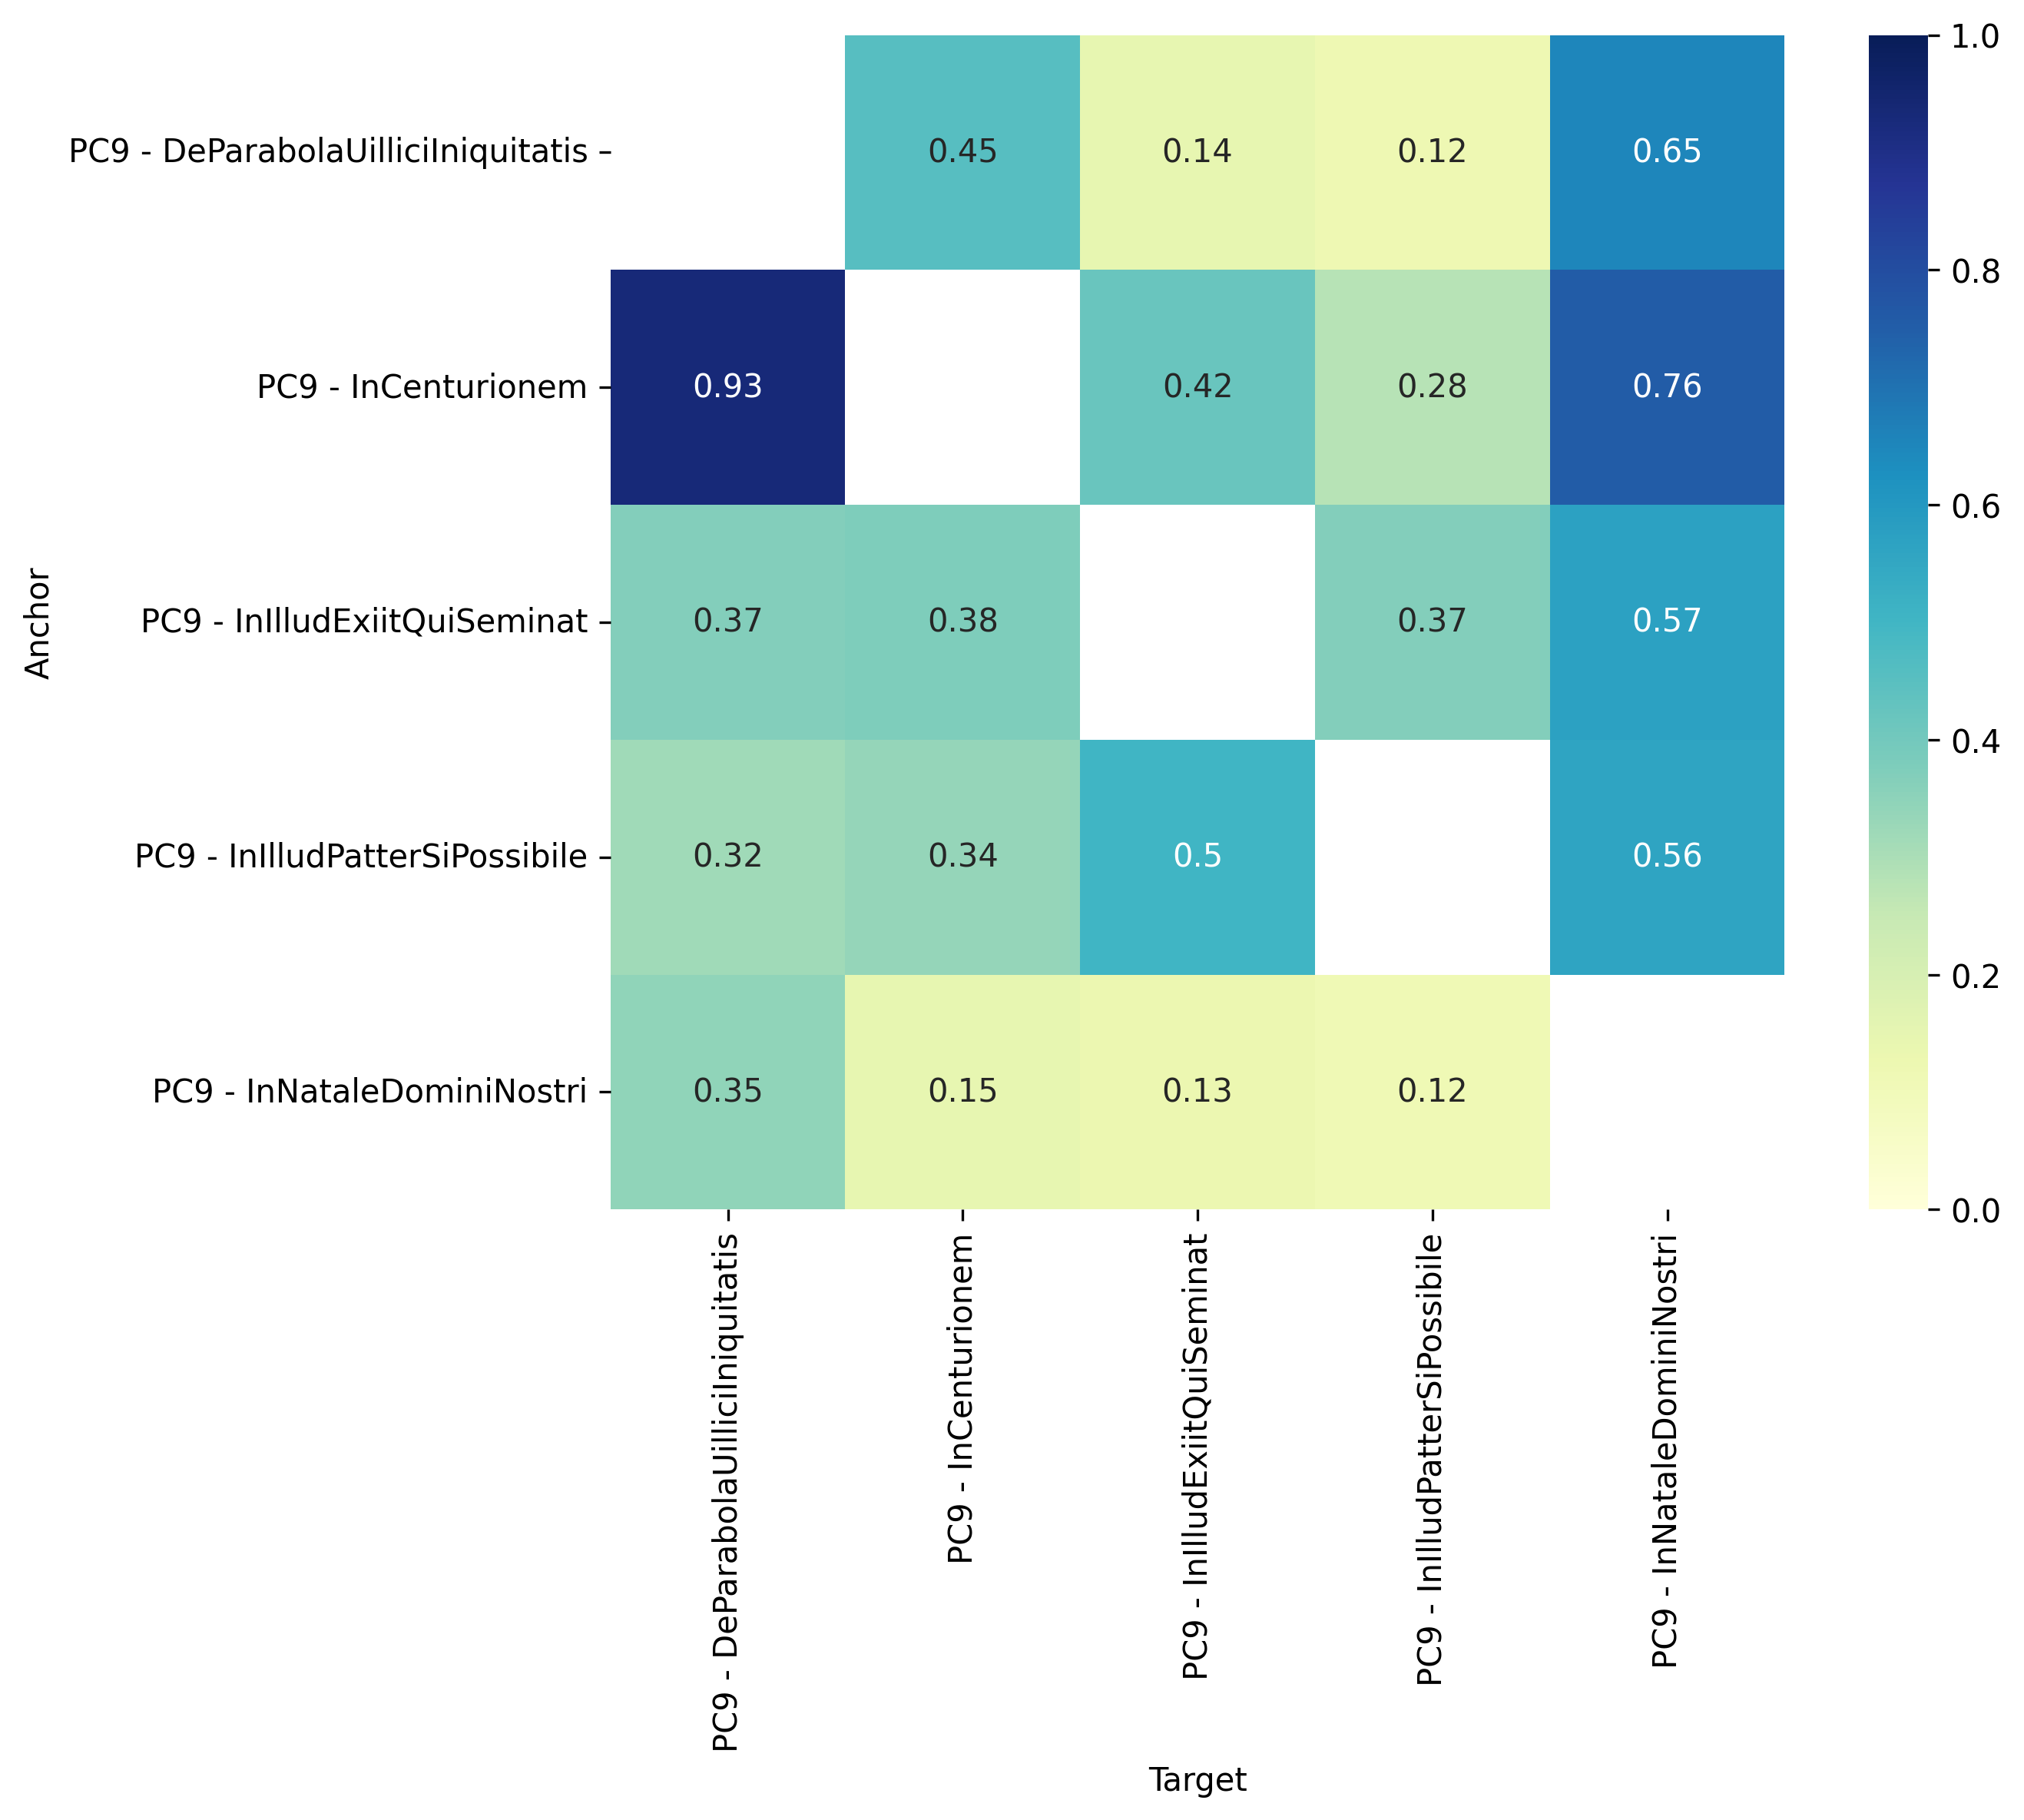

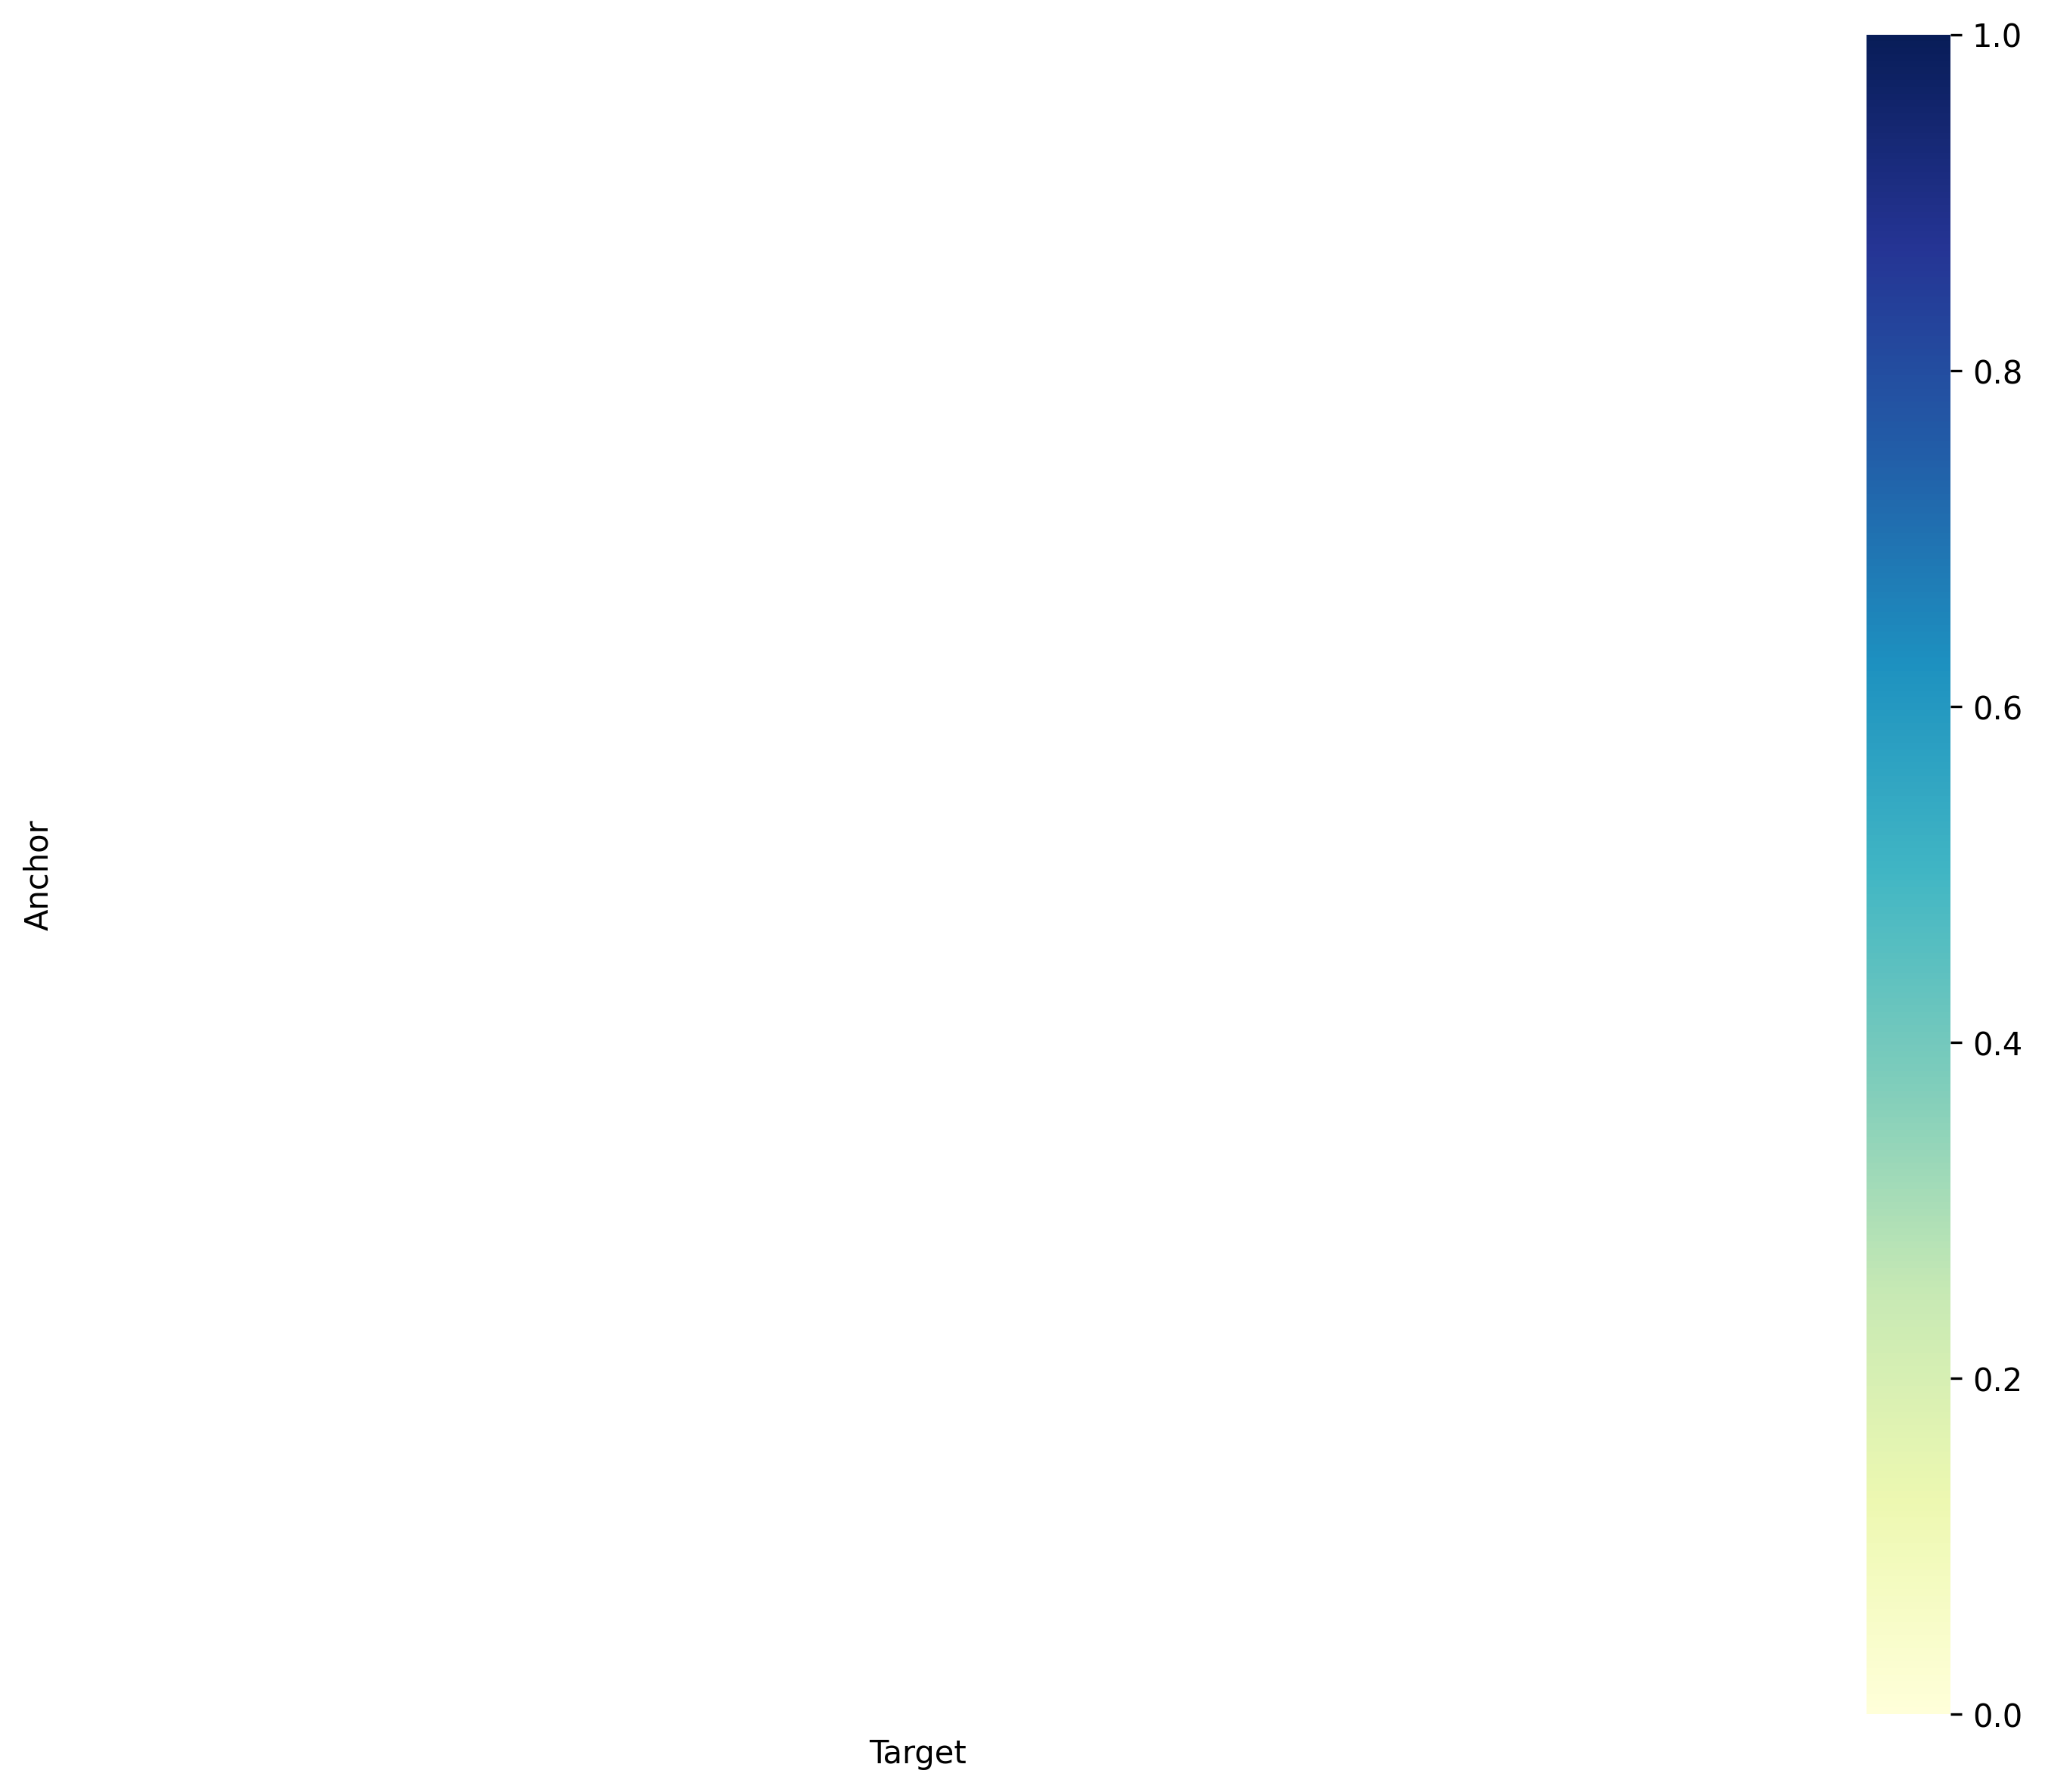

In [40]:
for cls in classes:
    fig, ax = plt.subplots(1, 1, figsize = (10, 8), dpi=300)

    sns.heatmap(
        get_sub_df(cls).pivot_table(index="ComparedLabel", columns=["ComparatorLabel"], values="TestPre"),
        annot=True, square=True, cmap="YlGnBu", vmin=0, vmax=1.0,
        ax=ax
    )
    fig.tight_layout()
    ax.set_ylabel("Anchor")
    ax.set_xlabel("Target")
    fig.savefig(f"heat{cls}.png")


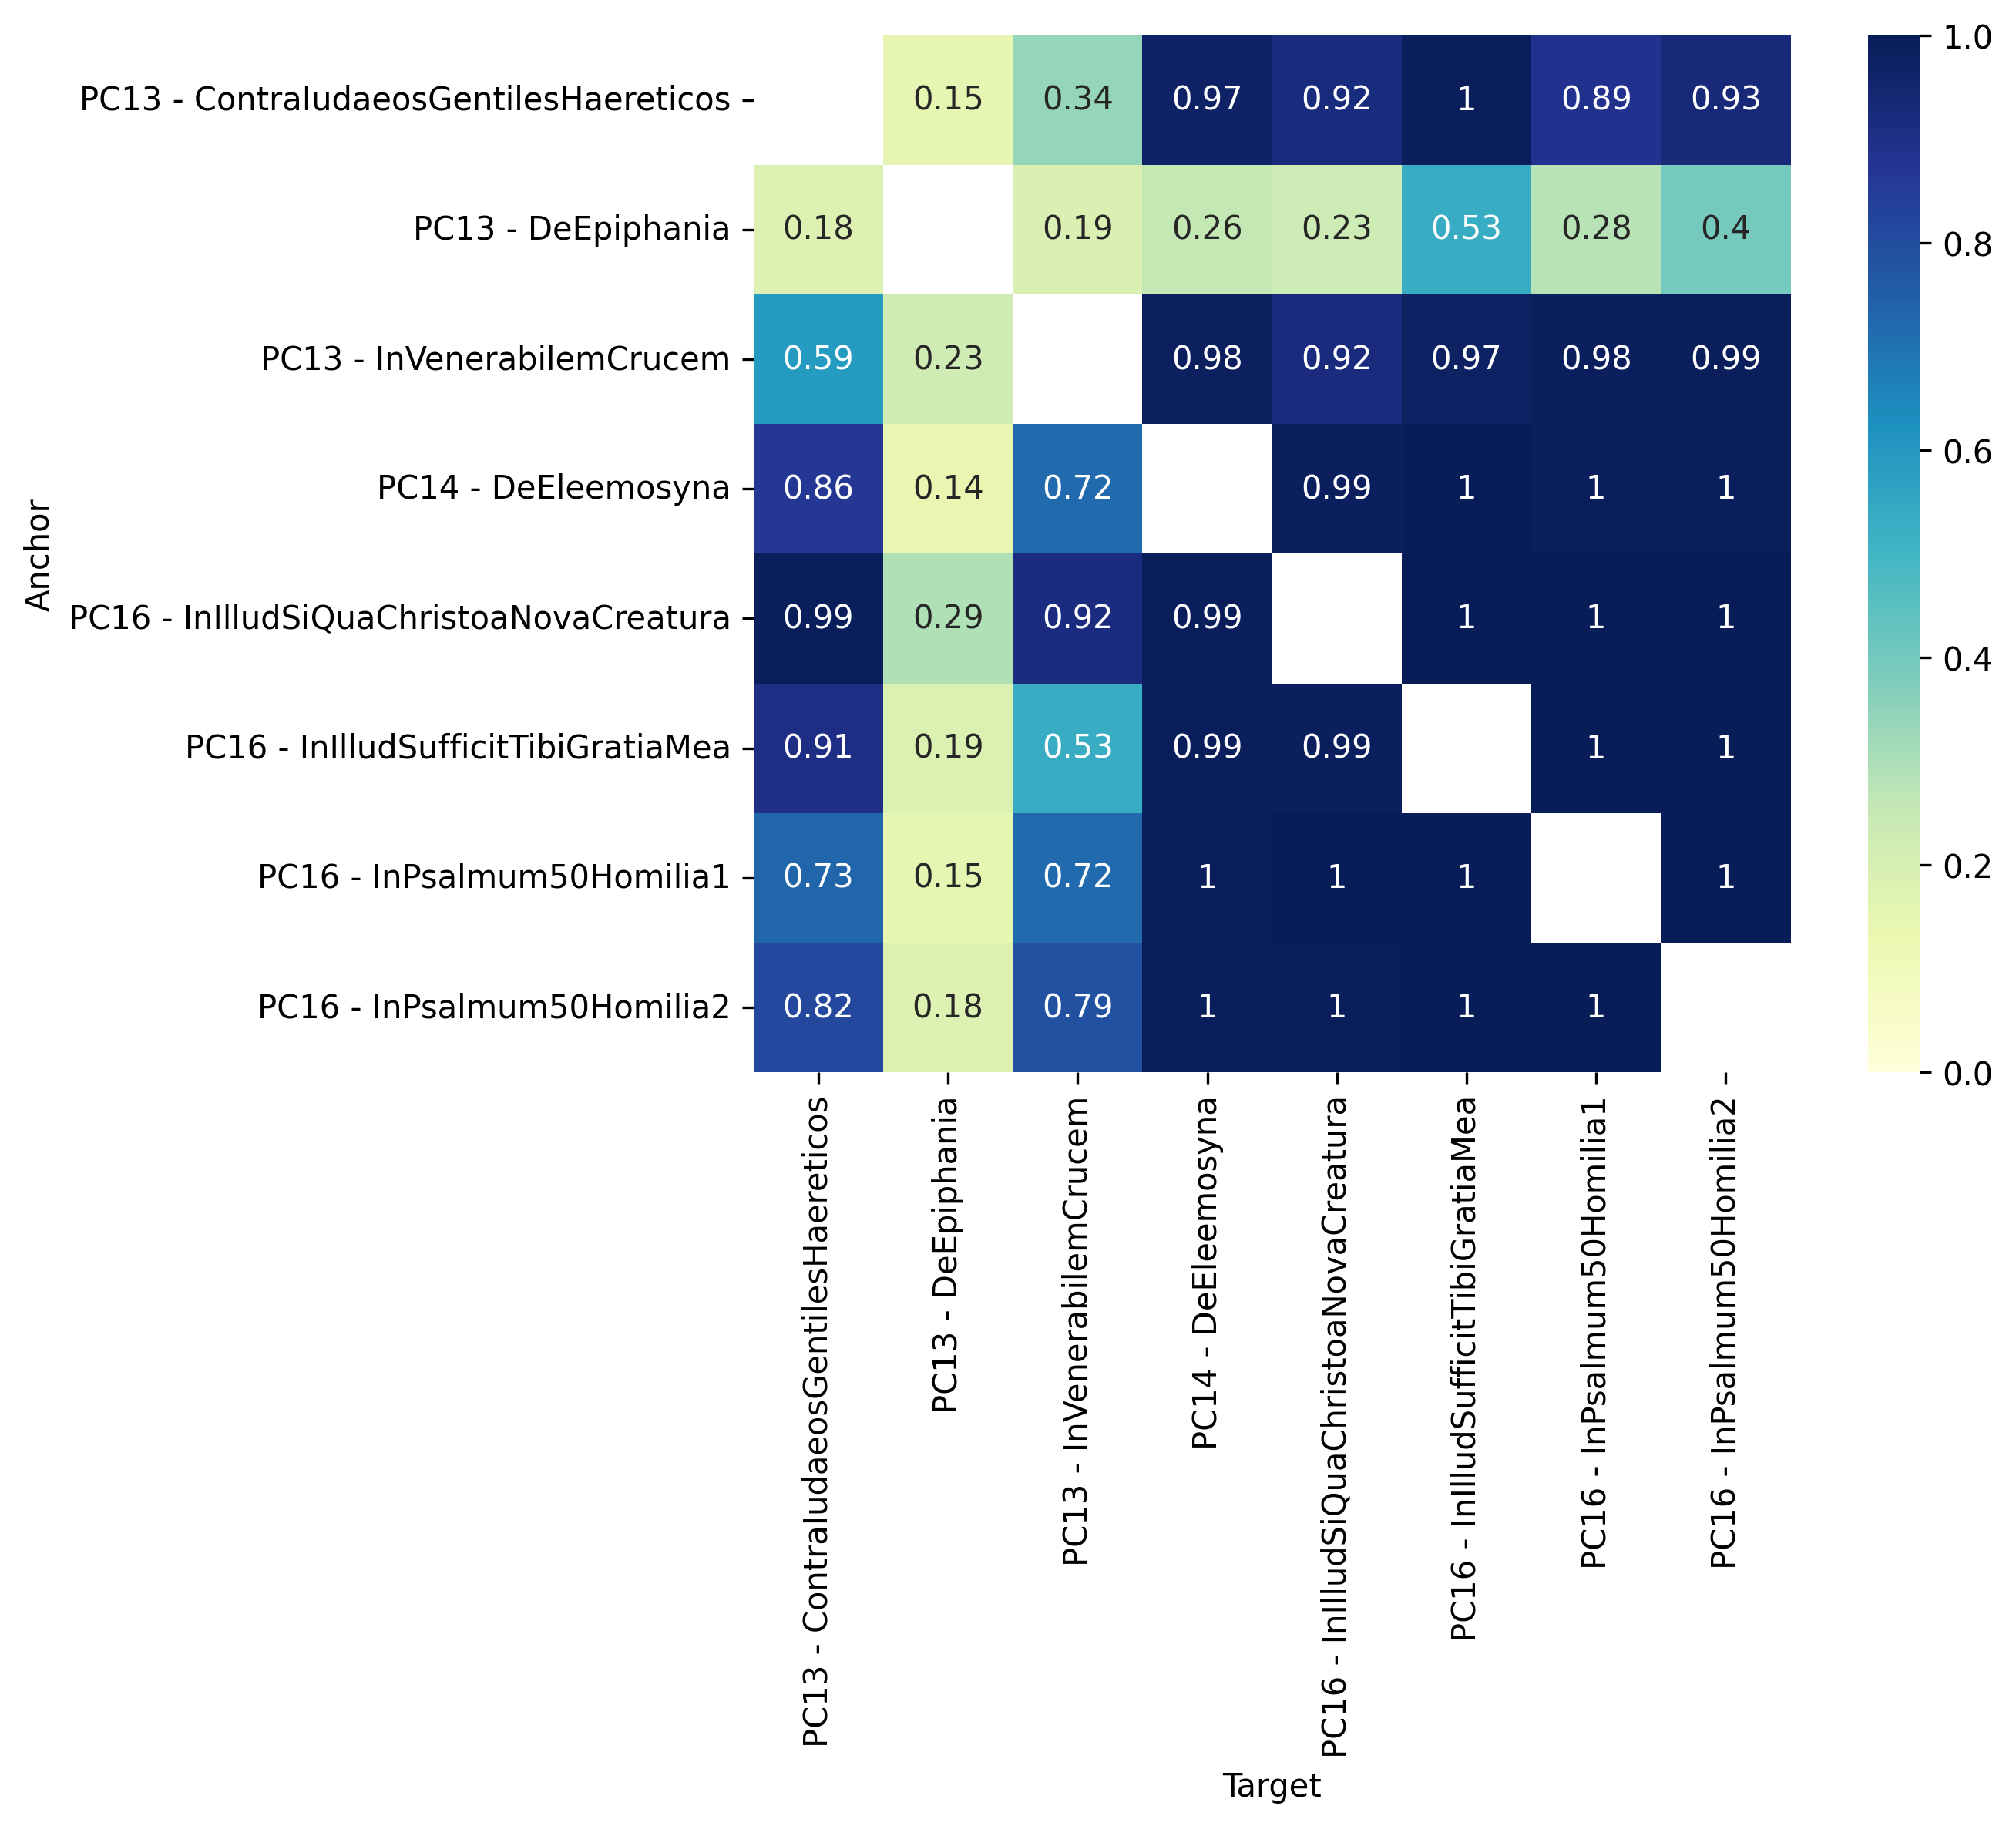

In [52]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8), dpi=300)

sns.heatmap(
    get_sub_df("PC13,PC14,PC16").pivot_table(index="ComparedLabel", columns=["ComparatorLabel"], values="TestPre"),
    annot=True, square=True, cmap="YlGnBu", vmin=0, vmax=1.0,
    ax=ax
)
fig.tight_layout()
ax.set_ylabel("Anchor")
ax.set_xlabel("Target")
fig.savefig(f"heat13-16.png")

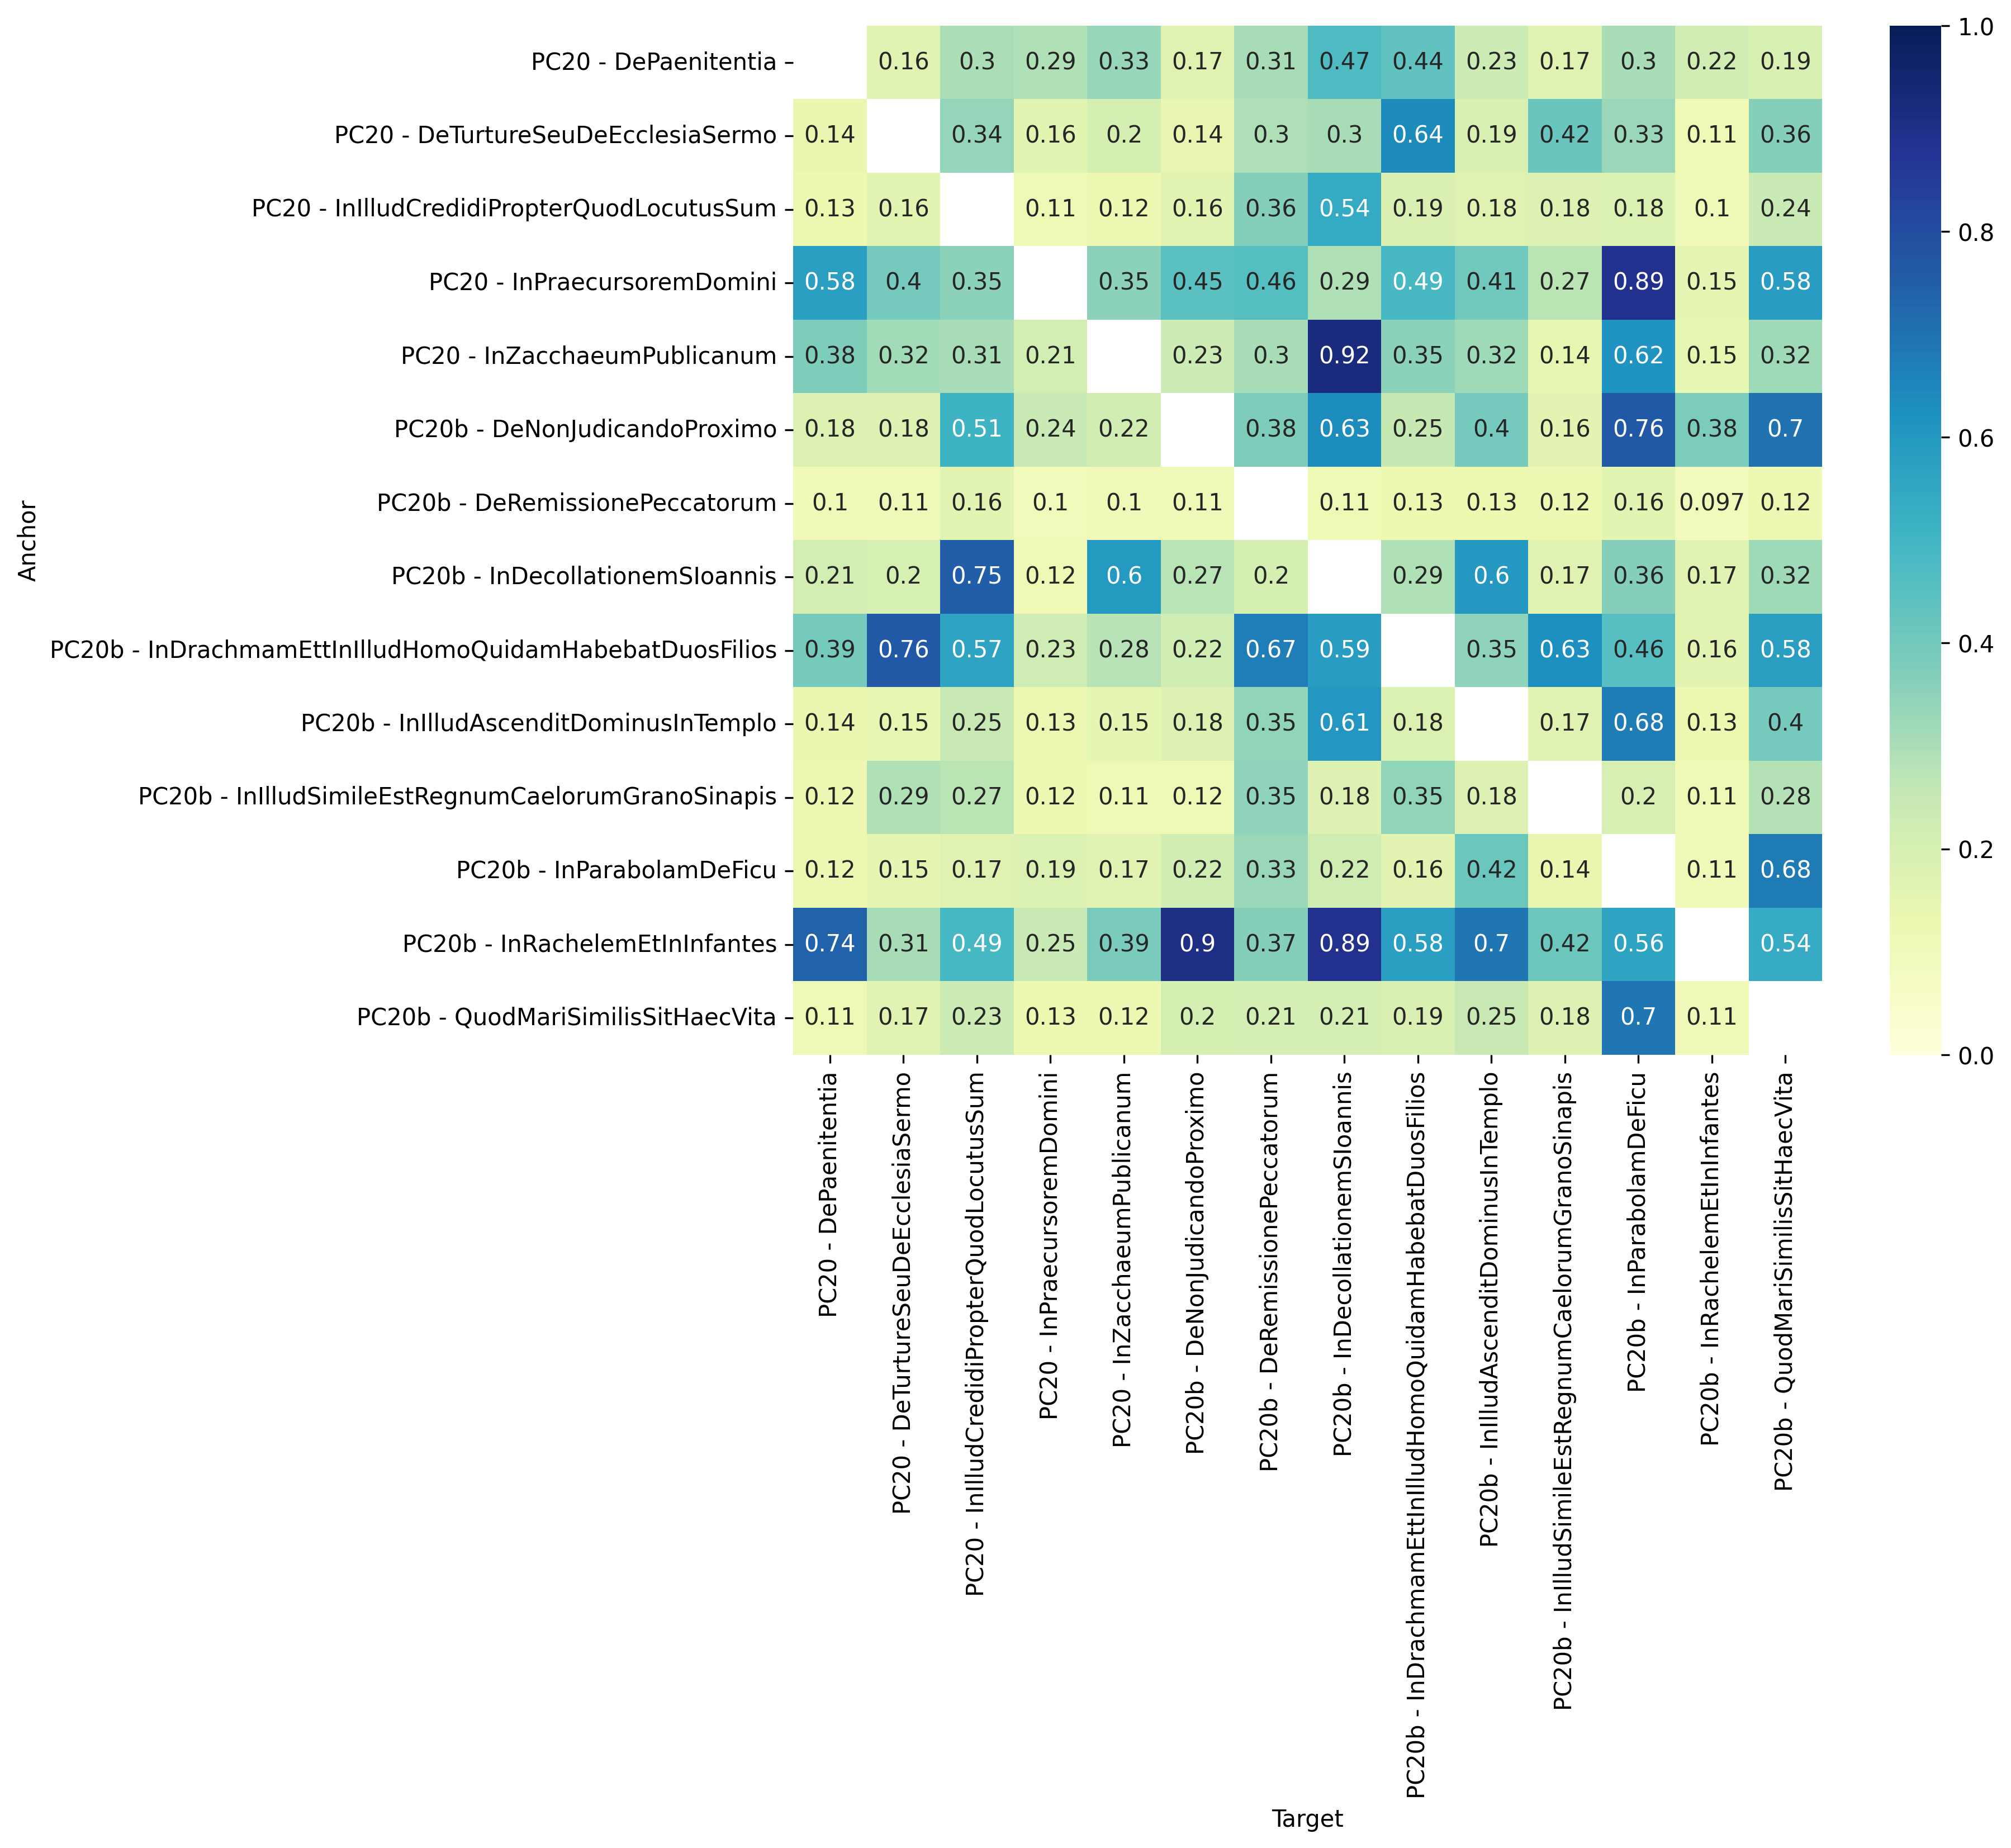

In [55]:
fig, ax = plt.subplots(1, 1, figsize = (13, 11), dpi=300)

sns.heatmap(
    get_sub_df("PC20,PC20b").sort_values("TestPre").pivot_table(index="ComparedLabel", columns=["ComparatorLabel"], values="TestPre"),
    annot=True, square=True, cmap="YlGnBu", vmin=0, vmax=1.0,
    ax=ax
)
fig.tight_layout()
ax.set_ylabel("Anchor")
ax.set_xlabel("Target")
fig.savefig(f"heat2020b.png")